In [14]:
# Import necessary classes
from utils.graphics.Image import Image
from utils.graphics.Point import Point
from digitization.Preprocessorv2 import Preprocessor 

In [15]:
import copy
import io
from os.path import splitext
from typing import Iterable, Sequence, Tuple
import cv2 as cv
import numpy as np
from pdf2image import convert_from_path
from pdf2image.exceptions import PDFPageCountError
from utils.graphics.ColorSpace import ColorSpace
from utils.graphics.Point import Point
from utils.graphics.Rectangle import Rectangle

class CustomImage:
    """
    A class that combines the functionalities of the original CustomImage and Image classes.
    """

    def __init__(self, array: np.ndarray = None, path: str = None) -> None:
        """
        Initialization of the image, either from an array or from a path.

        Args:
            array (np.ndarray): Numpy array containing the image data.
            path (str): Path to the image file.

        Raises:
            TypeError: If array is not a numpy array.
            FileNotFoundError: If the file does not exist.
        """
        self.__color_space = ColorSpace.BGR
        self.__data = None

        if array is not None:
            if isinstance(array, np.ndarray):
                self.__data = array
            else:
                raise TypeError("Expected a numpy.ndarray object")
        elif path is not None:
            _, file_extension = splitext(path)
            pdf_except = False
            if file_extension == ".pdf":
                try:
                    buffer = io.BytesIO()
                    pdf = convert_from_path(path)
                    pdf[0].save(buffer, format="png")
                    buffer.seek(0)
                    img_arr = np.frombuffer(buffer.getvalue(), dtype=np.uint8)
                    buffer.close()
                    self.__data = cv.imdecode(img_arr, cv.IMREAD_COLOR)
                except PDFPageCountError:
                    pdf_except = True
            else:
                self.__data = cv.imread(path)
            if self.__data is None or pdf_except:
                raise FileNotFoundError(f'File "{path}" does not exist')
        else:
            raise ValueError("Either array or path must be provided")

    def __getitem__(self, index: Sequence) -> Iterable[Iterable[int | Iterable[int]]]:
        return self.__data[index]

    def __setitem__(self, index: Sequence, value: Iterable[Iterable[int | Iterable[int]]]) -> None:
        self.__data[index] = value

    @property
    def data(self) -> Iterable[Iterable[int | Iterable[int]]]:
        return self.__data

    @data.setter
    def data(self, data: Iterable[Iterable[int | Iterable[int]]]) -> None:
        self.__data = data

    @property
    def height(self) -> int:
        return self.__data.shape[0]

    @property
    def width(self) -> int:
        return self.__data.shape[1]

    @property
    def white(self) -> int | Tuple[int, int, int]:
        if self.__color_space == ColorSpace.GRAY:
            return 255
        if self.__color_space == ColorSpace.HSV:
            return [0, 0, 255]
        return [255, 255, 255]

    @property
    def black(self) -> int | Tuple[int, int, int]:
        if self.__color_space == ColorSpace.GRAY:
            return 0
        return [0, 0, 0]
    

    @property
    def array(self):
        return self.data  # Assuming self.data is your image's numpy array.

    def copy(self) -> 'CustomImage':
        return copy.deepcopy(self)

    def save(self, path: str) -> None:
        self.to_BGR()
        cv.imwrite(path, self.__data)

    def crop(self, r: Rectangle) -> None:
        tl = r.top_left
        br = r.bottom_right
        self.__data = self.__data[tl.y : br.y, tl.x : br.x]

    def threshold(self, thres: int, value: int) -> None:
        _, self.__data = cv.threshold(self.__data, thres, value, cv.THRESH_BINARY)
        self.to_GRAY()

    def line(self, p1: Point, p2: Point, color: Tuple[int, int, int], thickness: int):
        cv.line(self.__data, (p1.x, p1.y), (p2.x, p2.y), color, thickness=thickness)

    def is_GRAY(self) -> bool:
        return self.__color_space == ColorSpace.GRAY

    def is_BGR(self) -> bool:
        return self.__color_space == ColorSpace.BGR

    def is_RGB(self) -> bool:
        return self.__color_space == ColorSpace.RGB

    def is_HSV(self) -> bool:
        return self.__color_space == ColorSpace.HSV

    def to_GRAY(self) -> None:
        if self.is_RGB():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_RGB2GRAY)
        elif self.is_BGR():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_BGR2GRAY)
        elif self.is_HSV():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_HSV2GRAY)
        self.__color_space = ColorSpace.GRAY

    def to_BGR(self) -> None:
        if self.is_GRAY():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_GRAY2BGR)
        elif self.is_RGB():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_RGB2BGR)
        elif self.is_HSV():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_HSV2BGR)
        self.__color_space = ColorSpace.BGR

    def to_RGB(self) -> None:
        if self.is_GRAY():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_GRAY2RGB)
        elif self.is_BGR():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_BGR2RGB)
        elif self.is_HSV():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_HSV2RGB)
        self.__color_space = ColorSpace.RGB

    def to_HSV(self) -> None:
        if self.is_GRAY():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_GRAY2HSV)
        elif self.is_BGR():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_BGR2HSV)
        elif self.is_RGB():
            self.__data = cv.cvtColor(self.__data, cv.COLOR_RGB2HSV)
        self.__color_space = ColorSpace.HSV


## Single test:  cubic spline interpolation

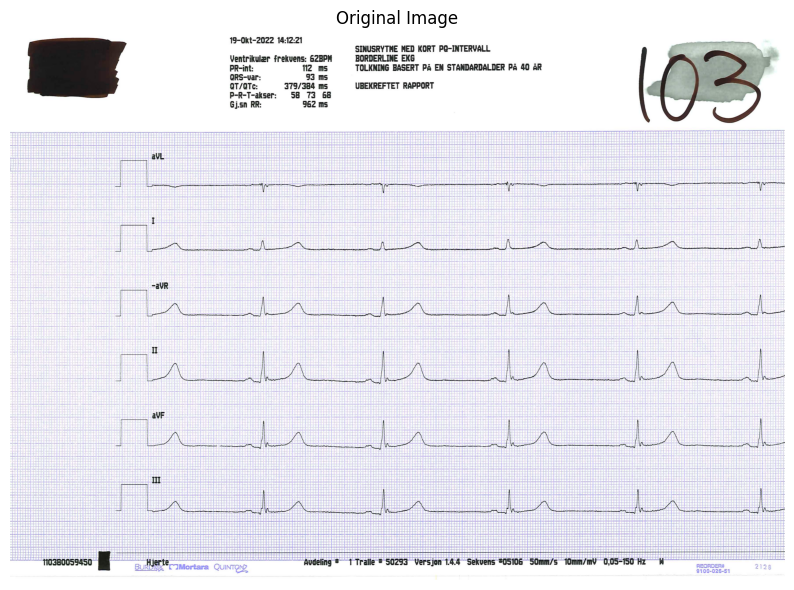

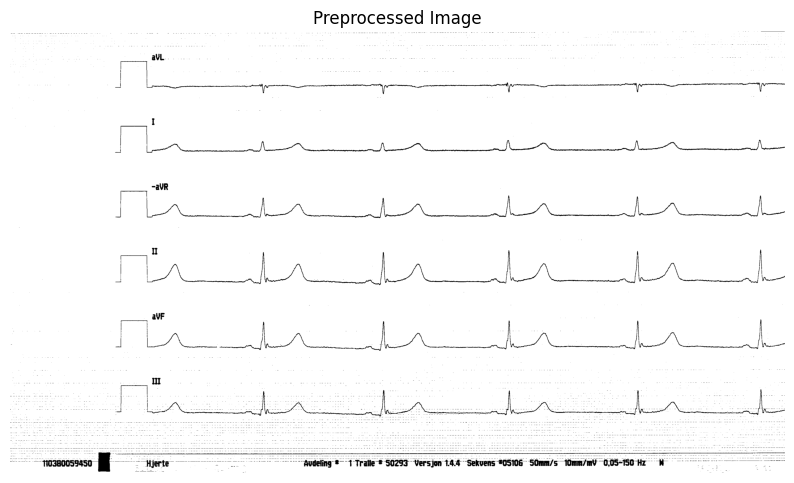

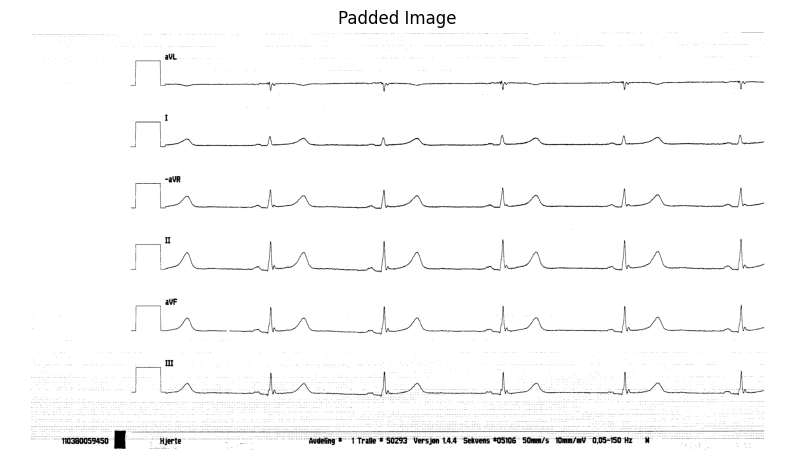

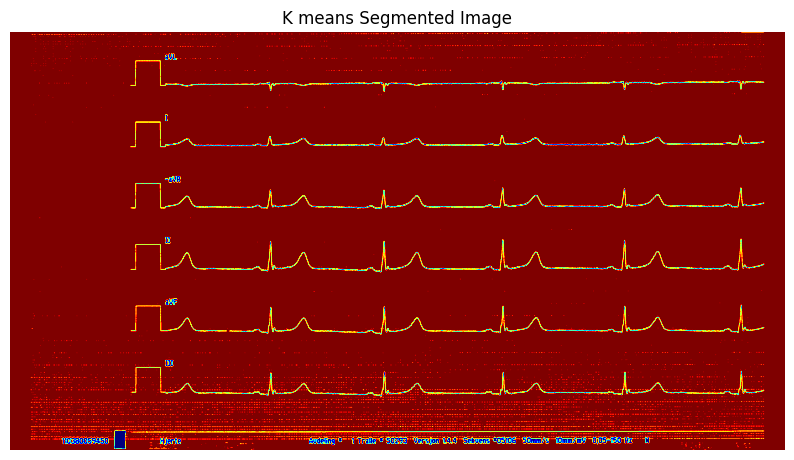

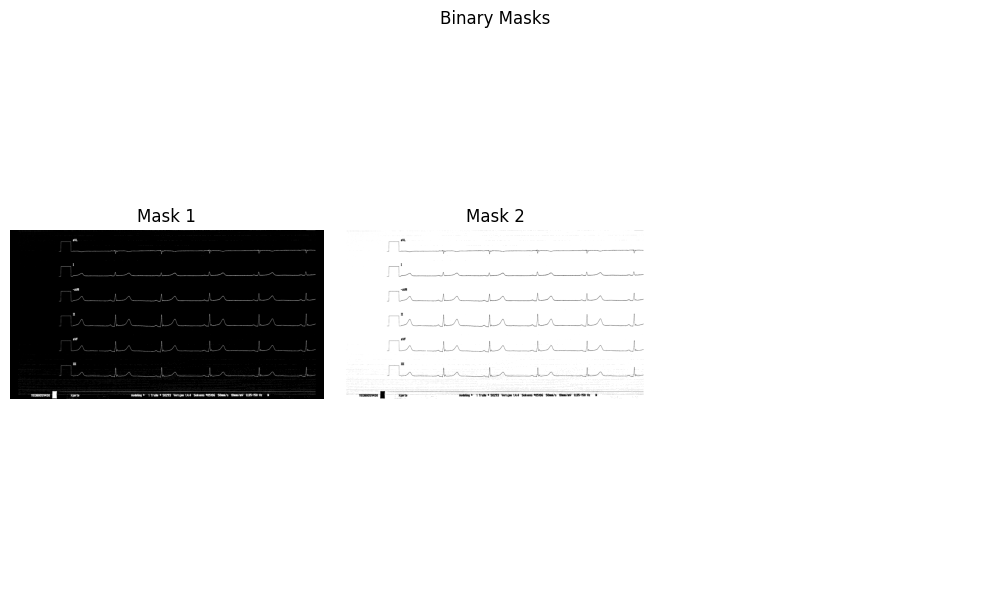

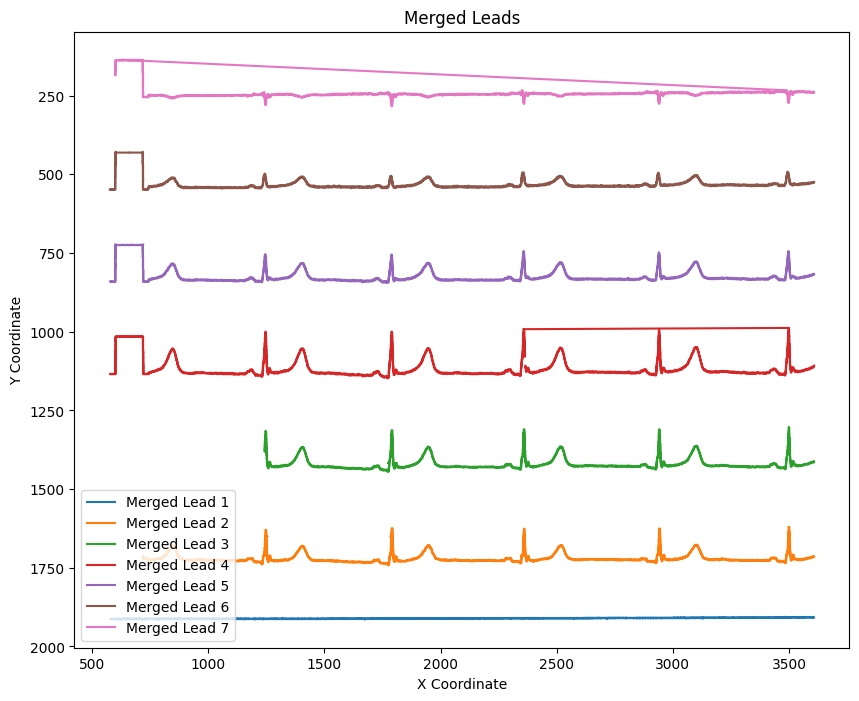

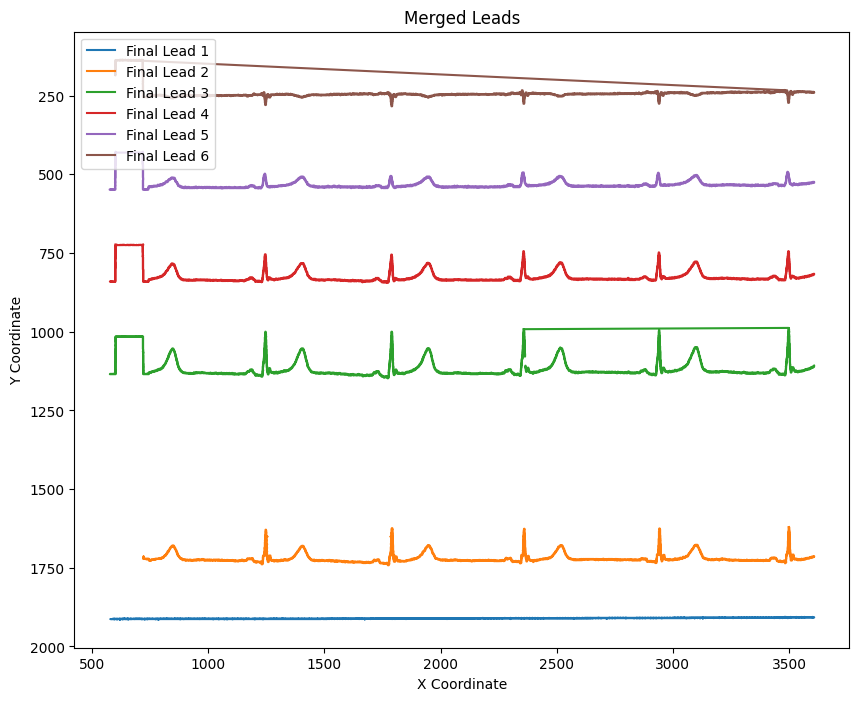

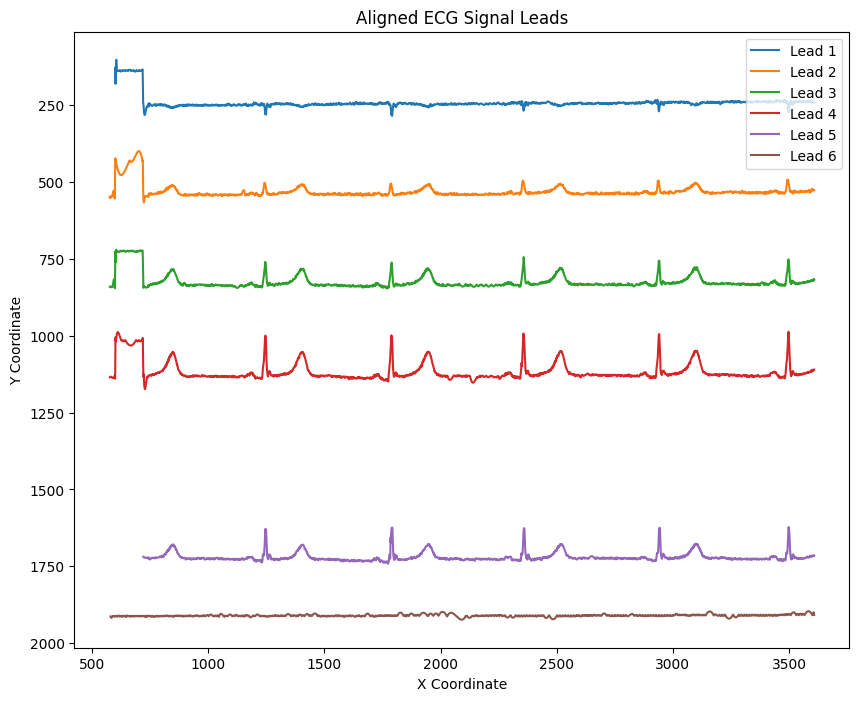

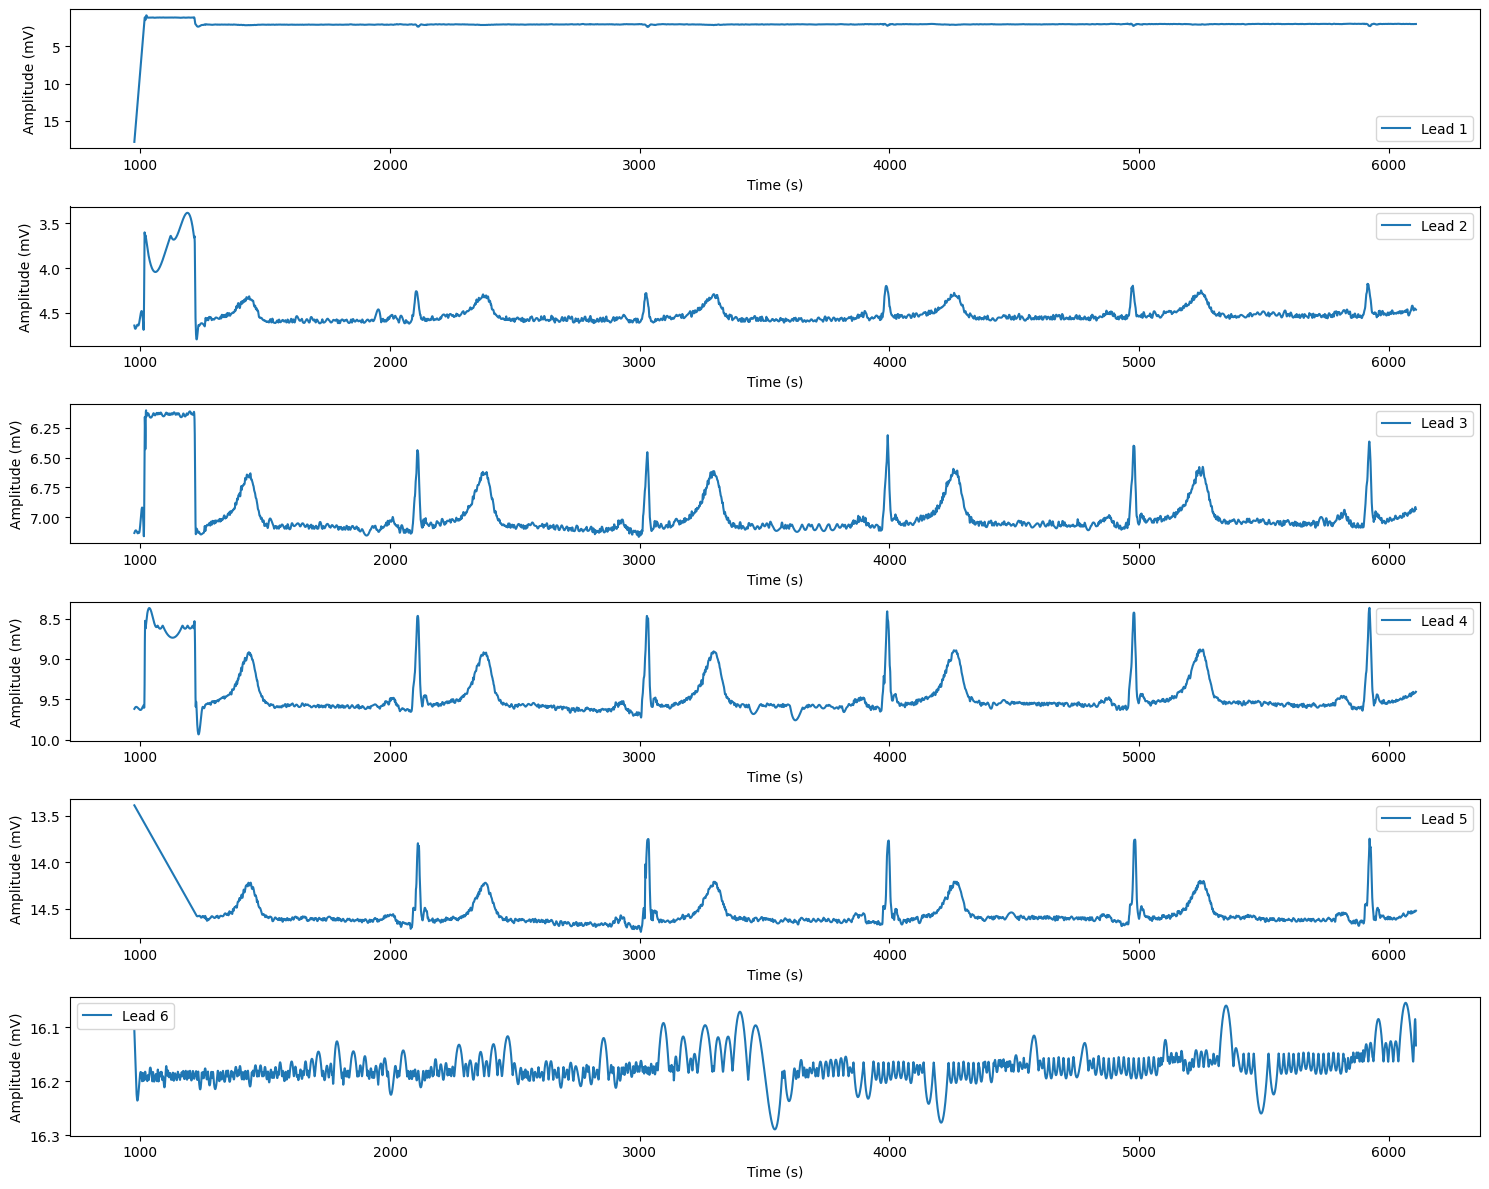

Time and amplitude values have been saved to ecg_time_amplitude.csv


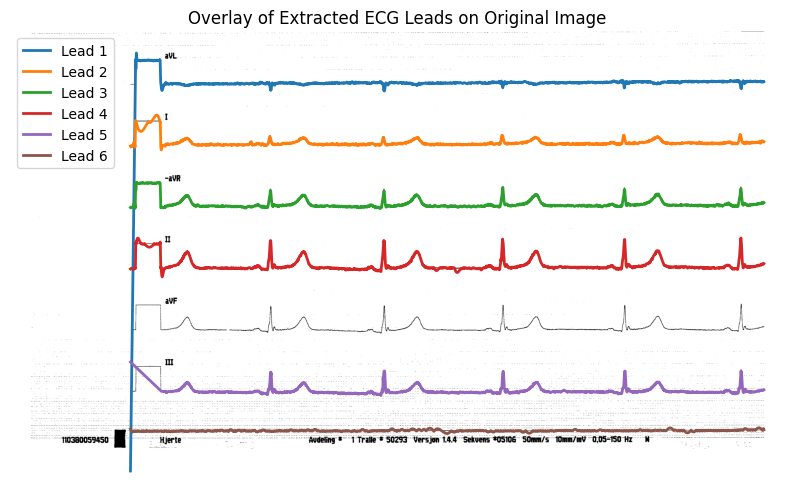

In [26]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import sys
from scipy import ndimage  # Make sure to import ndimage for `find_objects`
from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline

# Helper function to plot images
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_aligned_coordinates(aligned_coords):
    plt.figure(figsize=(10, 8))
    
    # Reverse the order of aligned leads to match top-to-bottom ordering
    for i, coords in enumerate(reversed(aligned_coords)):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Lead {i+1}')
    
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.title('Aligned ECG Signal Leads')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


def apply_kmeans(image, n_clusters=2):
    Z = image.reshape((-1, 1))  # Flatten the image
    Z = np.float32(Z)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(Z, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape((image.shape))
    return segmented_image, centers

def create_binary_masks(segmented_image, n_clusters):
    binary_masks = [(segmented_image == i).astype(np.uint8) * 255 for i in range(n_clusters)]
    return binary_masks

def extract_contour_coordinates(binary_masks):
    contour_coordinates = []
    for mask in binary_masks:
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            coords = contour[:, 0, :]  # Extract x and y coordinates
            contour_coordinates.append(coords)
    return contour_coordinates

def calculate_gradient(coords):
    # Fit a linear regression to the x and y coordinates to find the slope (gradient)
    X = coords[:, 0].reshape(-1, 1)  # x-coordinates
    y = coords[:, 1]  # y-coordinates
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]  # The gradient of the line (dy/dx)
    return slope

def filter_and_merge_leads(contour_coords, min_size=1000, y_threshold=30, gradient_threshold=0.05):
    # Filter out small contours
    large_contours = [coords for coords in contour_coords if len(coords) > min_size]

    merged_leads = []
    current_lead = []
    
    for i, coords in enumerate(large_contours):
        if not current_lead:
            current_lead.append(coords)
            continue

        # Calculate the gradient for the current contour and the first contour in the current lead
        current_gradient = calculate_gradient(coords)
        lead_gradient = calculate_gradient(current_lead[0])

        # Check if the y-values are similar and gradients are similar enough to merge
        if (np.abs(coords[:, 1].mean() - current_lead[0][:, 1].mean()) < y_threshold and
            np.abs(current_gradient - lead_gradient) < gradient_threshold):
            current_lead.append(coords)
        else:
            # Merge the current lead
            merged_leads.append(np.vstack(current_lead))
            current_lead = [coords]

    # Add the last lead
    if current_lead:
        merged_leads.append(np.vstack(current_lead))

    return merged_leads


def enforce_only_leads(merged_coords, max_leads=6):
    """
    This function selects 6 leads that have consistent x ranges, ensuring that
    6 leads are always selected.
    
    Args:
    merged_coords: List of np.array coordinates of the leads.
    max_leads: The number of leads to select (default is 6).
    
    Returns:
    selected_coords: List of np.array coordinates of the selected leads.
    """
    
    # Calculate the x range for each lead
    lead_ranges = [
        (i, 
         coords[:, 0].max() - coords[:, 0].min()  # x range
        ) 
        for i, coords in enumerate(merged_coords)
    ]
    
    # Calculate the mean x range
    mean_x_range = np.mean([lead[1] for lead in lead_ranges])
    
    # Find the lead whose x range is closest to the mean x range
    initial_lead = min(lead_ranges, key=lambda x: abs(x[1] - mean_x_range))
    selected_leads = [initial_lead]  # Start with the lead closest to the mean
    
    # Sort the remaining leads by their proximity to the initial lead in x range
    remaining_leads = [
        lead for lead in lead_ranges if lead != initial_lead
    ]
    
    # Sort based on proximity in x range only
    remaining_leads.sort(
        key=lambda x: abs(x[1] - initial_lead[1])
    )
    
    # Select the top remaining leads based on x range proximity
    selected_leads += remaining_leads[:max_leads-1]  # Adding remaining leads to make 6 in total
    
    # Extract the indices of the selected leads
    selected_indices = [lead[0] for lead in selected_leads]
    
    # Return the selected leads while preserving the original order
    selected_coords = [merged_coords[i] for i in sorted(selected_indices)]
    
    return selected_coords
    
def plot_binary_masks(binary_masks):
    num_masks = len(binary_masks)
    cols = 3
    rows = (num_masks + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    plt.suptitle('Binary Masks')
    
    for i, mask in enumerate(binary_masks):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f'Mask {i+1}')
        axes[i].axis('off')

    for j in range(num_masks, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_merged_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Merged Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

    
def plot_final_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Final Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

def plot_lead_time_amplitude(time_amplitude_df):
    """
    Plots time vs amplitude for each lead in the time_amplitude_df DataFrame.
    
    :param time_amplitude_df: DataFrame containing time and amplitude columns for each lead.
    """
    num_leads = len([col for col in time_amplitude_df.columns if '_time' in col])
    
    plt.figure(figsize=(15, num_leads * 2))
    
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amplitude_col = f'Lead_{i}_amplitude'
        
        plt.subplot(num_leads, 1, i)  # Creates a subplot for each lead
        plt.plot(time_amplitude_df[time_col], time_amplitude_df[amplitude_col], label=f'Lead {i}')
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def align_leads(contour_coords, num_points=5000):
    aligned_coords = []
    for coords in contour_coords:
        x = coords[:, 0]
        y = coords[:, 1]

        # Remove duplicate x values to ensure CubicSpline works correctly
        unique_x, unique_indices = np.unique(x, return_index=True)
        unique_y = y[unique_indices]
        
        # Apply cubic spline interpolation
        cs = CubicSpline(unique_x, unique_y)
        
        # Generate new x values for interpolation
        x_new = np.linspace(unique_x.min(), unique_x.max(), num_points)
        y_new = cs(x_new)
        
        aligned_coords.append(np.column_stack((x_new, y_new)))
    return aligned_coords


def plot_time_amplitude_overlay(image_path, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y):
    """
    Plots the ECG leads overlaying on the original ECG image.

    :param image_path: The path to the original ECG image or the image matrix.
    :param time_amplitude_df: DataFrame containing the time and amplitude for each lead.
    :param pixels_per_mm_x: The pixel-to-mm conversion factor for the x-axis (time).
    :param pixels_per_mm_y: The pixel-to-mm conversion factor for the y-axis (amplitude).
    """

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Plot the original ECG image
    plt.imshow(image_path, cmap='gray')

    # Ensure consistency with the conversion factors used in image_to_sequence_1ms
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # 50 mm = 1 second, converted to ms
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    # Reverse the conversion factors for plotting
    pixel_per_time = 1 / time_per_pixel
    pixel_per_amplitude = 1 / amplitude_per_pixel

    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    # Overlay each lead present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'
        
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            # Convert time and amplitude back to pixel coordinates
            x_pixels = time_amplitude_df[time_col] * pixel_per_time
            y_pixels = time_amplitude_df[amp_col] * pixel_per_amplitude

            plt.plot(x_pixels, y_pixels, label=f'Lead {i}', linewidth=2)  # Plot each lead
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.title('Overlay of Extracted ECG Leads on Original Image')
    plt.xlabel('Time (pixels)')
    plt.ylabel('Amplitude (pixels)')
    plt.legend()
    plt.axis('off')  # Hide axis since we're overlaying on an image
    plt.show()


def image_to_sequence_1ms(contour_coords, pixels_per_mm_x, pixels_per_mm_y):
    """
    Converts the contour coordinates into time-amplitude sequences using pixel-to-time and pixel-to-amplitude conversions.
    Enforces 1 ms time steps by interpolation.
    
    :param contour_coords: A list of contour coordinates (x, y).
    :param pixels_per_mm_x: The conversion factor from pixels to mm for the x-axis (time).
    :param pixels_per_mm_y: The conversion factor from pixels to mm for the y-axis (amplitude).
    :return: DataFrame containing time and amplitude for each lead with 1 ms time steps.
    """
    lead_data = {}

    # Conversion factors
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # Convert to milliseconds
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    num_leads = len(contour_coords)

    # Find the minimum and maximum time across all leads
    all_time_values = []
    for coords in contour_coords:
        time_values = coords[:, 0] * time_per_pixel
        all_time_values.extend(time_values)
    
    min_time = min(all_time_values)
    max_time = max(all_time_values)

    # Create a common uniformly spaced time array for all leads
    uniform_time_values = np.arange(min_time, max_time, 1)  # 1 ms step

    for i, coords in enumerate(contour_coords):
        # Reverse the lead numbering
        lead_number = num_leads - i
        
        # Original time and amplitude values
        original_time_values = coords[:, 0] * time_per_pixel  # Convert x-coordinates to time in ms
        original_amplitude_values = coords[:, 1] * amplitude_per_pixel  # Convert y-coordinates to amplitude in mV
        
        # Interpolate amplitude values to fit the uniform time grid
        interp_func = interp1d(original_time_values, original_amplitude_values, kind='linear', fill_value="extrapolate")
        interpolated_amplitude_values = interp_func(uniform_time_values)
        
        # Save the uniformly spaced time and interpolated amplitude values
        lead_data[f'Lead_{lead_number}_time'] = uniform_time_values
        lead_data[f'Lead_{lead_number}_amplitude'] = interpolated_amplitude_values

    return pd.DataFrame(lead_data)

# Main processing function
def process_ecg_image(image_path, padding_size=100):
    # Step 1: Load the image
    image = cv.imread(image_path)
    if image is None:
        print('Cannot open image: ' + image_path)
        sys.exit(0)

    plot_image(image, 'Original Image')

    # Convert the image to a custom Image class
    img_obj = CustomImage(image)

    # Initialize Preprocessor
    preprocessor = Preprocessor()

    # Apply preprocessing
    preprocessed_img_obj, rect = preprocessor.preprocess(img_obj)
    
    # Convert the preprocessed image back to numpy array
    preprocessed_image = preprocessed_img_obj.array

    # Plot the preprocessed image
    plot_image(preprocessed_image, 'Preprocessed Image')

    # Add padding to the left and right of the preprocessed image
    padded_image = cv.copyMakeBorder(
        preprocessed_image, 
        top=0, bottom=0, left=padding_size, right=padding_size, 
        borderType=cv.BORDER_CONSTANT, value=255  # Assuming the background is white (255)
    )
    
    # Plot the padded image
    plot_image(padded_image, 'Padded Image')
    
    # Apply kmeans segmentation on the padded image
    segmented_image, centers = apply_kmeans(padded_image, n_clusters=2)
    plot_image(segmented_image, "K means Segmented Image", cmap='jet')

    # Create binary masks and extract contours
    binary_masks = create_binary_masks(segmented_image, n_clusters=2)
    plot_binary_masks(binary_masks)  # Plot binary masks
    
    contour_coords = extract_contour_coordinates(binary_masks)
    
    # Filter, merge, and align leads
    merged_leads = filter_and_merge_leads(contour_coords)
    plot_merged_leads(merged_leads)  # Plot merged leads

    # Only pull leads
    final_leads = enforce_only_leads(merged_leads)
    plot_final_leads(final_leads)  # Plot merged leads

    # Align leads and sort them from top to bottom
    aligned_leads = align_leads(final_leads, num_points=5000)
    # Plot the aligned ECG leads
    plot_aligned_coordinates(aligned_leads)

    # Example usage with calculated pixel scaling factors
    pixels_per_mm_x = 11.81
    pixels_per_mm_y = 11.81

    # Extract time and amplitude values for each lead (sequence extraction)
    time_amplitude_df = image_to_sequence_1ms(aligned_leads, pixels_per_mm_x, pixels_per_mm_y)
    # Assuming time_amplitude_df is already created from image_to_sequence function
    plot_lead_time_amplitude(time_amplitude_df)


    output_csv_path = 'ecg_time_amplitude.csv'
    time_amplitude_df.to_csv(output_csv_path, index=False)
    print(f"Time and amplitude values have been saved to {output_csv_path}")
    # Plot with ovberlay
    plot_time_amplitude_overlay(padded_image, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y)

    return aligned_leads, time_amplitude_df

# Example usage
image_path = r'../rotated_data_png/103_F_page_1.png'
aligned_leads, time_amplitude_df = process_ecg_image(image_path)




## All files test 1

Time and amplitude values have been saved to digitized_coordinates\100_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\100_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\101_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\101_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\102_F_page_1.csv


KeyboardInterrupt: 

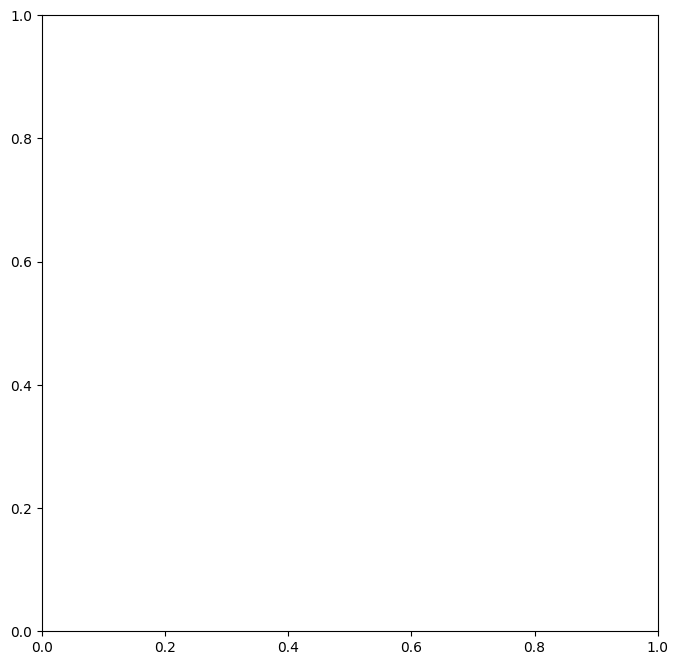

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import sys
from scipy import ndimage  # Make sure to import ndimage for `find_objects`
from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline
import os

# Helper function to plot images
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_aligned_coordinates(aligned_coords):
    plt.figure(figsize=(10, 8))
    
    # Reverse the order of aligned leads to match top-to-bottom ordering
    for i, coords in enumerate(reversed(aligned_coords)):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Lead {i+1}')
    
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.title('Aligned ECG Signal Leads')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


def apply_kmeans(image, n_clusters=2):
    Z = image.reshape((-1, 1))  # Flatten the image
    Z = np.float32(Z)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(Z, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape((image.shape))
    return segmented_image, centers

def create_binary_masks(segmented_image, n_clusters):
    binary_masks = [(segmented_image == i).astype(np.uint8) * 255 for i in range(n_clusters)]
    return binary_masks

def extract_contour_coordinates(binary_masks):
    contour_coordinates = []
    for mask in binary_masks:
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            coords = contour[:, 0, :]  # Extract x and y coordinates
            contour_coordinates.append(coords)
    return contour_coordinates

def calculate_gradient(coords):
    # Fit a linear regression to the x and y coordinates to find the slope (gradient)
    X = coords[:, 0].reshape(-1, 1)  # x-coordinates
    y = coords[:, 1]  # y-coordinates
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]  # The gradient of the line (dy/dx)
    return slope

def filter_and_merge_leads(contour_coords, min_size=1000, y_threshold=30, gradient_threshold=0.05):
    # Filter out small contours
    large_contours = [coords for coords in contour_coords if len(coords) > min_size]

    merged_leads = []
    current_lead = []
    
    for i, coords in enumerate(large_contours):
        if not current_lead:
            current_lead.append(coords)
            continue

        # Calculate the gradient for the current contour and the first contour in the current lead
        current_gradient = calculate_gradient(coords)
        lead_gradient = calculate_gradient(current_lead[0])

        # Check if the y-values are similar and gradients are similar enough to merge
        if (np.abs(coords[:, 1].mean() - current_lead[0][:, 1].mean()) < y_threshold and
            np.abs(current_gradient - lead_gradient) < gradient_threshold):
            current_lead.append(coords)
        else:
            # Merge the current lead
            merged_leads.append(np.vstack(current_lead))
            current_lead = [coords]

    # Add the last lead
    if current_lead:
        merged_leads.append(np.vstack(current_lead))

    return merged_leads


def enforce_only_leads(merged_coords, max_leads=6):
    """
    This function selects 6 leads that have consistent x ranges, ensuring that
    6 leads are always selected.
    
    Args:
    merged_coords: List of np.array coordinates of the leads.
    max_leads: The number of leads to select (default is 6).
    
    Returns:
    selected_coords: List of np.array coordinates of the selected leads.
    """
    
    # Calculate the x range for each lead
    lead_ranges = [
        (i, 
         coords[:, 0].max() - coords[:, 0].min()  # x range
        ) 
        for i, coords in enumerate(merged_coords)
    ]
    
    # Calculate the mean x range
    mean_x_range = np.mean([lead[1] for lead in lead_ranges])
    
    # Find the lead whose x range is closest to the mean x range
    initial_lead = min(lead_ranges, key=lambda x: abs(x[1] - mean_x_range))
    selected_leads = [initial_lead]  # Start with the lead closest to the mean
    
    # Sort the remaining leads by their proximity to the initial lead in x range
    remaining_leads = [
        lead for lead in lead_ranges if lead != initial_lead
    ]
    
    # Sort based on proximity in x range only
    remaining_leads.sort(
        key=lambda x: abs(x[1] - initial_lead[1])
    )
    
    # Select the top remaining leads based on x range proximity
    selected_leads += remaining_leads[:max_leads-1]  # Adding remaining leads to make 6 in total
    
    # Extract the indices of the selected leads
    selected_indices = [lead[0] for lead in selected_leads]
    
    # Return the selected leads while preserving the original order
    selected_coords = [merged_coords[i] for i in sorted(selected_indices)]
    
    return selected_coords
    
def plot_binary_masks(binary_masks):
    num_masks = len(binary_masks)
    cols = 3
    rows = (num_masks + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    plt.suptitle('Binary Masks')
    
    for i, mask in enumerate(binary_masks):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f'Mask {i+1}')
        axes[i].axis('off')

    for j in range(num_masks, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_merged_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Merged Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

    
def plot_final_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Final Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

def plot_lead_time_amplitude(time_amplitude_df):
    """
    Plots time vs amplitude for each lead in the time_amplitude_df DataFrame.
    
    :param time_amplitude_df: DataFrame containing time and amplitude columns for each lead.
    """
    num_leads = len([col for col in time_amplitude_df.columns if '_time' in col])
    
    plt.figure(figsize=(15, num_leads * 2))
    
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amplitude_col = f'Lead_{i}_amplitude'
        
        plt.subplot(num_leads, 1, i)  # Creates a subplot for each lead
        plt.plot(time_amplitude_df[time_col], time_amplitude_df[amplitude_col], label=f'Lead {i}')
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def align_leads(contour_coords, num_points=5000):
    aligned_coords = []
    for coords in contour_coords:
        x = coords[:, 0]
        y = coords[:, 1]

        # Remove duplicate x values to ensure CubicSpline works correctly
        unique_x, unique_indices = np.unique(x, return_index=True)
        unique_y = y[unique_indices]
        
        # Apply cubic spline interpolation
        cs = CubicSpline(unique_x, unique_y)
        
        # Generate new x values for interpolation
        x_new = np.linspace(unique_x.min(), unique_x.max(), num_points)
        y_new = cs(x_new)
        
        aligned_coords.append(np.column_stack((x_new, y_new)))
    return aligned_coords


def plot_time_amplitude_overlay(image_path, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y):
    """
    Plots the ECG leads overlaying on the original ECG image.

    :param image_path: The path to the original ECG image or the image matrix.
    :param time_amplitude_df: DataFrame containing the time and amplitude for each lead.
    :param pixels_per_mm_x: The pixel-to-mm conversion factor for the x-axis (time).
    :param pixels_per_mm_y: The pixel-to-mm conversion factor for the y-axis (amplitude).
    """

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Plot the original ECG image
    plt.imshow(image_path, cmap='gray')

    # Ensure consistency with the conversion factors used in image_to_sequence_1ms
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # 50 mm = 1 second, converted to ms
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    # Reverse the conversion factors for plotting
    pixel_per_time = 1 / time_per_pixel
    pixel_per_amplitude = 1 / amplitude_per_pixel

    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    # Overlay each lead present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'
        
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            # Convert time and amplitude back to pixel coordinates
            x_pixels = time_amplitude_df[time_col] * pixel_per_time
            y_pixels = time_amplitude_df[amp_col] * pixel_per_amplitude

            plt.plot(x_pixels, y_pixels, label=f'Lead {i}', linewidth=2)  # Plot each lead
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.title('Overlay of Extracted ECG Leads on Original Image')
    plt.xlabel('Time (pixels)')
    plt.ylabel('Amplitude (pixels)')
    plt.legend()
    plt.axis('off')  # Hide axis since we're overlaying on an image
    plt.show()


def image_to_sequence_1ms(contour_coords, pixels_per_mm_x, pixels_per_mm_y):
    """
    Converts the contour coordinates into time-amplitude sequences using pixel-to-time and pixel-to-amplitude conversions.
    Enforces 1 ms time steps by interpolation.
    
    :param contour_coords: A list of contour coordinates (x, y).
    :param pixels_per_mm_x: The conversion factor from pixels to mm for the x-axis (time).
    :param pixels_per_mm_y: The conversion factor from pixels to mm for the y-axis (amplitude).
    :return: DataFrame containing time and amplitude for each lead with 1 ms time steps.
    """
    lead_data = {}

    # Conversion factors
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # Convert to milliseconds
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    num_leads = len(contour_coords)

    # Find the minimum and maximum time across all leads
    all_time_values = []
    for coords in contour_coords:
        time_values = coords[:, 0] * time_per_pixel
        all_time_values.extend(time_values)
    
    min_time = min(all_time_values)
    max_time = max(all_time_values)

    # Create a common uniformly spaced time array for all leads
    uniform_time_values = np.arange(min_time, max_time, 1)  # 1 ms step

    for i, coords in enumerate(contour_coords):
        # Reverse the lead numbering
        lead_number = num_leads - i
        
        # Original time and amplitude values
        original_time_values = coords[:, 0] * time_per_pixel  # Convert x-coordinates to time in ms
        original_amplitude_values = coords[:, 1] * amplitude_per_pixel  # Convert y-coordinates to amplitude in mV
        
        # Interpolate amplitude values to fit the uniform time grid
        interp_func = interp1d(original_time_values, original_amplitude_values, kind='linear', fill_value="extrapolate")
        interpolated_amplitude_values = interp_func(uniform_time_values)
        
        # Save the uniformly spaced time and interpolated amplitude values
        lead_data[f'Lead_{lead_number}_time'] = uniform_time_values
        lead_data[f'Lead_{lead_number}_amplitude'] = interpolated_amplitude_values

    return pd.DataFrame(lead_data)



def process_ecg_image(image_path, output_csv_folder, output_plot_folder, padding_size=100):
    # Step 1: Load the image
    image = cv.imread(image_path)
    if image is None:
        print('Cannot open image: ' + image_path)
        sys.exit(0)

    # Convert the image to a custom Image class
    img_obj = CustomImage(image)

    # Initialize Preprocessor
    preprocessor = Preprocessor()

    # Apply preprocessing
    preprocessed_img_obj, rect = preprocessor.preprocess(img_obj)
    
    # Convert the preprocessed image back to numpy array
    preprocessed_image = preprocessed_img_obj.array

    # Add padding to the left and right of the preprocessed image
    padded_image = cv.copyMakeBorder(
        preprocessed_image, 
        top=0, bottom=0, left=padding_size, right=padding_size, 
        borderType=cv.BORDER_CONSTANT, value=255  # Assuming the background is white (255)
    )
    
    # Apply kmeans segmentation on the padded image
    segmented_image, centers = apply_kmeans(padded_image, n_clusters=2)

    # Create binary masks and extract contours
    binary_masks = create_binary_masks(segmented_image, n_clusters=2)
    
    contour_coords = extract_contour_coordinates(binary_masks)
    
    # Filter, merge, and align leads
    merged_leads = filter_and_merge_leads(contour_coords)

    # Only pull leads
    final_leads = enforce_only_leads(merged_leads)

    # Align leads and sort them from top to bottom
    aligned_leads = align_leads(final_leads, num_points=5000)

    pixels_per_mm_x = 11.81
    pixels_per_mm_y = 11.81
    time_amplitude_df = image_to_sequence_1ms(aligned_leads, pixels_per_mm_x, pixels_per_mm_y)

    # Create output paths
    base_name = os.path.basename(image_path).replace('.png', '')
    output_csv_path = os.path.join(output_csv_folder, f"{base_name}.csv")
    output_plot_path = os.path.join(output_plot_folder, f"{base_name}.png")

    # Save DataFrame to CSV
    time_amplitude_df.to_csv(output_csv_path, index=False)
    print(f"Time and amplitude values have been saved to {output_csv_path}")

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Plot the original ECG image
    plt.imshow(padded_image, cmap='gray')

    # Ensure consistency with the conversion factors used in image_to_sequence_1ms
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # 50 mm = 1 second, converted to ms
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    # Reverse the conversion factors for plotting
    pixel_per_time = 1 / time_per_pixel
    pixel_per_amplitude = 1 / amplitude_per_pixel

    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    # Overlay each lead present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'
        
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            # Convert time and amplitude back to pixel coordinates
            x_pixels = time_amplitude_df[time_col] * pixel_per_time
            y_pixels = time_amplitude_df[amp_col] * pixel_per_amplitude

            plt.plot(x_pixels, y_pixels, label=f'Lead {i}', linewidth=2)  # Plot each lead
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.title('Overlay of Extracted ECG Leads on Original Image')
    plt.xlabel('Time (pixels)')
    plt.ylabel('Amplitude (pixels)')
    plt.legend()
    plt.axis('off')  # Hide axis since we're overlaying on an image
    plt.savefig(output_plot_path)
    plt.close()

    return aligned_leads, time_amplitude_df

# Main folder processing function
def process_ecg_folder(input_folder, output_csv_folder, output_plot_folder):
    if not os.path.exists(output_csv_folder):
        os.makedirs(output_csv_folder)
    if not os.path.exists(output_plot_folder):
        os.makedirs(output_plot_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            image_path = os.path.join(input_folder, filename)
            process_ecg_image(image_path, output_csv_folder, output_plot_folder)

# Example usage

# Define paths for input and output directories
input_folder = '../rotated_data_png'
output_csv_folder = 'digitized_coordinates'
output_plot_folder = 'digitized_plots'

# Ensure output directories exist
os.makedirs(output_csv_folder, exist_ok=True)
os.makedirs(output_plot_folder, exist_ok=True)
process_ecg_folder(input_folder, output_csv_folder, output_plot_folder)


## Single file test 2

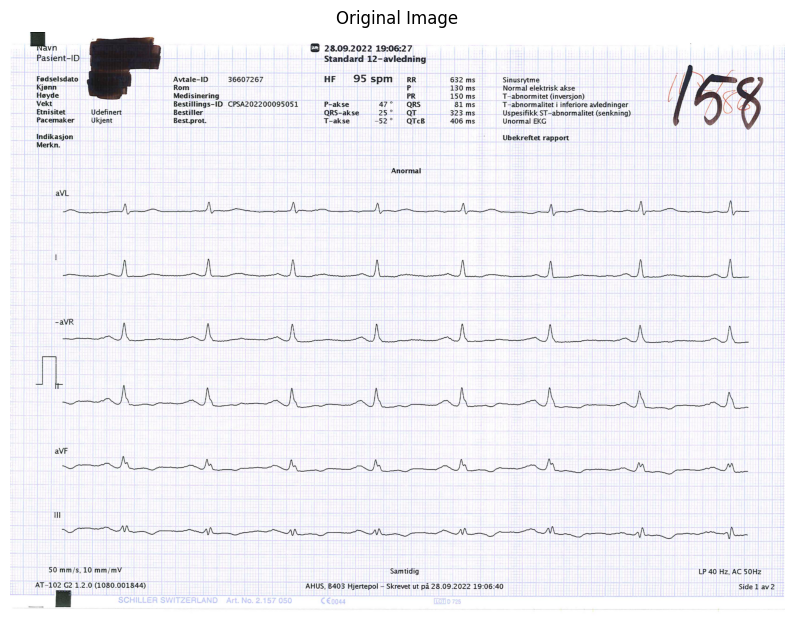

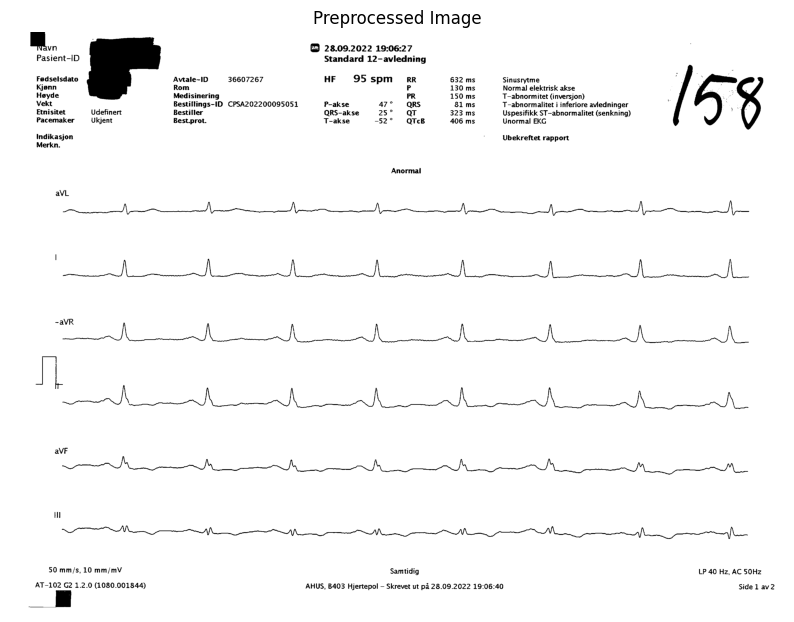

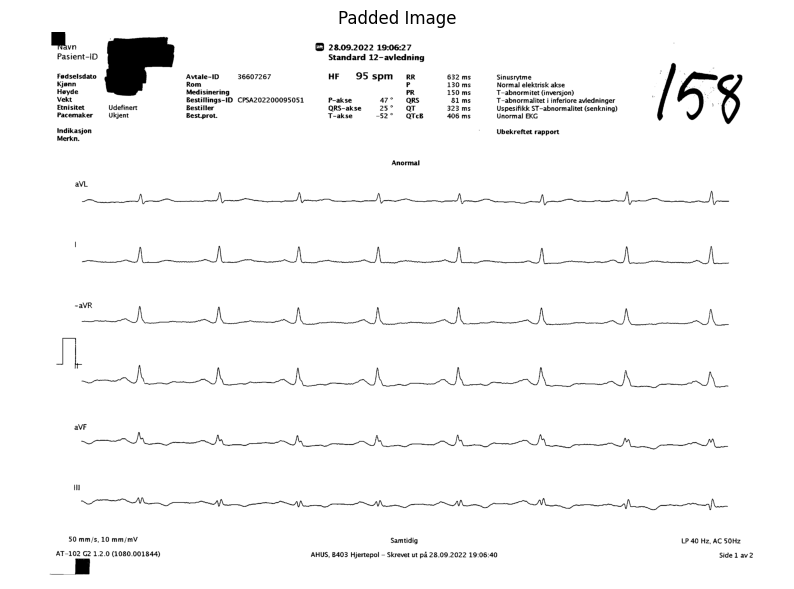

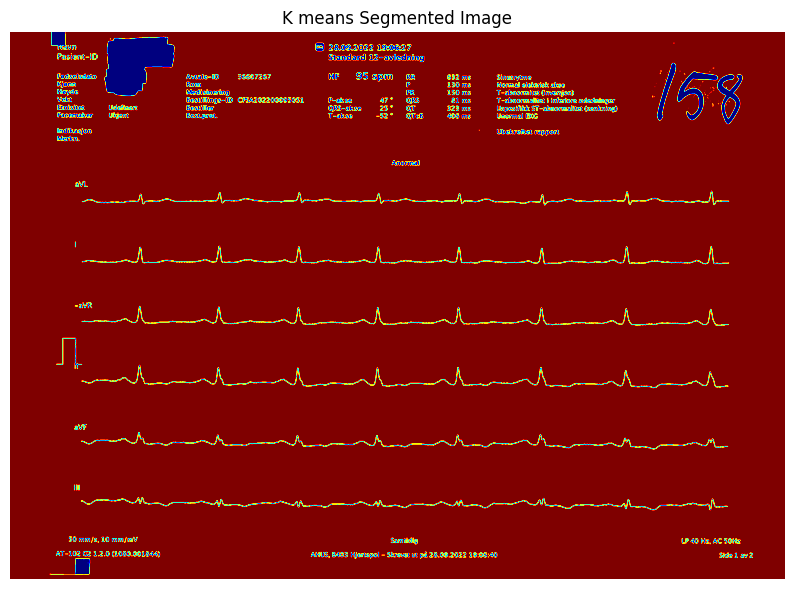

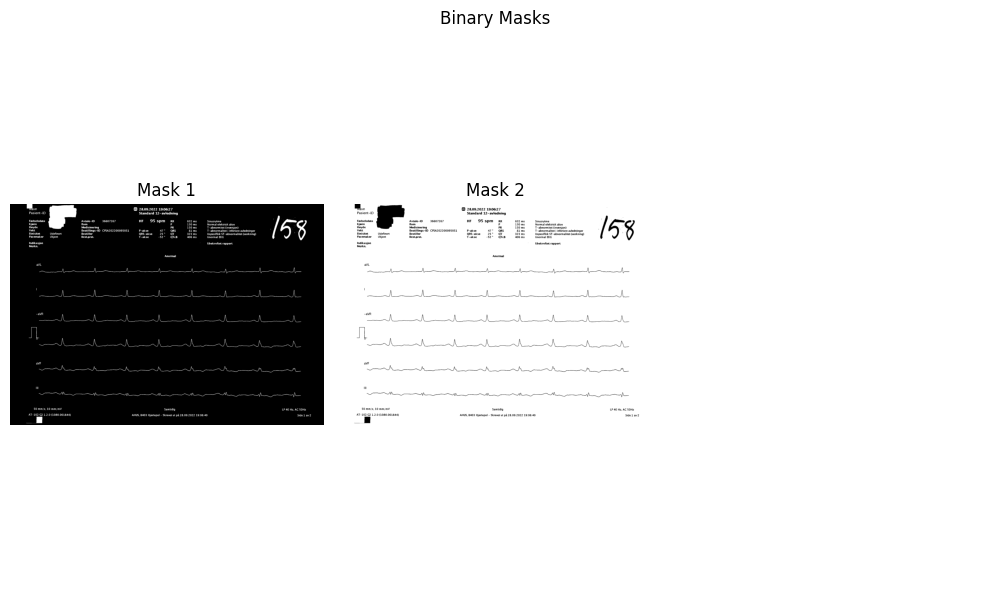

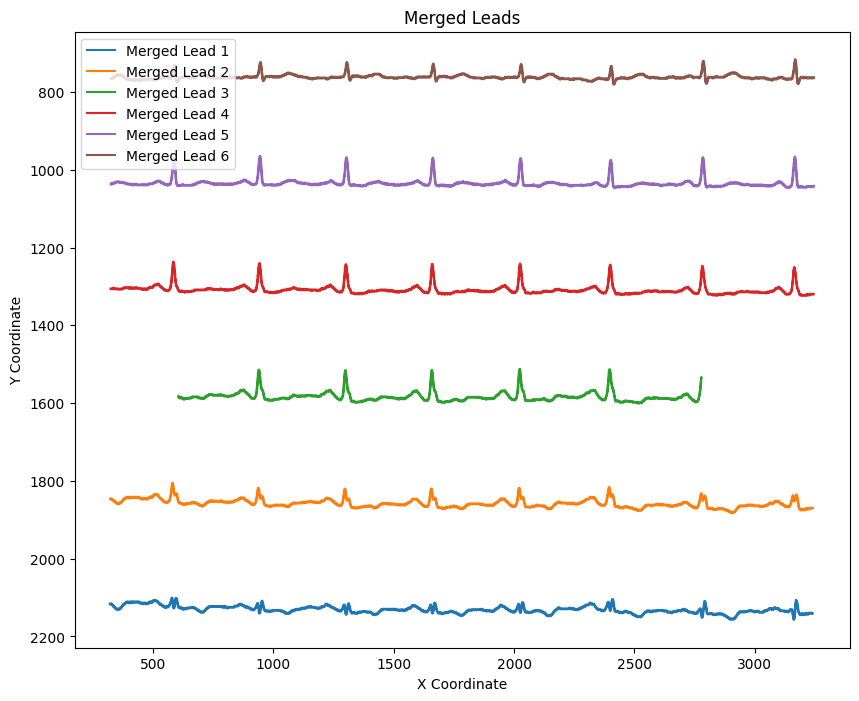

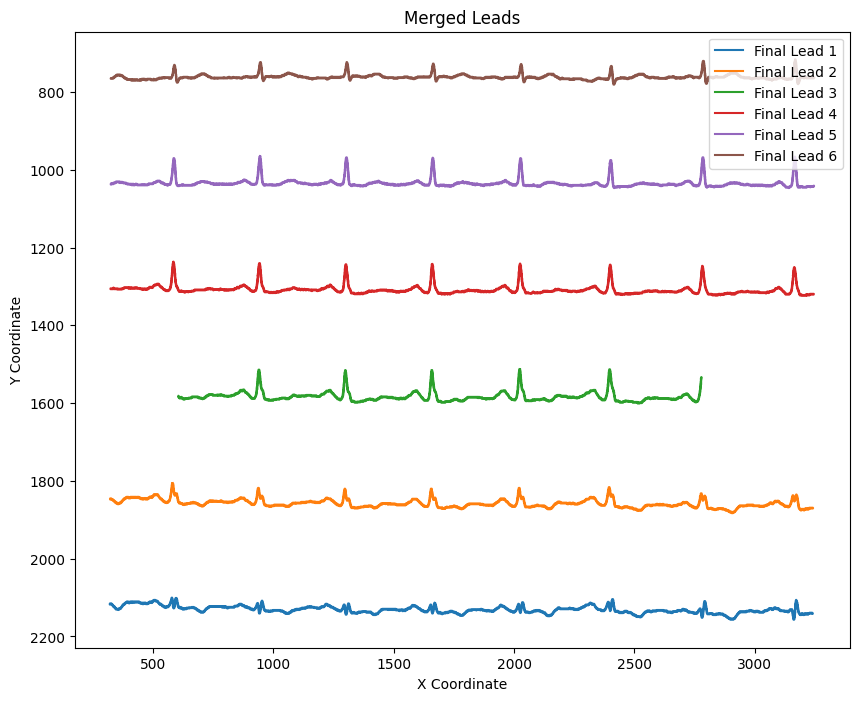

d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


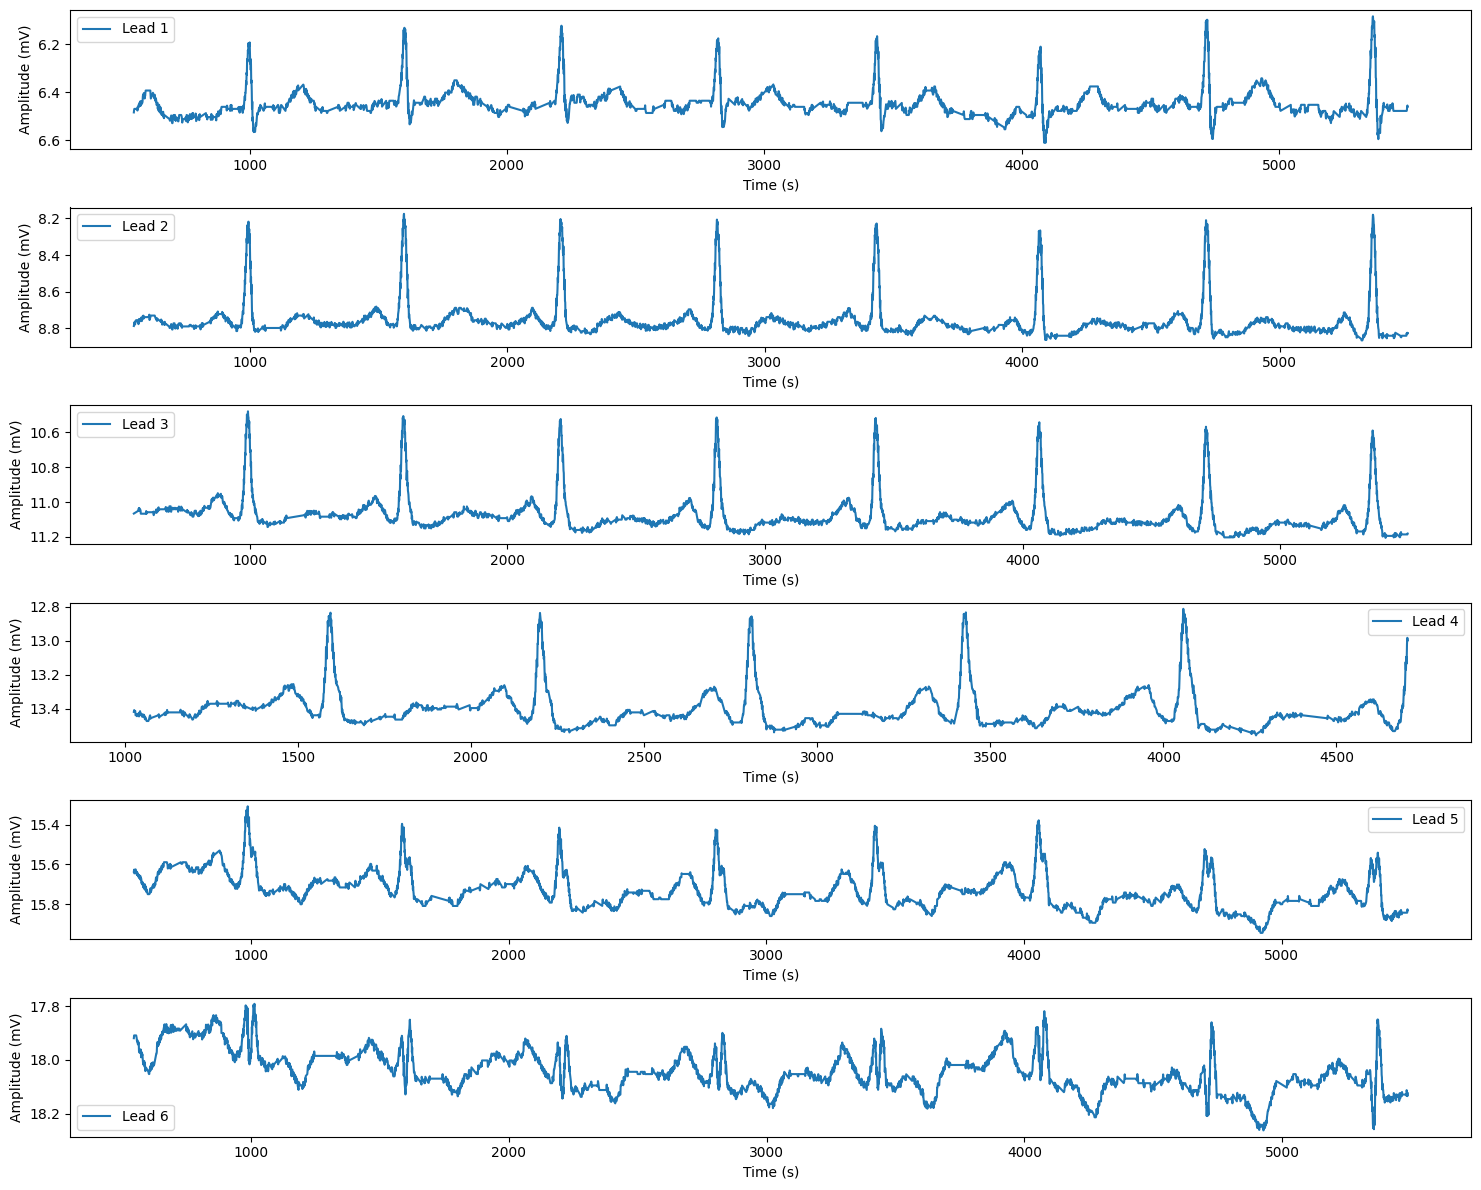

      Lead_6_time  Lead_6_amplitude  Lead_5_time  Lead_5_amplitude  \
0      543.607113               NaN   543.607113               NaN   
1      544.607113         17.918954   544.607113               NaN   
2      545.607113         17.908552   545.607113         15.636224   
3      546.607113         17.908552   546.607113         15.626224   
4      547.607113         17.908552   547.607113         15.644691   
...           ...               ...          ...               ...   
4951  5494.607113               NaN  5494.607113               NaN   
4952  5495.607113               NaN  5495.607113               NaN   
4953  5496.607113               NaN  5496.607113               NaN   
4954  5497.607113               NaN  5497.607113               NaN   
4955  5498.607113               NaN  5498.607113               NaN   

      Lead_4_time  Lead_4_amplitude  Lead_3_time  Lead_3_amplitude  \
0      543.607113               NaN   543.607113               NaN   
1      544.607113  

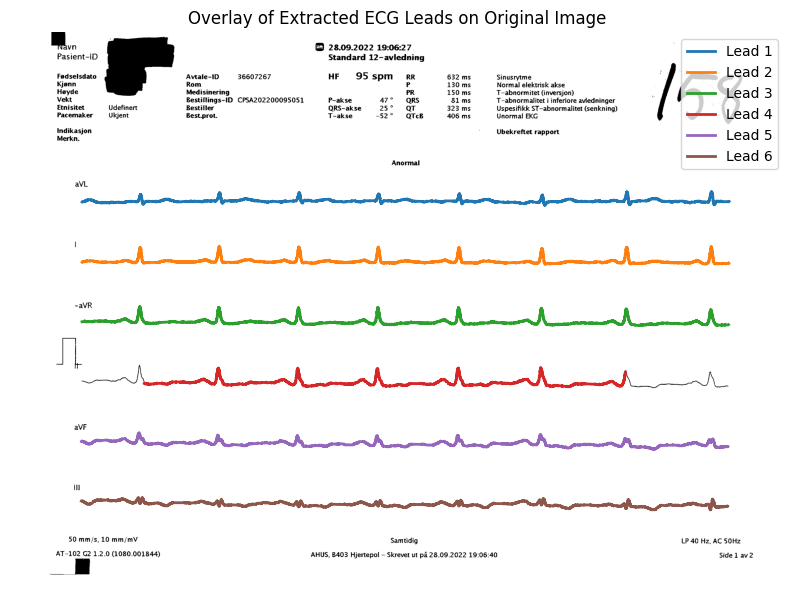

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import sys
from scipy import ndimage  # Make sure to import ndimage for `find_objects`
from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline

# Helper function to plot images
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_aligned_coordinates(aligned_coords):
    plt.figure(figsize=(10, 8))
    
    # Reverse the order of aligned leads to match top-to-bottom ordering
    for i, coords in enumerate(reversed(aligned_coords)):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Lead {i+1}')
    
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.title('Aligned ECG Signal Leads')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


def apply_kmeans(image, n_clusters=2):
    Z = image.reshape((-1, 1))  # Flatten the image
    Z = np.float32(Z)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(Z, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape((image.shape))
    return segmented_image, centers

def create_binary_masks(segmented_image, n_clusters):
    binary_masks = [(segmented_image == i).astype(np.uint8) * 255 for i in range(n_clusters)]
    return binary_masks

def extract_contour_coordinates(binary_masks):
    contour_coordinates = []
    for mask in binary_masks:
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            coords = contour[:, 0, :]  # Extract x and y coordinates
            contour_coordinates.append(coords)
    return contour_coordinates

def calculate_gradient(coords):
    # Fit a linear regression to the x and y coordinates to find the slope (gradient)
    X = coords[:, 0].reshape(-1, 1)  # x-coordinates
    y = coords[:, 1]  # y-coordinates
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]  # The gradient of the line (dy/dx)
    return slope

def filter_and_merge_leads(contour_coords, min_size=1000, y_threshold=30, gradient_threshold=0.05):
    # Filter out small contours
    large_contours = [coords for coords in contour_coords if len(coords) > min_size]

    merged_leads = []
    current_lead = []
    
    for i, coords in enumerate(large_contours):
        if not current_lead:
            current_lead.append(coords)
            continue

        # Calculate the gradient for the current contour and the first contour in the current lead
        current_gradient = calculate_gradient(coords)
        lead_gradient = calculate_gradient(current_lead[0])

        # Check if the y-values are similar and gradients are similar enough to merge
        if (np.abs(coords[:, 1].mean() - current_lead[0][:, 1].mean()) < y_threshold and
            np.abs(current_gradient - lead_gradient) < gradient_threshold):
            current_lead.append(coords)
        else:
            # Merge the current lead
            merged_leads.append(np.vstack(current_lead))
            current_lead = [coords]

    # Add the last lead
    if current_lead:
        merged_leads.append(np.vstack(current_lead))

    return merged_leads


def enforce_only_leads(merged_coords, max_leads=6):
    """
    This function selects 6 leads that have consistent x ranges, ensuring that
    6 leads are always selected.
    
    Args:
    merged_coords: List of np.array coordinates of the leads.
    max_leads: The number of leads to select (default is 6).
    
    Returns:
    selected_coords: List of np.array coordinates of the selected leads.
    """
    
    # Calculate the x range for each lead
    lead_ranges = [
        (i, 
         coords[:, 0].max() - coords[:, 0].min()  # x range
        ) 
        for i, coords in enumerate(merged_coords)
    ]
    
    # Calculate the mean x range
    mean_x_range = np.mean([lead[1] for lead in lead_ranges])
    
    # Find the lead whose x range is closest to the mean x range
    initial_lead = min(lead_ranges, key=lambda x: abs(x[1] - mean_x_range))
    selected_leads = [initial_lead]  # Start with the lead closest to the mean
    
    # Sort the remaining leads by their proximity to the initial lead in x range
    remaining_leads = [
        lead for lead in lead_ranges if lead != initial_lead
    ]
    
    # Sort based on proximity in x range only
    remaining_leads.sort(
        key=lambda x: abs(x[1] - initial_lead[1])
    )
    
    # Select the top remaining leads based on x range proximity
    selected_leads += remaining_leads[:max_leads-1]  # Adding remaining leads to make 6 in total
    
    # Extract the indices of the selected leads
    selected_indices = [lead[0] for lead in selected_leads]
    
    # Return the selected leads while preserving the original order
    selected_coords = [merged_coords[i] for i in sorted(selected_indices)]
    
    return selected_coords
    
def plot_binary_masks(binary_masks):
    num_masks = len(binary_masks)
    cols = 3
    rows = (num_masks + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    plt.suptitle('Binary Masks')
    
    for i, mask in enumerate(binary_masks):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f'Mask {i+1}')
        axes[i].axis('off')

    for j in range(num_masks, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_merged_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Merged Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

    
def plot_final_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Final Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

def plot_lead_time_amplitude(time_amplitude_df):
    """
    Plots time vs amplitude for each lead in the time_amplitude_df DataFrame.
    
    :param time_amplitude_df: DataFrame containing time and amplitude columns for each lead.
    """
    num_leads = len([col for col in time_amplitude_df.columns if '_time' in col])
    
    plt.figure(figsize=(15, num_leads * 2))
    
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amplitude_col = f'Lead_{i}_amplitude'
        
        plt.subplot(num_leads, 1, i)  # Creates a subplot for each lead
        plt.plot(time_amplitude_df[time_col], time_amplitude_df[amplitude_col], label=f'Lead {i}')
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def align_leads(contour_coords, num_points=5000):
    aligned_coords = []
    for coords in contour_coords:
        x = coords[:, 0]
        y = coords[:, 1]

        # Remove duplicate x values to ensure CubicSpline works correctly
        unique_x, unique_indices = np.unique(x, return_index=True)
        unique_y = y[unique_indices]
        
        # Apply cubic spline interpolation
        cs = CubicSpline(unique_x, unique_y)
        
        # Generate new x values for interpolation
        x_new = np.linspace(unique_x.min(), unique_x.max(), num_points)
        y_new = cs(x_new)
        
        aligned_coords.append(np.column_stack((x_new, y_new)))
    return aligned_coords


def plot_time_amplitude_overlay(image_path, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y):
    """
    Plots the ECG leads overlaying on the original ECG image.

    :param image_path: The path to the original ECG image or the image matrix.
    :param time_amplitude_df: DataFrame containing the time and amplitude for each lead.
    :param pixels_per_mm_x: The pixel-to-mm conversion factor for the x-axis (time).
    :param pixels_per_mm_y: The pixel-to-mm conversion factor for the y-axis (amplitude).
    """

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Plot the original ECG image
    plt.imshow(image_path, cmap='gray')

    # Ensure consistency with the conversion factors used in image_to_sequence_1ms
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # 50 mm = 1 second, converted to ms
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    # Reverse the conversion factors for plotting
    pixel_per_time = 1 / time_per_pixel
    pixel_per_amplitude = 1 / amplitude_per_pixel

    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    # Overlay each lead present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'
        
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            # Convert time and amplitude back to pixel coordinates
            x_pixels = time_amplitude_df[time_col] * pixel_per_time
            y_pixels = time_amplitude_df[amp_col] * pixel_per_amplitude

            plt.plot(x_pixels, y_pixels, label=f'Lead {i}', linewidth=2)  # Plot each lead
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.title('Overlay of Extracted ECG Leads on Original Image')
    plt.xlabel('Time (pixels)')
    plt.ylabel('Amplitude (pixels)')
    plt.legend()
    plt.axis('off')  # Hide axis since we're overlaying on an image
    plt.show()


# def image_to_sequence_1ms(contour_coords, pixels_per_mm_x, pixels_per_mm_y):
#     """
#     Converts the contour coordinates into time-amplitude sequences using pixel-to-time and pixel-to-amplitude conversions.
#     Enforces 1 ms time steps by interpolation.
    
#     :param contour_coords: A list of contour coordinates (x, y).
#     :param pixels_per_mm_x: The conversion factor from pixels to mm for the x-axis (time).
#     :param pixels_per_mm_y: The conversion factor from pixels to mm for the y-axis (amplitude).
#     :return: DataFrame containing time and amplitude for each lead with 1 ms time steps.
#     """
#     lead_data = {}

#     # Conversion factors
#     time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # Convert to milliseconds
#     amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

#     num_leads = len(contour_coords)

#     # Find the minimum and maximum time across all leads
#     all_time_values = []
#     for coords in contour_coords:
#         time_values = coords[:, 0] * time_per_pixel
#         all_time_values.extend(time_values)
    
#     min_time = min(all_time_values)
#     max_time = max(all_time_values)

#     # Create a common uniformly spaced time array for all leads
#     uniform_time_values = np.arange(min_time, max_time, 1)  # 1 ms step

#     for i, coords in enumerate(contour_coords):
#         # Reverse the lead numbering
#         lead_number = num_leads - i
        
#         # Original time and amplitude values
#         original_time_values = coords[:, 0] * time_per_pixel  # Convert x-coordinates to time in ms
#         original_amplitude_values = coords[:, 1] * amplitude_per_pixel  # Convert y-coordinates to amplitude in mV
        
#         # Interpolate amplitude values to fit the uniform time grid
#         interp_func = interp1d(original_time_values, original_amplitude_values, kind='linear', fill_value="extrapolate")
#         interpolated_amplitude_values = interp_func(uniform_time_values)
        
#         # Save the uniformly spaced time and interpolated amplitude values
#         lead_data[f'Lead_{lead_number}_time'] = uniform_time_values
#         lead_data[f'Lead_{lead_number}_amplitude'] = interpolated_amplitude_values

#     return pd.DataFrame(lead_data)

def image_to_sequence_1ms(contour_coords, pixels_per_mm_x, pixels_per_mm_y):
    """
    Converts the contour coordinates into time-amplitude sequences using pixel-to-time and pixel-to-amplitude conversions.
    Enforces 1 ms time steps by interpolation.
    
    :param contour_coords: A list of contour coordinates (x, y).
    :param pixels_per_mm_x: The conversion factor from pixels to mm for the x-axis (time).
    :param pixels_per_mm_y: The conversion factor from pixels to mm for the y-axis (amplitude).
    :return: DataFrame containing time and amplitude for each lead with 1 ms time steps.
    """
    lead_data = {}

    # Conversion factors
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # Convert to milliseconds
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    num_leads = len(contour_coords)

    # Find the minimum and maximum time across all leads
    all_time_values = []
    for coords in contour_coords:
        time_values = coords[:, 0] * time_per_pixel
        all_time_values.extend(time_values)
    
    min_time = min(all_time_values)
    max_time = max(all_time_values)

    # Create a common uniformly spaced time array for all leads
    uniform_time_values = np.arange(min_time, max_time, 1)  # 1 ms step

    for i, coords in enumerate(contour_coords):
        # Reverse the lead numbering
        lead_number = num_leads - i
        
        # Original time and amplitude values
        original_time_values = coords[:, 0] * time_per_pixel  # Convert x-coordinates to time in ms
        original_amplitude_values = coords[:, 1] * amplitude_per_pixel  # Convert y-coordinates to amplitude in mV
        
        # Interpolate amplitude values to fit the uniform time grid
        interp_func = interp1d(original_time_values, original_amplitude_values, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Ensure you do not extrapolate beyond the original time range
        valid_indices = (uniform_time_values >= original_time_values.min()) & (uniform_time_values <= original_time_values.max())
        interpolated_amplitude_values = np.full_like(uniform_time_values, np.nan)  # Initialize with NaN
        interpolated_amplitude_values[valid_indices] = interp_func(uniform_time_values[valid_indices])
        
        # Save the uniformly spaced time and interpolated amplitude values
        lead_data[f'Lead_{lead_number}_time'] = uniform_time_values
        lead_data[f'Lead_{lead_number}_amplitude'] = interpolated_amplitude_values

    return pd.DataFrame(lead_data)



def resample_contour(contour, num_points=100):
    x = contour[:, 0]
    y = contour[:, 1]
    f_interp = interp1d(np.arange(len(x)), x, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(0, len(x) - 1, num_points)
    x_resampled = f_interp(x_new)
    f_interp = interp1d(np.arange(len(y)), y, kind='linear', fill_value="extrapolate")
    y_resampled = f_interp(x_new)
    return np.column_stack((x_resampled, y_resampled))

def compare_gradients(contour1, contour2, threshold=0.5, num_points=100):
    # Resample contours
    contour1_resampled = resample_contour(contour1, num_points)
    contour2_resampled = resample_contour(contour2, num_points)
    
    # Calculate gradients for each contour
    gradient1 = np.diff(contour1_resampled, axis=0)
    gradient2 = np.diff(contour2_resampled, axis=0)

    # Calculate mean squared difference between gradients
    mse = np.mean((gradient1 - gradient2) ** 2, axis=0)

    # Return True if all MSE values are below the threshold
    return np.all(mse < threshold)

def enforce_six_leads_by_start_points(merged_coords):
    if len(merged_coords) <= 6:
        return merged_coords

    # Sort by x-axis range to select top 6 leads
    lead_ranges = [(i, coords[:, 0].max() - coords[:, 0].min()) for i, coords in enumerate(merged_coords)]
    lead_ranges.sort(key=lambda x: x[1], reverse=True)

    # Select top 6 leads
    selected_leads = [merged_coords[i] for i, _ in lead_ranges[:6]]
    
    return selected_leads

# Main processing function
def process_ecg_image(image_path, padding_size=100):
    # Step 1: Load the image
    image = cv.imread(image_path)
    if image is None:
        print('Cannot open image: ' + image_path)
        sys.exit(0)

    plot_image(image, 'Original Image')

    # Convert the image to a custom Image class
    img_obj = CustomImage(image)

    # Initialize Preprocessor
    preprocessor = Preprocessor()

    # Apply preprocessing
    preprocessed_img_obj, rect = preprocessor.preprocess(img_obj)
    
    # Convert the preprocessed image back to numpy array
    preprocessed_image = preprocessed_img_obj.array

    # Plot the preprocessed image
    plot_image(preprocessed_image, 'Preprocessed Image')

    # Add padding to the left and right of the preprocessed image
    padded_image = cv.copyMakeBorder(
        preprocessed_image, 
        top=0, bottom=0, left=padding_size, right=padding_size, 
        borderType=cv.BORDER_CONSTANT, value=255  # Assuming the background is white (255)
    )
    
    # Plot the padded image
    plot_image(padded_image, 'Padded Image')
    
    # Apply kmeans segmentation on the padded image
    segmented_image, centers = apply_kmeans(padded_image, n_clusters=2)
    plot_image(segmented_image, "K means Segmented Image", cmap='jet')

    # Create binary masks and extract contours
    binary_masks = create_binary_masks(segmented_image, n_clusters=2)
    plot_binary_masks(binary_masks)  # Plot binary masks
    
    contour_coords = extract_contour_coordinates(binary_masks)    

    # Filter and merge leads
    filtered_and_merged_leads = filter_and_merge_leads(contour_coords, min_size=1000)
    plot_merged_leads(filtered_and_merged_leads)  # Plot merged leads

    # Ensure exactly 6 leads
    final_coords = enforce_six_leads_by_start_points(filtered_and_merged_leads)
    plot_final_leads(final_coords)  # Plot merged leads

    # Example usage with calculated pixel scaling factors
    pixels_per_mm_x = 11.81
    pixels_per_mm_y = 11.81

    # Extract time and amplitude values for each lead (sequence extraction)
    time_amplitude_df = image_to_sequence_1ms(final_coords, pixels_per_mm_x, pixels_per_mm_y)
    # Assuming time_amplitude_df is already created from image_to_sequence function
    plot_lead_time_amplitude(time_amplitude_df)
    print(time_amplitude_df)

    output_csv_path = 'ecg_time_amplitude.csv'
    time_amplitude_df.to_csv(output_csv_path, index=False)
    print(f"Time and amplitude values have been saved to {output_csv_path}")
    # Plot with ovberlay
    plot_time_amplitude_overlay(padded_image, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y)

    return time_amplitude_df

# Example usage
image_path = r'../rotated_data_png/158_F_page_1.png'
time_amplitude_df = process_ecg_image(image_path)




## All files test 2

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import sys
from scipy import ndimage  # Make sure to import ndimage for `find_objects`
from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline
import os

# Helper function to plot images
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_aligned_coordinates(aligned_coords):
    plt.figure(figsize=(10, 8))
    
    # Reverse the order of aligned leads to match top-to-bottom ordering
    for i, coords in enumerate(reversed(aligned_coords)):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Lead {i+1}')
    
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.title('Aligned ECG Signal Leads')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


def apply_kmeans(image, n_clusters=2):
    Z = image.reshape((-1, 1))  # Flatten the image
    Z = np.float32(Z)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(Z, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape((image.shape))
    return segmented_image, centers

def create_binary_masks(segmented_image, n_clusters):
    binary_masks = [(segmented_image == i).astype(np.uint8) * 255 for i in range(n_clusters)]
    return binary_masks

def extract_contour_coordinates(binary_masks):
    contour_coordinates = []
    for mask in binary_masks:
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            coords = contour[:, 0, :]  # Extract x and y coordinates
            contour_coordinates.append(coords)
    return contour_coordinates

def calculate_gradient(coords):
    # Fit a linear regression to the x and y coordinates to find the slope (gradient)
    X = coords[:, 0].reshape(-1, 1)  # x-coordinates
    y = coords[:, 1]  # y-coordinates
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]  # The gradient of the line (dy/dx)
    return slope

def filter_and_merge_leads(contour_coords, min_size=1000, y_threshold=30, gradient_threshold=0.05):
    # Filter out small contours
    large_contours = [coords for coords in contour_coords if len(coords) > min_size]

    merged_leads = []
    current_lead = []
    
    for i, coords in enumerate(large_contours):
        if not current_lead:
            current_lead.append(coords)
            continue

        # Calculate the gradient for the current contour and the first contour in the current lead
        current_gradient = calculate_gradient(coords)
        lead_gradient = calculate_gradient(current_lead[0])

        # Check if the y-values are similar and gradients are similar enough to merge
        if (np.abs(coords[:, 1].mean() - current_lead[0][:, 1].mean()) < y_threshold and
            np.abs(current_gradient - lead_gradient) < gradient_threshold):
            current_lead.append(coords)
        else:
            # Merge the current lead
            merged_leads.append(np.vstack(current_lead))
            current_lead = [coords]

    # Add the last lead
    if current_lead:
        merged_leads.append(np.vstack(current_lead))

    return merged_leads


def enforce_only_leads(merged_coords, max_leads=6):
    """
    This function selects 6 leads that have consistent x ranges, ensuring that
    6 leads are always selected.
    
    Args:
    merged_coords: List of np.array coordinates of the leads.
    max_leads: The number of leads to select (default is 6).
    
    Returns:
    selected_coords: List of np.array coordinates of the selected leads.
    """
    
    # Calculate the x range for each lead
    lead_ranges = [
        (i, 
         coords[:, 0].max() - coords[:, 0].min()  # x range
        ) 
        for i, coords in enumerate(merged_coords)
    ]
    
    # Calculate the mean x range
    mean_x_range = np.mean([lead[1] for lead in lead_ranges])
    
    # Find the lead whose x range is closest to the mean x range
    initial_lead = min(lead_ranges, key=lambda x: abs(x[1] - mean_x_range))
    selected_leads = [initial_lead]  # Start with the lead closest to the mean
    
    # Sort the remaining leads by their proximity to the initial lead in x range
    remaining_leads = [
        lead for lead in lead_ranges if lead != initial_lead
    ]
    
    # Sort based on proximity in x range only
    remaining_leads.sort(
        key=lambda x: abs(x[1] - initial_lead[1])
    )
    
    # Select the top remaining leads based on x range proximity
    selected_leads += remaining_leads[:max_leads-1]  # Adding remaining leads to make 6 in total
    
    # Extract the indices of the selected leads
    selected_indices = [lead[0] for lead in selected_leads]
    
    # Return the selected leads while preserving the original order
    selected_coords = [merged_coords[i] for i in sorted(selected_indices)]
    
    return selected_coords
    
def plot_binary_masks(binary_masks):
    num_masks = len(binary_masks)
    cols = 3
    rows = (num_masks + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    plt.suptitle('Binary Masks')
    
    for i, mask in enumerate(binary_masks):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f'Mask {i+1}')
        axes[i].axis('off')

    for j in range(num_masks, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_merged_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Merged Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

    
def plot_final_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Final Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

def plot_lead_time_amplitude(time_amplitude_df):
    """
    Plots time vs amplitude for each lead in the time_amplitude_df DataFrame.
    
    :param time_amplitude_df: DataFrame containing time and amplitude columns for each lead.
    """
    num_leads = len([col for col in time_amplitude_df.columns if '_time' in col])
    
    plt.figure(figsize=(15, num_leads * 2))
    
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amplitude_col = f'Lead_{i}_amplitude'
        
        plt.subplot(num_leads, 1, i)  # Creates a subplot for each lead
        plt.plot(time_amplitude_df[time_col], time_amplitude_df[amplitude_col], label=f'Lead {i}')
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def align_leads(contour_coords, num_points=5000):
    aligned_coords = []
    for coords in contour_coords:
        x = coords[:, 0]
        y = coords[:, 1]

        # Remove duplicate x values to ensure CubicSpline works correctly
        unique_x, unique_indices = np.unique(x, return_index=True)
        unique_y = y[unique_indices]
        
        # Apply cubic spline interpolation
        cs = CubicSpline(unique_x, unique_y)
        
        # Generate new x values for interpolation
        x_new = np.linspace(unique_x.min(), unique_x.max(), num_points)
        y_new = cs(x_new)
        
        aligned_coords.append(np.column_stack((x_new, y_new)))
    return aligned_coords


def plot_time_amplitude_overlay(image_path, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y):
    """
    Plots the ECG leads overlaying on the original ECG image.

    :param image_path: The path to the original ECG image or the image matrix.
    :param time_amplitude_df: DataFrame containing the time and amplitude for each lead.
    :param pixels_per_mm_x: The pixel-to-mm conversion factor for the x-axis (time).
    :param pixels_per_mm_y: The pixel-to-mm conversion factor for the y-axis (amplitude).
    """

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Plot the original ECG image
    plt.imshow(image_path, cmap='gray')

    # Ensure consistency with the conversion factors used in image_to_sequence_1ms
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # 50 mm = 1 second, converted to ms
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    # Reverse the conversion factors for plotting
    pixel_per_time = 1 / time_per_pixel
    pixel_per_amplitude = 1 / amplitude_per_pixel

    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    # Overlay each lead present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'
        
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            # Convert time and amplitude back to pixel coordinates
            x_pixels = time_amplitude_df[time_col] * pixel_per_time
            y_pixels = time_amplitude_df[amp_col] * pixel_per_amplitude

            plt.plot(x_pixels, y_pixels, label=f'Lead {i}', linewidth=2)  # Plot each lead
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.title('Overlay of Extracted ECG Leads on Original Image')
    plt.xlabel('Time (pixels)')
    plt.ylabel('Amplitude (pixels)')
    plt.legend()
    plt.axis('off')  # Hide axis since we're overlaying on an image
    plt.show()



def image_to_sequence_1ms(contour_coords, pixels_per_mm_x, pixels_per_mm_y):
    """
    Converts the contour coordinates into time-amplitude sequences using pixel-to-time and pixel-to-amplitude conversions.
    Enforces 1 ms time steps by interpolation.
    
    :param contour_coords: A list of contour coordinates (x, y).
    :param pixels_per_mm_x: The conversion factor from pixels to mm for the x-axis (time).
    :param pixels_per_mm_y: The conversion factor from pixels to mm for the y-axis (amplitude).
    :return: DataFrame containing time and amplitude for each lead with 1 ms time steps.
    """
    lead_data = {}

    # Conversion factors
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # Convert to milliseconds
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    num_leads = len(contour_coords)

    # Find the minimum and maximum time across all leads
    all_time_values = []
    for coords in contour_coords:
        time_values = coords[:, 0] * time_per_pixel
        all_time_values.extend(time_values)
    
    min_time = min(all_time_values)
    max_time = max(all_time_values)

    # Create a common uniformly spaced time array for all leads
    uniform_time_values = np.arange(min_time, max_time, 1)  # 1 ms step

    for i, coords in enumerate(contour_coords):
        # Reverse the lead numbering
        lead_number = num_leads - i
        
        # Original time and amplitude values
        original_time_values = coords[:, 0] * time_per_pixel  # Convert x-coordinates to time in ms
        original_amplitude_values = coords[:, 1] * amplitude_per_pixel  # Convert y-coordinates to amplitude in mV
        
        # Interpolate amplitude values to fit the uniform time grid
        interp_func = interp1d(original_time_values, original_amplitude_values, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Ensure you do not extrapolate beyond the original time range
        valid_indices = (uniform_time_values >= original_time_values.min()) & (uniform_time_values <= original_time_values.max())
        interpolated_amplitude_values = np.full_like(uniform_time_values, np.nan)  # Initialize with NaN
        interpolated_amplitude_values[valid_indices] = interp_func(uniform_time_values[valid_indices])
        
        # Save the uniformly spaced time and interpolated amplitude values
        lead_data[f'Lead_{lead_number}_time'] = uniform_time_values
        lead_data[f'Lead_{lead_number}_amplitude'] = interpolated_amplitude_values

    return pd.DataFrame(lead_data)


def resample_contour(contour, num_points=100):
    x = contour[:, 0]
    y = contour[:, 1]
    f_interp = interp1d(np.arange(len(x)), x, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(0, len(x) - 1, num_points)
    x_resampled = f_interp(x_new)
    f_interp = interp1d(np.arange(len(y)), y, kind='linear', fill_value="extrapolate")
    y_resampled = f_interp(x_new)
    return np.column_stack((x_resampled, y_resampled))

def compare_gradients(contour1, contour2, threshold=0.5, num_points=100):
    # Resample contours
    contour1_resampled = resample_contour(contour1, num_points)
    contour2_resampled = resample_contour(contour2, num_points)
    
    # Calculate gradients for each contour
    gradient1 = np.diff(contour1_resampled, axis=0)
    gradient2 = np.diff(contour2_resampled, axis=0)

    # Calculate mean squared difference between gradients
    mse = np.mean((gradient1 - gradient2) ** 2, axis=0)

    # Return True if all MSE values are below the threshold
    return np.all(mse < threshold)

# def filter_and_merge_leads(contour_coords, min_size=1000, y_threshold=10, gradient_threshold=0.5):
#     # Filter out small components
#     large_contours = [coords for coords in contour_coords if len(coords) > min_size]

#     merged_leads = []
#     current_lead = []
#     for i, coords in enumerate(large_contours):
#         if not current_lead:
#             current_lead.append(coords)
#             continue

#         # Check y-axis proximity and gradient similarity
#         if np.abs(coords[:, 1].mean() - current_lead[0][:, 1].mean()) < y_threshold and compare_gradients(coords, current_lead[0], gradient_threshold):
#             current_lead.append(coords)
#         else:
#             merged_leads.append(np.vstack(current_lead))
#             current_lead = [coords]
#     if current_lead:
#         merged_leads.append(np.vstack(current_lead))

#     return merged_leads

def enforce_six_leads_by_start_points(merged_coords):
    if len(merged_coords) <= 6:
        return merged_coords

    # Sort by x-axis range to select top 6 leads
    lead_ranges = [(i, coords[:, 0].max() - coords[:, 0].min()) for i, coords in enumerate(merged_coords)]
    lead_ranges.sort(key=lambda x: x[1], reverse=True)

    # Select top 6 leads
    selected_leads = [merged_coords[i] for i, _ in lead_ranges[:6]]
    
    return selected_leads

def process_ecg_image(image_path, output_csv_folder, output_plot_folder, padding_size=100):
    # Step 1: Load the image
    image = cv.imread(image_path)
    if image is None:
        print('Cannot open image: ' + image_path)
        sys.exit(0)

    # Convert the image to a custom Image class
    img_obj = CustomImage(image)

    # Initialize Preprocessor
    preprocessor = Preprocessor()

    # Apply preprocessing
    preprocessed_img_obj, rect = preprocessor.preprocess(img_obj)
    
    # Convert the preprocessed image back to numpy array
    preprocessed_image = preprocessed_img_obj.array

    # Add padding to the left and right of the preprocessed image
    padded_image = cv.copyMakeBorder(
        preprocessed_image, 
        top=0, bottom=0, left=padding_size, right=padding_size, 
        borderType=cv.BORDER_CONSTANT, value=255  # Assuming the background is white (255)
    )
    
    # Apply kmeans segmentation on the padded image
    segmented_image, centers = apply_kmeans(padded_image, n_clusters=2)

    # Create binary masks and extract contours
    binary_masks = create_binary_masks(segmented_image, n_clusters=2)
    
    contour_coords = extract_contour_coordinates(binary_masks)
    
    # Filter, merge, and align leads
    # merged_leads = filter_and_merge_leads(contour_coords)

    # # Only pull leads
    # final_leads = enforce_only_leads(merged_leads)

    # Filter and merge leads
    filtered_and_merged_leads = filter_and_merge_leads(contour_coords, min_size=1000)

    # Ensure exactly 6 leads
    final_coords = enforce_six_leads_by_start_points(filtered_and_merged_leads)

    # # Align leads and sort them from top to bottom
    # aligned_leads = align_leads(final_leads, num_points=5000)

    pixels_per_mm_x = 11.81
    pixels_per_mm_y = 11.81
    time_amplitude_df = image_to_sequence_1ms(final_coords, pixels_per_mm_x, pixels_per_mm_y)

    # Create output paths
    base_name = os.path.basename(image_path).replace('.png', '')
    output_csv_path = os.path.join(output_csv_folder, f"{base_name}.csv")
    output_plot_path = os.path.join(output_plot_folder, f"{base_name}.png")

    # Save DataFrame to CSV
    time_amplitude_df.to_csv(output_csv_path, index=False)
    print(f"Time and amplitude values have been saved to {output_csv_path}")

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Plot the original ECG image
    plt.imshow(padded_image, cmap='gray')

    # Ensure consistency with the conversion factors used in image_to_sequence_1ms
    time_per_pixel = 1000 / (pixels_per_mm_x * 50)  # 50 mm = 1 second, converted to ms
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    # Reverse the conversion factors for plotting
    pixel_per_time = 1 / time_per_pixel
    pixel_per_amplitude = 1 / amplitude_per_pixel

    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    # Overlay each lead present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'
        
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            # Convert time and amplitude back to pixel coordinates
            x_pixels = time_amplitude_df[time_col] * pixel_per_time
            y_pixels = time_amplitude_df[amp_col] * pixel_per_amplitude

            plt.plot(x_pixels, y_pixels, label=f'Lead {i}', linewidth=2)  # Plot each lead
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.title('Overlay of Extracted ECG Leads on Original Image')
    plt.xlabel('Time (pixels)')
    plt.ylabel('Amplitude (pixels)')
    plt.legend()
    plt.axis('off')  # Hide axis since we're overlaying on an image
    plt.savefig(output_plot_path)
    plt.close()

    return final_coords, time_amplitude_df

# Main folder processing function
def process_ecg_folder(input_folder, output_csv_folder, output_plot_folder):
    if not os.path.exists(output_csv_folder):
        os.makedirs(output_csv_folder)
    if not os.path.exists(output_plot_folder):
        os.makedirs(output_plot_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            image_path = os.path.join(input_folder, filename)
            process_ecg_image(image_path, output_csv_folder, output_plot_folder)

# Example usage

# Define paths for input and output directories
input_folder = '../rotated_data_png'
output_csv_folder = 'digitized_coordinates'
output_plot_folder = 'digitized_plots'

# Ensure output directories exist
os.makedirs(output_csv_folder, exist_ok=True)
os.makedirs(output_plot_folder, exist_ok=True)
process_ecg_folder(input_folder, output_csv_folder, output_plot_folder)


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\100_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\100_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\101_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\101_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\102_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\102_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\103_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\103_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\104_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\104_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\105_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\105_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\106_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\106_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\107_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\107_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\108_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\108_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\109_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\109_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\10_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\10_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\110_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\110_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\111_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\111_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\112_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\112_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\113_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\113_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\114_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\114_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\115_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\115_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\116_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\116_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\117_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\117_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\118_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\118_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\119_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\119_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\11_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\11_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\120_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\120_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\121_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\121_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\122_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\122_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\123_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\123_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\124_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\124_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\125_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\125_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\126_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\126_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\127_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\127_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\128_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\128_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\129_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\129_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\12_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\12_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\130_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\130_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\131_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\131_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\132_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\132_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\133_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\133_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\134_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\134_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\135_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\135_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\136_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\136_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\137_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\137_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\138_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\138_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\139_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\139_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\13_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\13_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\140_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\140_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\141_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\141_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\142_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\142_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\143_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\143_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\144_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\144_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\145_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\145_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\146_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\146_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\147_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\147_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\148_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\148_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\149_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\149_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\14_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\14_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\150_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\150_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\151_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\151_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\152_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\152_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\153_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\153_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\154_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\154_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\155_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\155_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\156_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\156_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\157_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\157_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\158_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\158_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\159_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\159_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\15_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\15_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\160_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\160_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\161_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\161_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\162_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\162_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\163_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\163_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\164_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\164_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\165_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\165_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\166_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\166_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\167_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\167_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\168_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\168_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\169_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\169_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\16_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\16_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\170_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\170_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\171_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\171_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\172_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\172_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\173_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\173_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\174_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\174_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\175_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\175_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\176_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\176_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\177_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\177_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\178_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\178_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\179_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\179_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\17_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\17_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\180_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\180_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\181_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\181_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\182_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\182_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\183_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\183_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\184_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\184_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\185_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\185_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\186_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\186_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\187_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\187_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\188_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\188_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\189_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\189_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\18_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\18_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\190_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\190_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\191_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\191_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\192_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\192_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\193_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\193_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\194_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\194_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\195_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\195_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\196_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\196_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\197_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\197_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\198_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\198_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\199_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\199_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\19_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\19_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\1_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\1_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\200_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\200_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\201_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\201_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\202_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\202_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\20_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\20_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\21_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\21_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\22_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\22_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\23_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\23_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\24_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\24_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\25_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\25_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\26_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\26_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\27_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\27_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\28_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\28_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\29_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\29_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\2_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\2_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\30_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\30_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\31_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\31_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\32_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\32_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\33_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\33_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\34_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\34_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\35_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\35_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\36_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\36_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\37_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\37_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\38_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\38_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\39_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\39_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\3_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\3_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\40_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\40_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\41_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\41_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\42_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\42_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\43_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\43_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\44_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\44_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\45_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\45_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\46_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\46_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\47_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\47_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\48_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\48_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\49_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\49_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\4_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\4_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\50_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\50_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\51_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\51_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\52_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\52_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\53_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\53_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\54_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\54_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\55_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\55_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\56_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\56_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\57_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\57_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\58_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\58_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\59_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\59_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\5_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\5_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\60_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\60_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\61_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\61_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\62_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\62_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\63_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\63_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\64_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\64_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\65_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\65_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\66_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\66_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\67_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\67_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\68_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\68_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\69_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\69_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\6_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\6_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\70_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\70_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\71_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\71_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\72_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\72_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\73_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\73_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\74_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\74_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\75_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\75_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\76_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\76_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\77_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\77_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\78_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\78_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\79_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\79_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\7_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\7_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\80_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\80_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\81_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\81_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\82_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\82_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\83_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\83_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\84_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\84_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\85_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\85_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\86_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\86_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\87_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\87_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\88_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\88_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\89_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\89_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\8_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\8_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\90_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\90_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\91_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\91_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\92_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\92_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\93_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\93_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\94_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\94_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\95_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\95_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\96_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\96_F_page_2.csv
Time and amplitude values have been saved to digitized_coordinates\97_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\97_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\98_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\98_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\99_F_page_1.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\99_F_page_2.csv


d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\joenv\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time and amplitude values have been saved to digitized_coordinates\9_F_page_1.csv
Time and amplitude values have been saved to digitized_coordinates\9_F_page_2.csv


In [ ]:

# # File paths
# digitized_file_path = r"ecg_time_amplitude.csv"  # Path to your digitized data file
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120205.926316_new.csv"  # Path to your actual data file for 86
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120219.848511_new.csv"  # Path to your actual data file for 105
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120222.630823_new.csv"  # Path to your actual data file For 108 page 1
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120306.333710_new.csv"  # Path to your actual data file For 158 page 1


## Validation with max-min Leads 1-6

## Smooth with rolling window + reorder

Rolling Window Calculation:

For each column (lead) in the DataFrame, a rolling window is applied using rolling().
The rolling(window=window_size, center=True) creates a sliding window of size window_size that moves across the data, centered on each data point.
The mean() function is applied to the window to compute the average of the data points within the window, effectively smoothing the data.

## Test by aligning offset

PCC Results:
                Lead       PCC
0  Lead_1_amplitude -0.506239
1  Lead_2_amplitude -0.899688
2  Lead_3_amplitude -0.839939
3  Lead_4_amplitude -0.952315
4  Lead_5_amplitude -0.166960
5  Lead_6_amplitude -0.874157
RMSE Results:
                Lead         RMSE
0  Lead_1_amplitude  1040.671694
1  Lead_2_amplitude  1876.955670
2  Lead_3_amplitude   872.990145
3  Lead_4_amplitude   496.017059
4  Lead_5_amplitude   479.054609
5  Lead_6_amplitude  1061.077084
digi scaled max data
Lead_6_time         5533.913633
Lead_6_amplitude    1476.106201
Lead_5_time         5533.913633
Lead_5_amplitude     652.701091
Lead_4_time         5533.913633
Lead_4_amplitude     201.195233
Lead_3_time         5533.913633
Lead_3_amplitude     959.221335
Lead_2_time         5533.913633
Lead_2_amplitude    2065.243765
Lead_1_time         5533.913633
Lead_1_amplitude    1450.454396
dtype: float64
actual max data
Lead_1_amplitude     1463.0
Lead_2_amplitude     2083.0
Lead_3_amplitude      967.0
Lead_4_amp

C:\Users\ROG\AppData\Local\Temp\ipykernel_14084\1562547719.py:181: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed_moving_avg = digitized_df_smoothed_moving_avg.fillna(method='ffill').fillna(method='bfill')


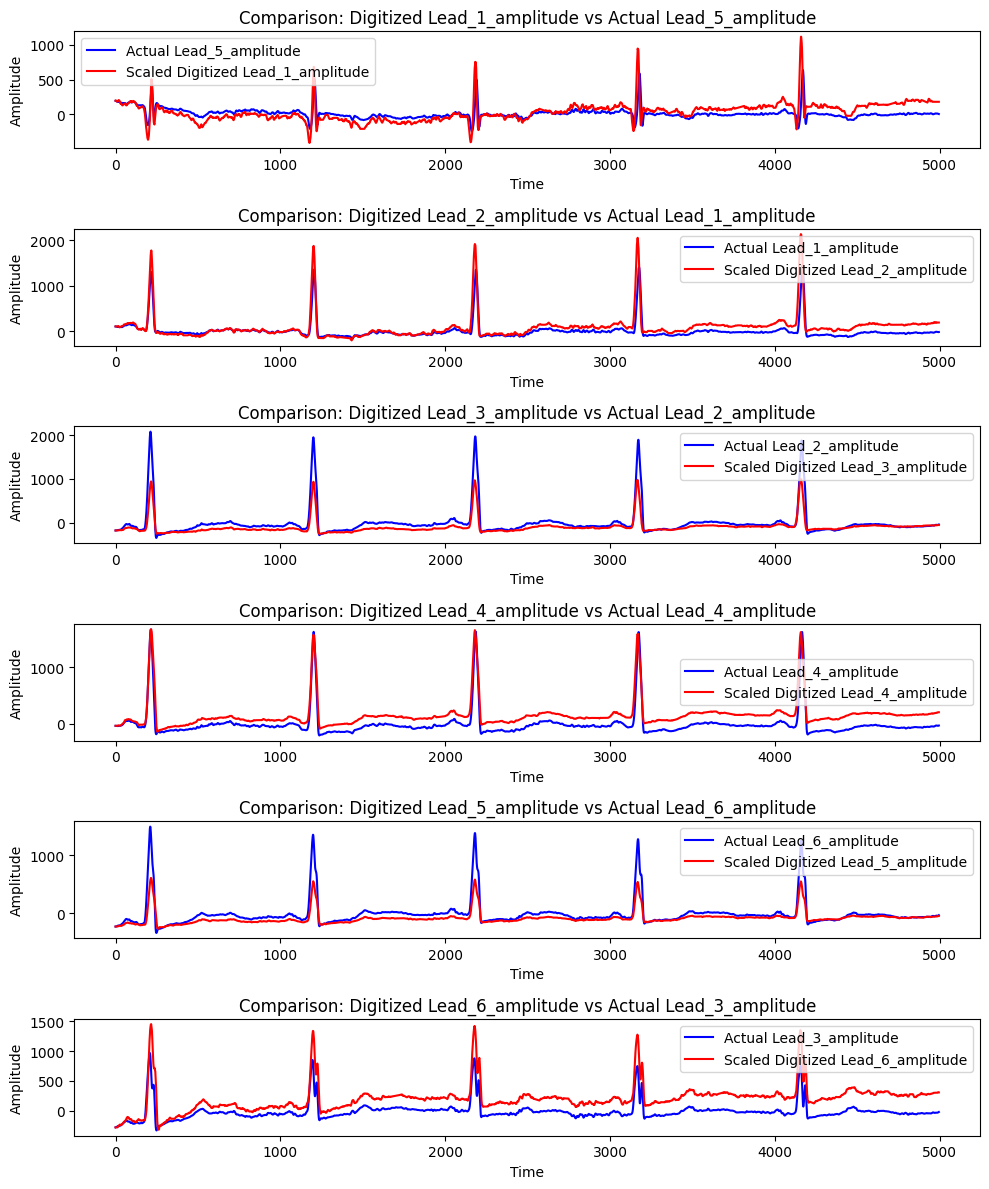

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.interpolate import CubicSpline

# Define the necessary functions
def pcc(y_true, y_pred):
    """Calculate Pearson Correlation Coefficient."""
    return y_true.corr(y_pred)

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return sqrt(np.mean((y_true - y_pred) ** 2))

# File paths
digitized_file_path = r"ecg_time_amplitude.csv"  # Path to your digitized data file
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120205.926316_new.csv"  # Path to your actual data file for 86
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120219.848511_new.csv"  # Path to your actual data file for 105
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120222.630823_new.csv"  # Path to your actual data file For 108 page 1
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120306.333710_new.csv"  # Path to your actual data file For 158 page 1
actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv"  # Path to your actual data file For 124 page 1


# Load the data
digitized_df = pd.read_csv(digitized_file_path)
actual_df = pd.read_csv(actual_file_path)

# Leads to validate
leads_to_validate = [f'Lead_{i}_amplitude' for i in range(1, 7)]  # Lead_1 to Lead_6

# Initialize lists for storing results
pcc_results = []
rmse_results = []

# Determine the min and max values for scaling
min_max_values = {}
for lead in leads_to_validate:
    if lead not in actual_df.columns or lead not in digitized_df.columns:
        print(f"Warning: Lead '{lead}' is missing in one of the files.")
        continue

    actual_min = actual_df[lead].min()  # Minimum value in the actual data
    actual_max = actual_df[lead].max()  # Maximum value in the actual data
    digitized_min = digitized_df[lead].min()  # Minimum value in the digitized data
    digitized_max = digitized_df[lead].max()  # Maximum value in the digitized data

    min_max_values[lead] = {
        'actual_min': actual_min,
        'actual_max': actual_max,
        'digitized_min': digitized_min,
        'digitized_max': digitized_max
    }

# Apply min-max scaling to digitized data
digitized_df_scaled = digitized_df.copy()
for lead, values in min_max_values.items():
    actual_min = values['actual_min']
    actual_max = values['actual_max']
    digitized_min = values['digitized_min']
    digitized_max = values['digitized_max']

    # Min-Max Scaling formula: (x - min) / (max - min) * (new_max - new_min) + new_min
    digitized_df_scaled[lead] = (digitized_df[lead] - digitized_min) / (digitized_max - digitized_min) * (actual_max - actual_min) + actual_min

# Calculate PCC and RMSE for each lead
for lead in leads_to_validate:
    if lead not in actual_df.columns or lead not in digitized_df_scaled.columns:
        continue

    y_true = actual_df[lead]
    y_pred = digitized_df_scaled[lead]

    # Align lengths by truncating
    min_length = min(len(y_true), len(y_pred))
    y_true = y_true.iloc[:min_length]
    y_pred = y_pred.iloc[:min_length]

    # Check for inversion issue
    if y_pred.mean() < y_true.mean():
        y_pred = -y_pred  # Invert y_pred if needed

    # Calculate metrics
    pcc_value = pcc(y_true, y_pred)
    rmse_value = rmse(y_true, y_pred)

    # Append results to lists
    pcc_results.append({'Lead': lead, 'PCC': pcc_value})
    rmse_results.append({'Lead': lead, 'RMSE': rmse_value})

# Convert lists to DataFrames
pcc_df = pd.DataFrame(pcc_results)
rmse_df = pd.DataFrame(rmse_results)

# Print the results
print("PCC Results:\n", pcc_df)
print("RMSE Results:\n", rmse_df)


def plot_scaled_digitized_single_column(digitized_df_scaled, actual_df, lead_mapping):
    """
    Plots each mapped lead's time-amplitude for scaled digitized data in a single column layout,
    with digitized data values inverted but without inverting the y-axis.
    
    Lead mapping can specify custom comparisons between digitized and actual leads, 
    with the option to flip certain leads from the actual data.

    :param digitized_df_scaled: DataFrame containing scaled digitized data.
    :param actual_df: DataFrame containing actual data for reference.
    :param lead_mapping: Dictionary specifying the mapping from digitized leads to actual leads. 
                         If a tuple is used, the second element indicates whether to flip the actual lead.
    """
    num_leads = len(lead_mapping)

    plt.figure(figsize=(10, num_leads * 2))

    # Plot each lead based on the mapping
    for i, (digitized_lead, actual_lead) in enumerate(lead_mapping.items()):
        # Handle flipping for specific leads
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False

        if digitized_lead not in digitized_df_scaled.columns or actual_lead not in actual_df.columns:
            print(f"Skipping lead comparison: {digitized_lead} vs {actual_lead} as one is missing in the DataFrame")
            continue

        # Align lengths by truncating
        length = min(len(actual_df[actual_lead]), len(digitized_df_scaled[digitized_lead]))
        y_actual = actual_df[actual_lead].iloc[:length]
        y_digitized = digitized_df_scaled[digitized_lead].iloc[:length]

        # Apply flipping if needed
        if flip:
            y_actual = -y_actual

        # Invert the digitized values
        y_digitized = -y_digitized

        # Calculate the shift to align the digitized values with the actual values
        shift_amount = y_actual.iloc[0] - y_digitized.iloc[0]
        y_digitized += shift_amount  # Shift the digitized values

        # Plotting
        plt.subplot(num_leads, 1, i + 1)
        plt.plot(y_actual, label=f'Actual {actual_lead}', color='blue')
        plt.plot(y_digitized, label=f'Scaled Digitized {digitized_lead}', color='red')
        plt.title(f'Comparison: Digitized {digitized_lead} vs Actual {actual_lead}')  # Display mapping
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()



def smooth_leads_with_moving_average(digitized_df, window_size=5):
    """
    Apply moving average smoothing to the digitized leads data.
    
    :param digitized_df: DataFrame containing digitized lead data.
    :param window_size: Size of the moving window.
    :return: Smoothed DataFrame.
    """
    digitized_df_smoothed = digitized_df.copy()

    for lead in digitized_df.columns:
        digitized_df_smoothed[lead] = digitized_df[lead].rolling(window=window_size, center=True).mean()
    
    return digitized_df_smoothed

# Apply moving average smoothing to the scaled digitized data
digitized_df_smoothed_moving_avg = smooth_leads_with_moving_average(digitized_df_scaled, window_size=7)

# Use interpolation for NaNs between valid data points
digitized_df_smoothed_moving_avg = digitized_df_smoothed_moving_avg.interpolate(method='linear')

# Forward fill the NaNs at the start and backward fill at the end
digitized_df_smoothed_moving_avg = digitized_df_smoothed_moving_avg.fillna(method='ffill').fillna(method='bfill')

# # Check if there are still NaN values
print("digi scaled max data")
print(digitized_df_smoothed_moving_avg.max())
print("actual max data")
print(actual_df.max())
print("digi scaled min data")
print(digitized_df_smoothed_moving_avg.min())
print("actual min data")
print(actual_df.min())


# Example lead mapping:
# Lead 1 of digitized_df_smoothed should be matched with Lead 5 of actual_df
# Lead 4 of digitized_df_smoothed should be matched with the flipped version of Lead 4 of actual_df
lead_mapping = {
    'Lead_1_amplitude': 'Lead_5_amplitude',
    'Lead_2_amplitude': 'Lead_1_amplitude',
    'Lead_3_amplitude': 'Lead_2_amplitude',
    'Lead_4_amplitude': ('Lead_4_amplitude', True),  # Flip Lead_4 of actual_df
    'Lead_5_amplitude': 'Lead_6_amplitude',
    'Lead_6_amplitude': 'Lead_3_amplitude'
}



# Plot the smoothed data
plot_scaled_digitized_single_column(digitized_df_smoothed_moving_avg, actual_df, lead_mapping)


## Updated min max scaling with PCC and RMSE

C:\Users\ROG\AppData\Local\Temp\ipykernel_17720\567482478.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


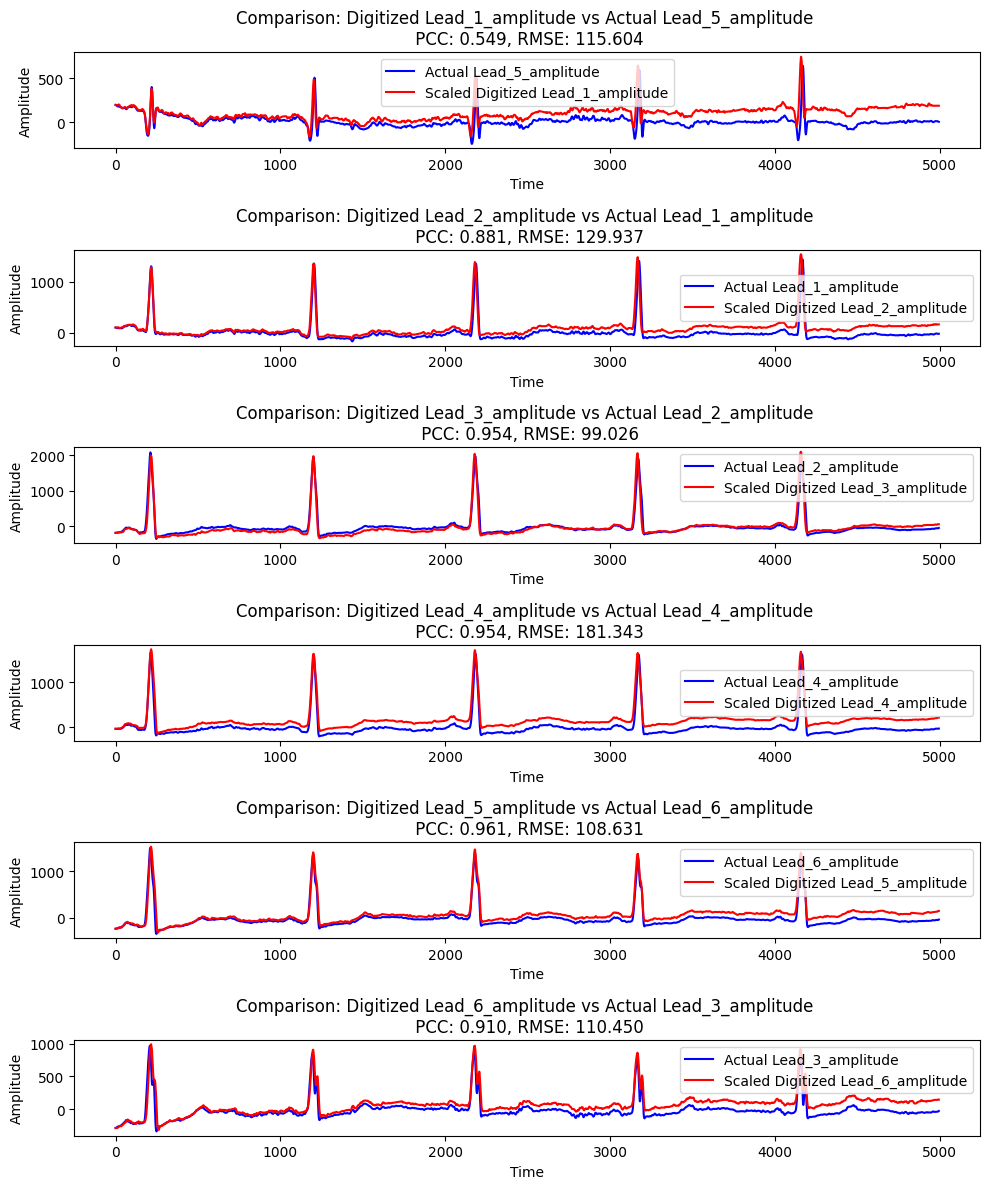


Pearson Correlation Coefficient (PCC) and Root Mean Squared Error (RMSE) results:
Lead_1_amplitude: PCC = 0.549, RMSE = 115.604
Lead_2_amplitude: PCC = 0.881, RMSE = 129.937
Lead_3_amplitude: PCC = 0.954, RMSE = 99.026
Lead_4_amplitude: PCC = 0.954, RMSE = 181.343
Lead_5_amplitude: PCC = 0.961, RMSE = 108.631
Lead_6_amplitude: PCC = 0.910, RMSE = 110.450


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# File paths
digitized_file_path = r"ecg_time_amplitude.csv"  # Path to your digitized data file
actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv"  # Path to your actual data file For 124 page 1

# Load the data
digitized_df = pd.read_csv(digitized_file_path)
actual_df = pd.read_csv(actual_file_path)

# Leads to validate
leads_to_validate = [f'Lead_{i}_amplitude' for i in range(1, 7)]  # Lead_1 to Lead_6

# Smooth the digitized data with a moving average
def smooth_leads_with_moving_average(digitized_df, window_size=5):
    """Apply moving average smoothing to the digitized leads data."""
    digitized_df_smoothed = digitized_df.copy()
    for lead in digitized_df.columns:
        digitized_df_smoothed[lead] = digitized_df[lead].rolling(window=window_size, center=True).mean()
    return digitized_df_smoothed

digitized_df_smoothed = smooth_leads_with_moving_average(digitized_df, window_size=7)
digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

# Lead mapping (mapping digitized leads to actual leads)
lead_mapping = {
    'Lead_1_amplitude': 'Lead_5_amplitude',
    'Lead_2_amplitude': 'Lead_1_amplitude',
    'Lead_3_amplitude': 'Lead_2_amplitude',
    'Lead_4_amplitude': ('Lead_4_amplitude', True),  # Flip Lead_4 of actual_df
    'Lead_5_amplitude': 'Lead_6_amplitude',
    'Lead_6_amplitude': 'Lead_3_amplitude'
}

# Min-max scaling based on lead mappings
def apply_min_max_scaling(digitized_df, actual_df, lead_mapping):
    """
    Apply min-max scaling to the digitized data based on the actual data, following the lead mappings.
    """
    digitized_df_scaled = digitized_df.copy()

    for digitized_lead, actual_lead in lead_mapping.items():
        # Handle flipping if needed
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False

        # Ensure both leads exist in the DataFrames
        if digitized_lead not in digitized_df.columns or actual_lead not in actual_df.columns:
            print(f"Warning: Lead '{digitized_lead}' or '{actual_lead}' is missing.")
            continue

        # Get min/max values for scaling
        actual_min = actual_df[actual_lead].min()
        actual_max = actual_df[actual_lead].max()
        digitized_min = digitized_df[digitized_lead].min()
        digitized_max = digitized_df[digitized_lead].max()

        # Min-max scaling formula
        digitized_df_scaled[digitized_lead] = (digitized_df[digitized_lead] - digitized_min) / (digitized_max - digitized_min) * (actual_max - actual_min) + actual_min

        # # Apply flipping to actual data if needed
        # if flip:
        #     digitized_df_scaled[digitized_lead] = -digitized_df_scaled[digitized_lead]

    return digitized_df_scaled

digitized_df_scaled = apply_min_max_scaling(digitized_df_smoothed, actual_df, lead_mapping)


# Define the necessary functions
def pcc(y_true, y_pred):
    """Calculate Pearson Correlation Coefficient."""
    return y_true.corr(y_pred)

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return sqrt(np.mean((y_true - y_pred) ** 2))

# Function to plot scaled digitized data in a single column layout and calculate PCC and RMSE
def plot_scaled_digitized_single_column_with_metrics(digitized_df_scaled, actual_df, lead_mapping):
    """
    Plots each mapped lead's time-amplitude for scaled digitized data in a single column layout and calculates PCC and RMSE.
    """
    num_leads = len(lead_mapping)
    plt.figure(figsize=(10, num_leads * 2))

    pcc_results = {}
    rmse_results = {}

    # Plot each lead based on the mapping
    for i, (digitized_lead, actual_lead) in enumerate(lead_mapping.items()):
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False

        if digitized_lead not in digitized_df_scaled.columns or actual_lead not in actual_df.columns:
            print(f"Skipping lead comparison: {digitized_lead} vs {actual_lead} as one is missing in the DataFrame")
            continue

        # Align lengths by truncating
        length = min(len(actual_df[actual_lead]), len(digitized_df_scaled[digitized_lead]))
        y_actual = actual_df[actual_lead].iloc[:length]
        y_digitized = digitized_df_scaled[digitized_lead].iloc[:length]

        # Flip actual lead if specified
        if flip:
            y_actual = -y_actual

        # Invert the digitized values
        y_digitized = -y_digitized

        # Calculate the shift to align the digitized values with the actual values
        shift_amount = y_actual.iloc[0] - y_digitized.iloc[0]
        y_digitized += shift_amount  # Shift the digitized values

        # Calculate PCC and RMSE for each lead
        pcc_value = pcc(y_actual, y_digitized)
        rmse_value = rmse(y_actual, y_digitized)
        pcc_results[digitized_lead] = pcc_value
        rmse_results[digitized_lead] = rmse_value

        # Plotting
        plt.subplot(num_leads, 1, i + 1)
        plt.plot(y_actual, label=f'Actual {actual_lead}', color='blue')
        plt.plot(y_digitized, label=f'Scaled Digitized {digitized_lead}', color='red')
        plt.title(f'Comparison: Digitized {digitized_lead} vs Actual {actual_lead} \n PCC: {pcc_value:.3f}, RMSE: {rmse_value:.3f}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Output PCC and RMSE results
    print("\nPearson Correlation Coefficient (PCC) and Root Mean Squared Error (RMSE) results:")
    for lead, pcc_value in pcc_results.items():
        print(f"{lead}: PCC = {pcc_value:.3f}, RMSE = {rmse_results[lead]:.3f}")

# Call the updated function
plot_scaled_digitized_single_column_with_metrics(digitized_df_scaled, actual_df, lead_mapping)

C:\Users\ROG\AppData\Local\Temp\ipykernel_17720\3915887026.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Comparing leads: digi: Lead_1_amplitude actual: Lead_5_amplitude
Comparing leads: digi: Lead_2_amplitude actual: Lead_1_amplitude
Comparing leads: digi: Lead_3_amplitude actual: Lead_2_amplitude
Comparing leads: digi: Lead_4_amplitude actual: Lead_4_amplitude
Comparing leads: digi: Lead_5_amplitude actual: Lead_6_amplitude
Comparing leads: digi: Lead_6_amplitude actual: Lead_3_amplitude


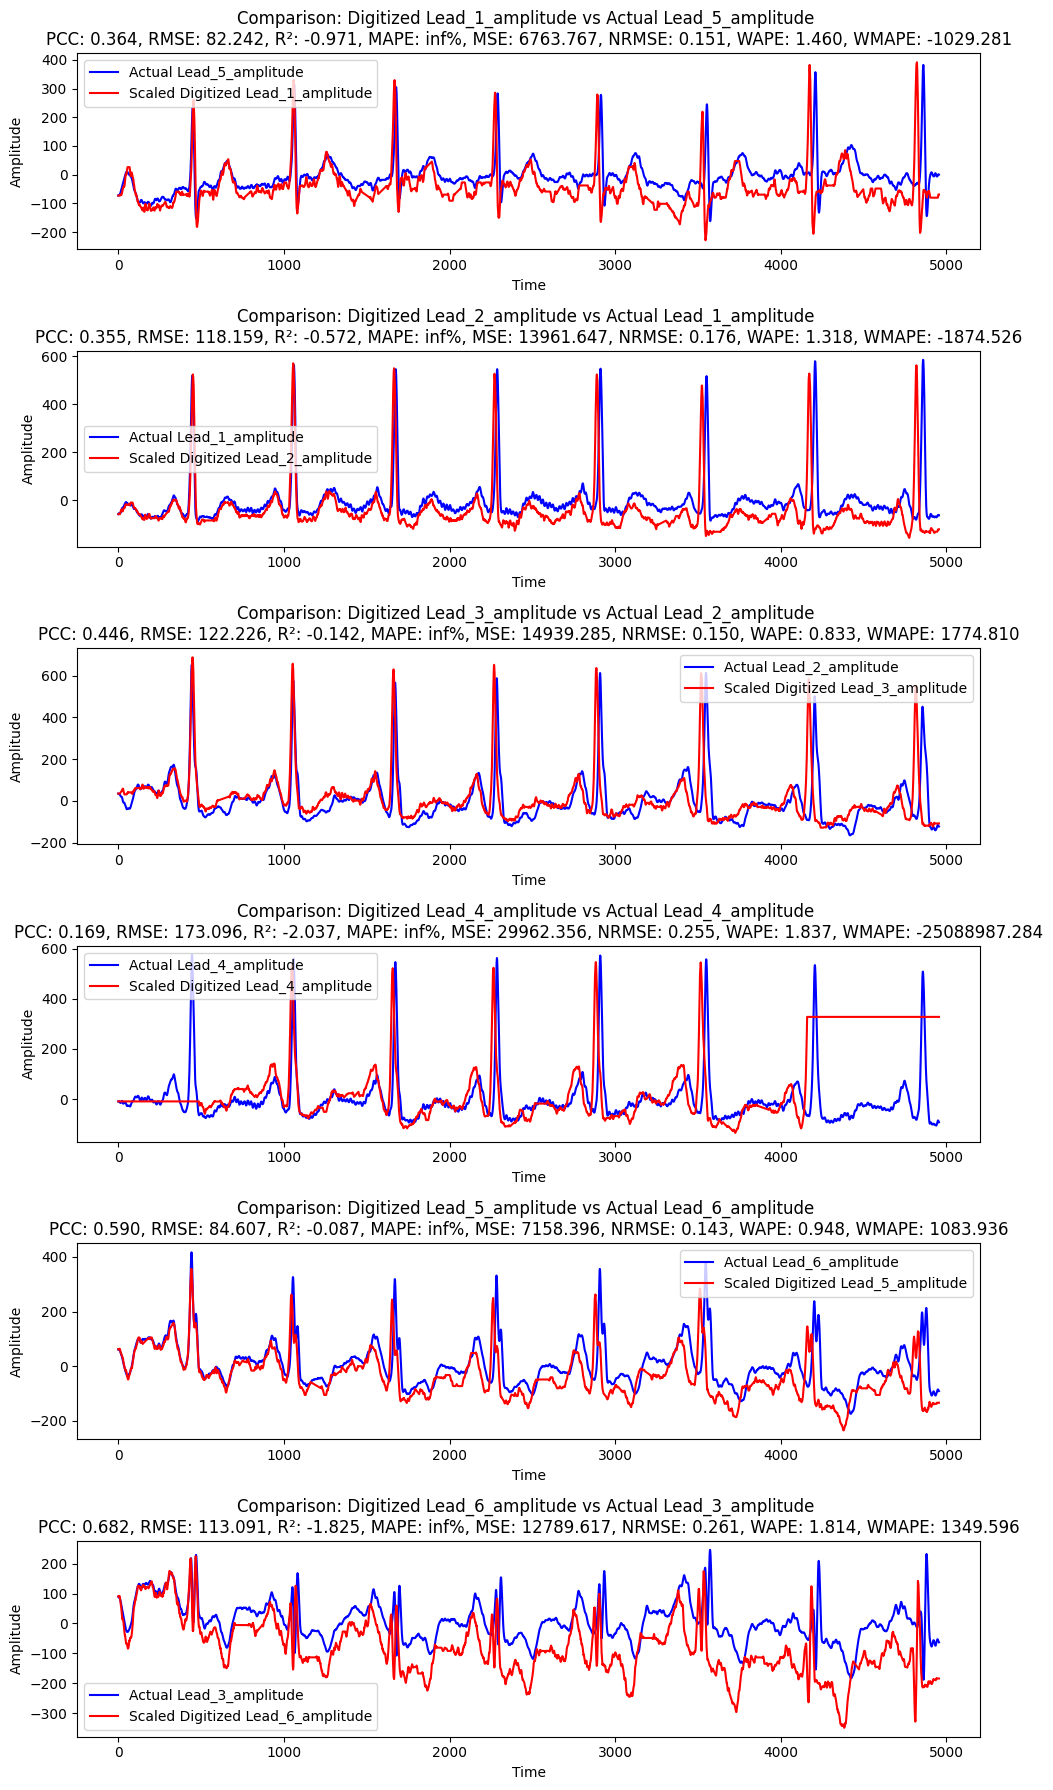


Metrics results:
Lead_1_amplitude: PCC = 0.364, RMSE = 82.242, R² = -0.971, MAPE = inf%, MSE = 6763.767, NRMSE = 0.151, WAPE = 1.460, WMAPE = -1029.281%
Lead_2_amplitude: PCC = 0.355, RMSE = 118.159, R² = -0.572, MAPE = inf%, MSE = 13961.647, NRMSE = 0.176, WAPE = 1.318, WMAPE = -1874.526%
Lead_3_amplitude: PCC = 0.446, RMSE = 122.226, R² = -0.142, MAPE = inf%, MSE = 14939.285, NRMSE = 0.150, WAPE = 0.833, WMAPE = 1774.810%
Lead_4_amplitude: PCC = 0.169, RMSE = 173.096, R² = -2.037, MAPE = inf%, MSE = 29962.356, NRMSE = 0.255, WAPE = 1.837, WMAPE = -25088987.284%
Lead_5_amplitude: PCC = 0.590, RMSE = 84.607, R² = -0.087, MAPE = inf%, MSE = 7158.396, NRMSE = 0.143, WAPE = 0.948, WMAPE = 1083.936%
Lead_6_amplitude: PCC = 0.682, RMSE = 113.091, R² = -1.825, MAPE = inf%, MSE = 12789.617, NRMSE = 0.261, WAPE = 1.814, WMAPE = 1349.596%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# File paths
digitized_file_path = r"ecg_time_amplitude.csv"  # Path to your digitized data file
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120205.926316_new.csv"  # Path to your actual data file for 86
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120219.848511_new.csv"  # Path to your actual data file for 105
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120222.630823_new.csv"  # Path to your actual data file For 108 page 1
actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120306.333710_new.csv"  # Path to your actual data file For 158 page 1
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv"  # Path to your actual data file For 124 page 1

# Load the data
digitized_df = pd.read_csv(digitized_file_path)
actual_df = pd.read_csv(actual_file_path)

# Leads to validate
leads_to_validate = [f'Lead_{i}_amplitude' for i in range(1, 7)]  # Lead_1 to Lead_6

# Smooth the digitized data with a moving average
def smooth_leads_with_moving_average(digitized_df, window_size=5):
    """Apply moving average smoothing to the digitized leads data."""
    digitized_df_smoothed = digitized_df.copy()
    for lead in digitized_df.columns:
        digitized_df_smoothed[lead] = digitized_df[lead].rolling(window=window_size, center=True).mean()
    return digitized_df_smoothed

digitized_df_smoothed = smooth_leads_with_moving_average(digitized_df, window_size=7)
digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

# Lead mapping (mapping digitized leads to actual leads)
lead_mapping = {
    'Lead_1_amplitude': 'Lead_5_amplitude',
    'Lead_2_amplitude': 'Lead_1_amplitude',
    'Lead_3_amplitude': 'Lead_2_amplitude',
    'Lead_4_amplitude': ('Lead_4_amplitude', True),  # Flip Lead_4 of actual_df
    'Lead_5_amplitude': 'Lead_6_amplitude',
    'Lead_6_amplitude': 'Lead_3_amplitude'
}

# Min-max scaling based on lead mappings
def apply_min_max_scaling(digitized_df, actual_df, lead_mapping):
    """
    Apply min-max scaling to the digitized data based on the actual data, following the lead mappings.
    """
    digitized_df_scaled = digitized_df.copy()

    for digitized_lead, actual_lead in lead_mapping.items():
        # Handle flipping if needed
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False

        # Ensure both leads exist in the DataFrames
        if digitized_lead not in digitized_df.columns or actual_lead not in actual_df.columns:
            print(f"Warning: Lead '{digitized_lead}' or '{actual_lead}' is missing.")
            continue

        # Get min/max values for scaling
        actual_min = actual_df[actual_lead].min()
        actual_max = actual_df[actual_lead].max()
        digitized_min = digitized_df[digitized_lead].min()
        digitized_max = digitized_df[digitized_lead].max()

        # Min-max scaling formula
        digitized_df_scaled[digitized_lead] = (digitized_df[digitized_lead] - digitized_min) / (digitized_max - digitized_min) * (actual_max - actual_min) + actual_min

        # # Apply flipping to actual data if needed
        # if flip:
        #     digitized_df_scaled[digitized_lead] = -digitized_df_scaled[digitized_lead]

    return digitized_df_scaled

digitized_df_scaled = apply_min_max_scaling(digitized_df_smoothed, actual_df, lead_mapping)


# Define the necessary functions
def pcc(y_true, y_pred):
    """Calculate Pearson Correlation Coefficient."""
    return y_true.corr(y_pred)

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return sqrt(np.mean((y_true - y_pred) ** 2))
# Define the function to calculate R-squared
def r_squared(y_true, y_pred):
    """Calculate R-squared error."""
    ss_res = np.sum((y_true - y_pred) ** 2)  # Sum of squared residuals
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Additional metric calculations
def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    """Calculate Mean Squared Error (MSE)."""
    return np.mean((y_true - y_pred) ** 2)

def nrmse(y_true, y_pred):
    """Calculate Normalized Root Mean Squared Error (NRMSE)."""
    return rmse(y_true, y_pred) / (y_true.max() - y_true.min())

def wape(y_true, y_pred):
    """Calculate Weighted Absolute Percentage Error (WAPE)."""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def wmape(y_true, y_pred):
    """Calculate Weighted Mean Absolute Percentage Error (WMAPE)."""
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

# Update the plotting function to include additional metrics
def plot_scaled_digitized_single_column_with_metrics(digitized_df_scaled, actual_df, lead_mapping):
    """
    Plots each mapped lead's time-amplitude for scaled digitized data in a single column layout and calculates
    various metrics: PCC, RMSE, R², MAPE, MSE, NRMSE, WAPE, WMAPE.
    """
    num_leads = len(lead_mapping)
    plt.figure(figsize=(10, num_leads * 3))

    metrics_results = {
        'PCC': {},
        'RMSE': {},
        'R²': {},
        'MAPE': {},
        'MSE': {},
        'NRMSE': {},
        'WAPE': {},
        'WMAPE': {},
    }

    # Plot each lead based on the mapping
    for i, (digitized_lead, actual_lead) in enumerate(lead_mapping.items()):
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False
        print(f"Comparing leads: digi: {digitized_lead} actual: {actual_lead}")

        if digitized_lead not in digitized_df_scaled.columns or actual_lead not in actual_df.columns:
            print(f"Skipping lead comparison: {digitized_lead} vs {actual_lead} as one is missing in the DataFrame")
            continue

        # Align lengths by truncating
        length = min(len(actual_df[actual_lead]), len(digitized_df_scaled[digitized_lead]))
        y_actual = actual_df[actual_lead].iloc[:length]
        y_digitized = digitized_df_scaled[digitized_lead].iloc[:length]

        # Flip actual lead if specified
        if flip:
            y_actual = -y_actual

        # Invert the digitized values
        y_digitized = -y_digitized

        # Calculate the shift to align the digitized values with the actual values
        shift_amount = y_actual.iloc[0] - y_digitized.iloc[0]
        y_digitized += shift_amount  # Shift the digitized values

        # Calculate metrics
        metrics_results['PCC'][digitized_lead] = pcc(y_actual, y_digitized)
        metrics_results['RMSE'][digitized_lead] = rmse(y_actual, y_digitized)
        metrics_results['R²'][digitized_lead] = r_squared(y_actual, y_digitized)
        metrics_results['MAPE'][digitized_lead] = mape(y_actual, y_digitized)
        metrics_results['MSE'][digitized_lead] = mse(y_actual, y_digitized)
        metrics_results['NRMSE'][digitized_lead] = nrmse(y_actual, y_digitized)
        metrics_results['WAPE'][digitized_lead] = wape(y_actual, y_digitized)
        metrics_results['WMAPE'][digitized_lead] = wmape(y_actual, y_digitized)

        # Plotting
        plt.subplot(num_leads, 1, i + 1)
        plt.plot(y_actual, label=f'Actual {actual_lead}', color='blue')
        plt.plot(y_digitized, label=f'Scaled Digitized {digitized_lead}', color='red')
        plt.title(f'Comparison: Digitized {digitized_lead} vs Actual {actual_lead} \n'
                  f'PCC: {metrics_results["PCC"][digitized_lead]:.3f}, '
                  f'RMSE: {metrics_results["RMSE"][digitized_lead]:.3f}, '
                  f'R²: {metrics_results["R²"][digitized_lead]:.3f}, '
                  f'MAPE: {metrics_results["MAPE"][digitized_lead]:.3f}%, '
                  f'MSE: {metrics_results["MSE"][digitized_lead]:.3f}, '
                  f'NRMSE: {metrics_results["NRMSE"][digitized_lead]:.3f}, '
                  f'WAPE: {metrics_results["WAPE"][digitized_lead]:.3f}, '
                  f'WMAPE: {metrics_results["WMAPE"][digitized_lead]:.3f}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Output metrics results
    print("\nMetrics results:")
    for lead in metrics_results['PCC']:
        print(f"{lead}: "
              f"PCC = {metrics_results['PCC'][lead]:.3f}, "
              f"RMSE = {metrics_results['RMSE'][lead]:.3f}, "
              f"R² = {metrics_results['R²'][lead]:.3f}, "
              f"MAPE = {metrics_results['MAPE'][lead]:.3f}%, "
              f"MSE = {metrics_results['MSE'][lead]:.3f}, "
              f"NRMSE = {metrics_results['NRMSE'][lead]:.3f}, "
              f"WAPE = {metrics_results['WAPE'][lead]:.3f}, "
              f"WMAPE = {metrics_results['WMAPE'][lead]:.3f}%")

# Call the updated function
plot_scaled_digitized_single_column_with_metrics(digitized_df_scaled, actual_df, lead_mapping)



In [ ]:
# 

## Validation with max-min Leads 7-12

PCC Results:
                 Lead       PCC
0   Lead_7_amplitude -0.381691
1   Lead_8_amplitude -0.003736
2   Lead_9_amplitude  0.005504
3  Lead_10_amplitude -0.938722
4  Lead_11_amplitude -0.827964
5  Lead_12_amplitude -0.359373
RMSE Results:
                 Lead        RMSE
0   Lead_7_amplitude  217.397448
1   Lead_8_amplitude  477.908581
2   Lead_9_amplitude  539.322106
3  Lead_10_amplitude  505.328461
4  Lead_11_amplitude  321.234197
5  Lead_12_amplitude  210.433587


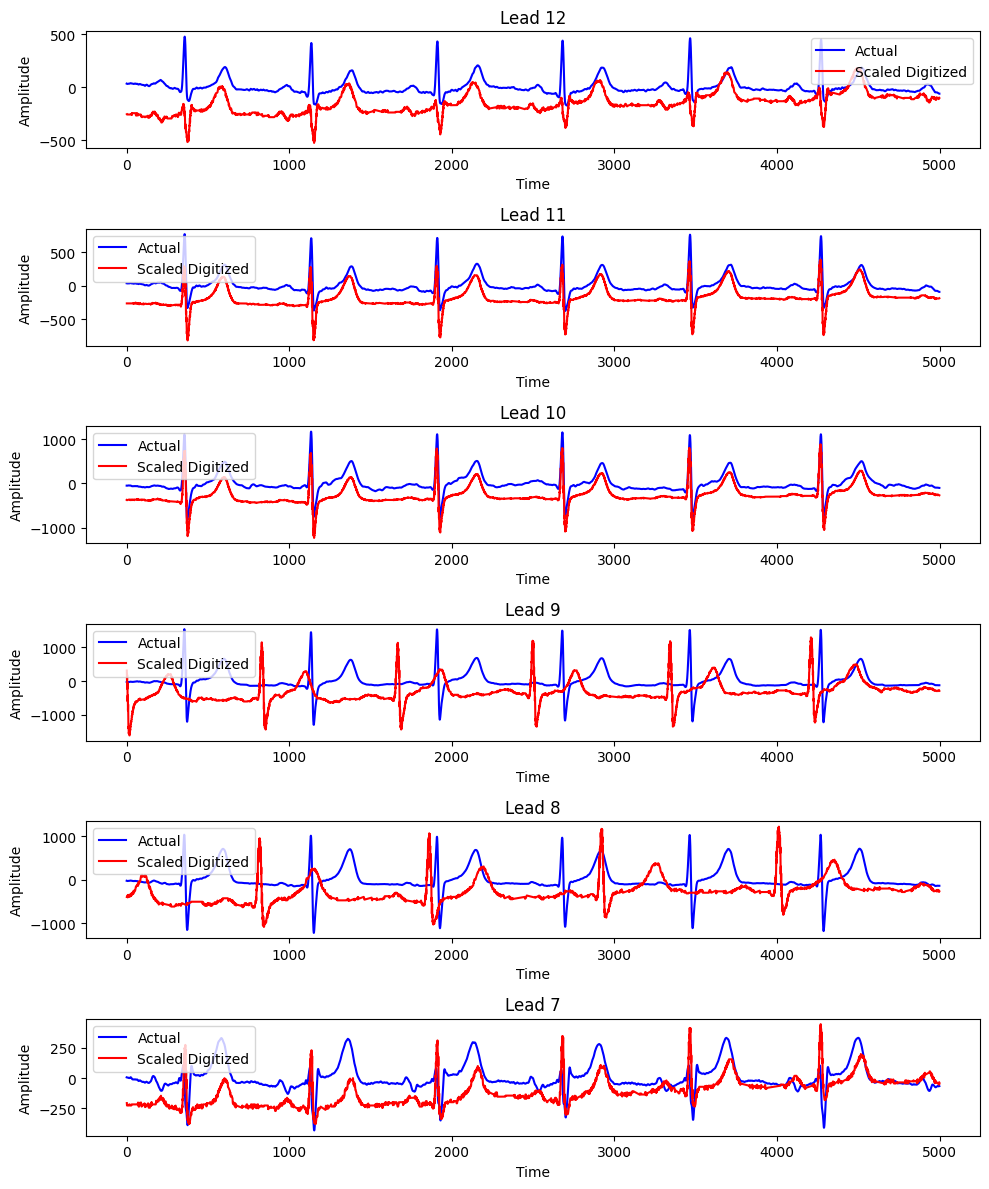

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# Define the necessary functions
def pcc(y_true, y_pred):
    """Calculate Pearson Correlation Coefficient."""
    return y_true.corr(y_pred)

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return sqrt(np.mean((y_true - y_pred) ** 2))

# File paths
digitized_file_path = r"ecg_leads.csv"  # Path to your digitized data file
# actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120222.630823_new.csv"  # Path to your actual data file For 108 page 1
actual_file_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\20230427-120205.926316_new.csv"  # Path to your actual data file For 86 page 1

# Load the data
digitized_df = pd.read_csv(digitized_file_path)
actual_df = pd.read_csv(actual_file_path)

# Leads to validate
leads_to_validate = [f'Lead_{i}_amplitude' for i in range(7, 13)]  # Lead_7 to Lead_12

# Initialize lists for storing results
pcc_results = []
rmse_results = []

# Determine the min and max values for scaling
min_max_values = {}
for lead in leads_to_validate:
    if lead not in actual_df.columns or lead not in digitized_df.columns:
        print(f"Warning: Lead '{lead}' is missing in one of the files.")
        continue

    actual_min = actual_df[lead].min()  # Minimum value in the actual data
    actual_max = actual_df[lead].max()  # Maximum value in the actual data
    digitized_min = digitized_df[lead].min()  # Minimum value in the digitized data
    digitized_max = digitized_df[lead].max()  # Maximum value in the digitized data

    min_max_values[lead] = {
        'actual_min': actual_min,
        'actual_max': actual_max,
        'digitized_min': digitized_min,
        'digitized_max': digitized_max
    }

# Apply min-max scaling to digitized data
digitized_df_scaled = digitized_df.copy()
for lead, values in min_max_values.items():
    actual_min = values['actual_min']
    actual_max = values['actual_max']
    digitized_min = values['digitized_min']
    digitized_max = values['digitized_max']

    # Min-Max Scaling formula: (x - min) / (max - min) * (new_max - new_min) + new_min
    digitized_df_scaled[lead] = (digitized_df[lead] - digitized_min) / (digitized_max - digitized_min) * (actual_max - actual_min) + actual_min

# Calculate PCC and RMSE for each lead
for lead in leads_to_validate:
    if lead not in actual_df.columns or lead not in digitized_df_scaled.columns:
        continue

    y_true = actual_df[lead]
    y_pred = digitized_df_scaled[lead]

    # Align lengths by truncating
    min_length = min(len(y_true), len(y_pred))
    y_true = y_true.iloc[:min_length]
    y_pred = y_pred.iloc[:min_length]

    # Check for inversion issue
    if y_pred.mean() < y_true.mean():
        y_pred = -y_pred  # Invert y_pred if needed

    # Calculate metrics
    pcc_value = pcc(y_true, y_pred)
    rmse_value = rmse(y_true, y_pred)

    # Append results to lists
    pcc_results.append({'Lead': lead, 'PCC': pcc_value})
    rmse_results.append({'Lead': lead, 'RMSE': rmse_value})

# Convert lists to DataFrames
pcc_df = pd.DataFrame(pcc_results)
rmse_df = pd.DataFrame(rmse_results)

# Print the results
print("PCC Results:\n", pcc_df)
print("RMSE Results:\n", rmse_df)

def plot_scaled_digitized_single_column(digitized_df_scaled, actual_df):
    """
    Plots each lead's time-amplitude for scaled digitized data in a single column layout,
    with digitized data values inverted but without inverting the y-axis.

    :param digitized_df_scaled: DataFrame containing scaled digitized data.
    :param actual_df: DataFrame containing actual data for reference.
    """
    # Define the lead range you want to plot
    lead_range = range(12, 6, -1)  # This creates a range from 12 to 7 (inclusive)
    num_leads = len(lead_range)

    plt.figure(figsize=(10, num_leads * 2))

    # Plot each lead in the specified range
    for i, lead_num in enumerate(lead_range):
        amp_col = f'Lead_{lead_num}_amplitude'

        if amp_col not in digitized_df_scaled.columns:
            print(f"Skipping Lead {lead_num} as it's missing in the DataFrame")
            continue

        # Align lengths by truncating
        length = min(len(actual_df[amp_col]), len(digitized_df_scaled[amp_col]))
        y_actual = actual_df[amp_col].iloc[:length]
        y_digitized = digitized_df_scaled[amp_col].iloc[:length]

        # Invert the digitized values
        y_digitized = -y_digitized

        # Plotting
        plt.subplot(num_leads, 1, i + 1)
        plt.plot(y_actual, label='Actual', color='blue')
        plt.plot(y_digitized, label='Scaled Digitized', color='red')
        plt.title(f'Lead {lead_num}')  # Keep numbering consistent
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_scaled_digitized_single_column(digitized_df_scaled, actual_df)




## Validation all files

In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# Define necessary functions
def pcc(y_true, y_pred):
    """Calculate Pearson Correlation Coefficient."""
    return y_true.corr(y_pred)

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return sqrt(np.mean((y_true - y_pred) ** 2))

def plot_scaled_digitized_single_column(digitized_df_scaled, actual_df, lead_mapping, save_path):
    """
    Plots each mapped lead's time-amplitude for scaled digitized data in a single column layout.
    
    :param digitized_df_scaled: DataFrame containing scaled digitized data.
    :param actual_df: DataFrame containing actual data for reference.
    :param lead_mapping: Dictionary specifying the mapping from digitized leads to actual leads. 
    :param save_path: Path to save the plot.
    """
    num_leads = len(lead_mapping)
    plt.figure(figsize=(10, num_leads * 2))

    for i, (digitized_lead, actual_lead) in enumerate(lead_mapping.items()):
        flip = False
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead

        if digitized_lead not in digitized_df_scaled.columns or actual_lead not in actual_df.columns:
            print(f"Skipping lead comparison: {digitized_lead} vs {actual_lead} as one is missing.")
            continue

        length = min(len(actual_df[actual_lead]), len(digitized_df_scaled[digitized_lead]))
        y_actual = actual_df[actual_lead].iloc[:length]
        y_digitized = digitized_df_scaled[digitized_lead].iloc[:length]

        if flip:
            y_actual = -y_actual

        y_digitized = -y_digitized
        shift_amount = y_actual.iloc[0] - y_digitized.iloc[0]
        y_digitized += shift_amount

        plt.subplot(num_leads, 1, i + 1)
        plt.plot(y_actual, label=f'Actual {actual_lead}', color='blue')
        plt.plot(y_digitized, label=f'Scaled Digitized {digitized_lead}', color='red')
        plt.title(f'Comparison: Digitized {digitized_lead} vs Actual {actual_lead}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Plot saved at: {save_path}")

def smooth_leads_with_moving_average(digitized_df, window_size=5):
    """Apply moving average smoothing to the digitized leads data."""
    digitized_df_smoothed = digitized_df.copy()

    for lead in digitized_df.columns:
        digitized_df_smoothed[lead] = digitized_df[lead].rolling(window=window_size, center=True).mean()

    return digitized_df_smoothed

# Load the file2id.csv file
file2id_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\file2id.csv"
file2id_df = pd.read_csv(file2id_path)

# Define paths
digitized_folder = r"D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates"
actual_folder = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new"
validation_folder = r"D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation"

# Iterate through the file2id.csv and match the files
for _, row in file2id_df.iterrows():
    id_value = str(row['ID'])
    x_value = row['X.0']
    
    print(f"\nProcessing ID: {id_value} with X.0: {x_value}")

    for page in [1, 2]:
        # Define the file names for both pages
        digitized_file_name = f"{id_value}_F_page_{page}.csv"
        actual_file_name = f"{x_value}.csv"

        digitized_file_path = os.path.join(digitized_folder, digitized_file_name)
        actual_file_path = os.path.join(actual_folder, actual_file_name)

        # Ensure both files exist
        if not os.path.exists(digitized_file_path):
            print(f"Digitized file not found for ID: {id_value}, page {page}")
            continue

        if not os.path.exists(actual_file_path):
            print(f"Actual file not found for X.0: {x_value}")
            continue

        # Load the data
        print(f"Loading files:\nDigitized: {digitized_file_path}\nActual: {actual_file_path}")
        digitized_df = pd.read_csv(digitized_file_path)
        actual_df = pd.read_csv(actual_file_path)

        # Leads to validate
        leads_to_validate = [f'Lead_{i}_amplitude' for i in range(1, 7)]

        # Initialize lists for storing results
        min_max_values = {}

        # Determine min-max scaling values
        for lead in leads_to_validate:
            if lead not in actual_df.columns or lead not in digitized_df.columns:
                continue

            actual_min = actual_df[lead].min()
            actual_max = actual_df[lead].max()
            digitized_min = digitized_df[lead].min()
            digitized_max = digitized_df[lead].max()

            min_max_values[lead] = {
                'actual_min': actual_min,
                'actual_max': actual_max,
                'digitized_min': digitized_min,
                'digitized_max': digitized_max
            }

        # Apply min-max scaling to digitized data
        digitized_df_scaled = digitized_df.copy()
        for lead, values in min_max_values.items():
            actual_min = values['actual_min']
            actual_max = values['actual_max']
            digitized_min = values['digitized_min']
            digitized_max = values['digitized_max']

            digitized_df_scaled[lead] = (digitized_df[lead] - digitized_min) / (digitized_max - digitized_min) * (actual_max - actual_min) + actual_min

        # Apply smoothing
        digitized_df_smoothed = smooth_leads_with_moving_average(digitized_df_scaled, window_size=7)
        digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

        # Define lead mappings for both pages
        if page == 1:
            lead_mapping = {
                'Lead_1_amplitude': 'Lead_5_amplitude',
                'Lead_2_amplitude': 'Lead_1_amplitude',
                'Lead_3_amplitude': 'Lead_2_amplitude',
                'Lead_4_amplitude': ('Lead_4_amplitude', True),
                'Lead_5_amplitude': 'Lead_6_amplitude',
                'Lead_6_amplitude': 'Lead_3_amplitude'
            }
            validation_file_name = f"{id_value}_validation_page_1.png"
        else:
            lead_mapping = {
                'Lead_1_amplitude': 'Lead_7_amplitude',
                'Lead_2_amplitude': 'Lead_8_amplitude',
                'Lead_3_amplitude': 'Lead_9_amplitude',
                'Lead_4_amplitude': 'Lead_10_amplitude',
                'Lead_5_amplitude': 'Lead_11_amplitude',
                'Lead_6_amplitude': 'Lead_12_amplitude'
            }
            validation_file_name = f"{id_value}_validation_page_2.png"

        # Plot and save to validation folder
        save_path = os.path.join(validation_folder, validation_file_name)
        print(f"Saving plot to: {save_path}")
        plot_scaled_digitized_single_column(digitized_df_smoothed, actual_df, lead_mapping, save_path)



Processing ID: 105 with X.0: 20230427-120219.848511
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\105_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120219.848511.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\105_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120219.848511.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_validation_page_2.png

Processing ID: 49 with X.0: 20230427-120154.542147
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\49_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120154.542147.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\49_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120154.542147.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_validation_page_2.png

Processing ID: 141 with X.0: 20230427-120252.193033
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\141_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120252.193033.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\141_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120252.193033.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_validation_page_2.png

Processing ID: 158 with X.0: 20230427-120306.333710
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\158_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120306.333710.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\158_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120306.333710.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_validation_page_2.png

Processing ID: 109 with X.0: 20230427-120223.555031
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\109_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120223.555031.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\109_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120223.555031.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_validation_page_2.png

Processing ID: 78 with X.0: 20230427-120203.154255
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\78_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120203.154255.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\78_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120203.154255.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_validation_page_2.png

Processing ID: 118 with X.0: 20230427-120231.707890
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\118_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120231.707890.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\118_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120231.707890.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_validation_page_2.png

Processing ID: 137 with X.0: 20230427-120248.630478
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\137_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120248.630478.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\137_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120248.630478.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_validation_page_2.png

Processing ID: 145 with X.0: 20230427-120255.614515
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\145_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120255.614515.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\145_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120255.614515.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_validation_page_2.png

Processing ID: 140 with X.0: 20230427-120251.349105
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\140_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120251.349105.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\140_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120251.349105.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.
Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_validation_page_2.png

Processing ID: 139 with X.0: 20230427-120250.489466
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\139_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120250.489466.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\139_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120250.489466.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_validation_page_2.png

Processing ID: 94 with X.0: 20230427-120212.020009
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\94_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.020009.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\94_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.020009.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_validation_page_2.png

Processing ID: 172 with X.0: 20230427-120318.802568
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\172_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120318.802568.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\172_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120318.802568.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_validation_page_2.png

Processing ID: 126 with X.0: 20230427-120238.957669
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\126_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.957669.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\126_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.957669.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_validation_page_2.png

Processing ID: 111 with X.0: 20230427-120225.390380
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\111_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120225.390380.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\111_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120225.390380.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_validation_page_2.png

Processing ID: 92 with X.0: 20230427-120210.316835
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\92_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120210.316835.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\92_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120210.316835.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_validation_page_2.png

Processing ID: 89 with X.0: 20230427-120207.754298
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\89_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120207.754298.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\89_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120207.754298.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_validation_page_2.png

Processing ID: 124 with X.0: 20230427-120237.239201
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\124_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\124_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_validation_page_2.png

Processing ID: 104 with X.0: 20230427-120218.926485
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\104_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.926485.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_validation_page_1.png
Skipping lead comparison: Lead_5_amplitude vs Lead_6_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_3_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\104_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.926485.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_validation_page_2.png

Processing ID: 191 with X.0: 20230427-120335.474559
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\191_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120335.474559.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\191_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120335.474559.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_validation_page_2.png

Processing ID: 190 with X.0: 20230427-120334.552653
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\190_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120334.552653.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\190_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120334.552653.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_validation_page_2.png

Processing ID: 193 with X.0: 20230427-120337.146463
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\193_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120337.146463.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\193_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120337.146463.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_validation_page_2.png

Processing ID: 76 with X.0: 20230427-120202.238558
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\76_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120202.238558.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\76_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120202.238558.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_validation_page_2.png

Processing ID: 181 with X.0: 20230427-120326.662360
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\181_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120326.662360.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\181_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120326.662360.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_validation_page_2.png

Processing ID: 183 with X.0: 20230427-120328.505690
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\183_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120328.505690.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\183_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120328.505690.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_validation_page_2.png

Processing ID: 200 with X.0: 20230427-120343.073730
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\200_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120343.073730.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\200_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120343.073730.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_validation_page_2.png

Processing ID: 150 with X.0: 20230427-120259.130224
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\150_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120259.130224.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\150_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120259.130224.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_validation_page_2.png

Processing ID: 202 with X.0: 20230427-120344.740357
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\202_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120344.740357.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\202_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120344.740357.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_validation_page_2.png

Processing ID: 187 with X.0: 20230427-120331.974488
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\187_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.974488.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\187_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.974488.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_validation_page_2.png

Processing ID: 107 with X.0: 20230427-120221.692046
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\107_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120221.692046.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\107_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120221.692046.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_validation_page_2.png

Processing ID: 101 with X.0: 20230427-120216.379470
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\101_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120216.379470.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\101_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120216.379470.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_validation_page_2.png

Processing ID: 113 with X.0: 20230427-120227.160854
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\113_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120227.160854.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\113_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120227.160854.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_validation_page_2.png

Processing ID: 106 with X.0: 20230427-120220.770360
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\106_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120220.770360.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\106_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120220.770360.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_validation_page_2.png

Processing ID: 143 with X.0: 20230427-120253.911563
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\143_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.911563.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\143_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.911563.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_validation_page_2.png

Processing ID: 85 with X.0: 20230427-120204.988880
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\85_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.988880.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\85_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.988880.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_validation_page_2.png

Processing ID: 119 with X.0: 20230427-120232.630012
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\119_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120232.630012.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\119_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120232.630012.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_validation_page_2.png

Processing ID: 52 with X.0: 20230427-120157.113443
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\52_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.113443.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\52_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.113443.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_validation_page_2.png

Processing ID: 91 with X.0: 20230427-120209.458513
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\91_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120209.458513.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_validation_page_1.png
Skipping lead comparison: Lead_6_amplitude vs Lead_3_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\91_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120209.458513.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_validation_page_2.png

Processing ID: 54 with X.0: 20230427-120158.847905
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\54_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120158.847905.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\54_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120158.847905.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_validation_page_2.png

Processing ID: 127 with X.0: 20230427-120239.864635
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\127_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120239.864635.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\127_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120239.864635.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_validation_page_2.png

Processing ID: 110 with X.0: 20230427-120224.473329
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\110_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120224.473329.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\110_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120224.473329.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_validation_page_2.png

Processing ID: 147 with X.0: 20230427-120257.458510
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\147_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120257.458510.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\147_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120257.458510.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_validation_page_2.png

Processing ID: 19 with X.0: 20230427-120152.754186
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\19_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120152.754186.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\19_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120152.754186.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_validation_page_2.png

Processing ID: 102 with X.0: 20230427-120217.223215
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\102_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120217.223215.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\102_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120217.223215.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_validation_page_2.png

Processing ID: 152 with X.0: 20230427-120300.817726
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\152_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120300.817726.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\152_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120300.817726.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_validation_page_2.png

Processing ID: 133 with X.0: 20230427-120245.145585
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\133_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120245.145585.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\133_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120245.145585.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_validation_page_2.png

Processing ID: 129 with X.0: 20230427-120241.708035
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\129_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120241.708035.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\129_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120241.708035.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_validation_page_2.png

Processing ID: 136 with X.0: 20230427-120247.710005
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\136_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120247.710005.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\136_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120247.710005.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_validation_page_2.png

Processing ID: 123 with X.0: 20230427-120236.301684
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\123_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120236.301684.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_validation_page_1.png
Skipping lead comparison: Lead_5_amplitude vs Lead_6_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_3_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\123_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120236.301684.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_validation_page_2.png
Skipping lead comparison: Lead_2_amplitude vs Lead_8_amplitude as one is missing.
Skipping lead comparison: Lead_3_amplitude vs Lead_9_amplitude as one is missing.
Skipping lead comparison: Lead_4_amplitude vs Lead_10_amplitude as one is missing.
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_validation_page_2.png

Processing ID: 178 with X.0: 20230427-120324.084097
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\178_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.084097.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\178_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.084097.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_validation_page_2.png

Processing ID: 180 with X.0: 20230427-120325.802513
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\180_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120325.802513.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\180_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120325.802513.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_validation_page_2.png

Processing ID: 114 with X.0: 20230427-120228.092168
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\114_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120228.092168.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\114_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120228.092168.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_validation_page_2.png

Processing ID: 120 with X.0: 20230427-120233.548460
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\120_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120233.548460.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\120_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120233.548460.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_validation_page_2.png

Processing ID: 162 with X.0: 20230427-120309.958543
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\162_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.958543.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\162_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.958543.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_validation_page_2.png

Processing ID: 170 with X.0: 20230427-120316.911999
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\170_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.911999.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\170_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.911999.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_validation_page_2.png

Processing ID: 176 with X.0: 20230427-120322.255731
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\176_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120322.255731.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\176_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120322.255731.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_validation_page_2.png

Processing ID: 167 with X.0: 20230427-120314.224168
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\167_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120314.224168.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\167_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120314.224168.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_validation_page_2.png

Processing ID: 97 with X.0: 20230427-120212.932599
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\97_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.932599.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\97_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.932599.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_validation_page_2.png

Processing ID: 50 with X.0: 20230427-120155.395954
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\50_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120155.395954.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\50_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120155.395954.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_validation_page_2.png

Processing ID: 53 with X.0: 20230427-120157.988050
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\53_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.988050.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\53_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.988050.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_validation_page_2.png

Processing ID: 51 with X.0: 20230427-120156.254331
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\51_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120156.254331.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\51_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120156.254331.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_validation_page_2.png

Processing ID: 196 with X.0: 20230427-120339.677784
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\196_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120339.677784.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\196_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120339.677784.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_validation_page_2.png

Processing ID: 99 with X.0: 20230427-120214.707530
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\99_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120214.707530.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\99_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120214.707530.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_validation_page_2.png

Processing ID: 75 with X.0: 20230427-120201.379552
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\75_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120201.379552.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\75_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120201.379552.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_validation_page_2.png

Processing ID: 160 with X.0: 20230427-120308.184336
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\160_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120308.184336.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\160_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120308.184336.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_validation_page_2.png

Processing ID: 179 with X.0: 20230427-120324.958748
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\179_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.958748.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\179_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.958748.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_validation_page_2.png

Processing ID: 112 with X.0: 20230427-120226.301848
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\112_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120226.301848.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\112_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120226.301848.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_validation_page_2.png

Processing ID: 154 with X.0: 20230427-120302.661548
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\154_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120302.661548.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\154_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120302.661548.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_validation_page_2.png

Processing ID: 103 with X.0: 20230427-120218.075349
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\103_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.075349.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\103_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.075349.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_validation_page_2.png

Processing ID: 125 with X.0: 20230427-120238.098750
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\125_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.098750.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_validation_page_1.png
Skipping lead comparison: Lead_6_amplitude vs Lead_3_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\125_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.098750.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_validation_page_2.png

Processing ID: 132 with X.0: 20230427-120244.286533
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\132_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120244.286533.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\132_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120244.286533.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_validation_page_2.png

Processing ID: 198 with X.0: 20230427-120341.396522
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\198_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120341.396522.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_validation_page_1.png
Skipping lead comparison: Lead_6_amplitude vs Lead_3_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\198_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120341.396522.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_validation_page_2.png

Processing ID: 184 with X.0: 20230427-120329.427634
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\184_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120329.427634.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\184_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120329.427634.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_validation_page_2.png

Processing ID: 90 with X.0: 20230427-120208.614006
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\90_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120208.614006.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\90_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120208.614006.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_validation_page_2.png

Processing ID: 138 with X.0: 20230427-120249.567572
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\138_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120249.567572.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\138_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120249.567572.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_validation_page_2.png

Processing ID: 156 with X.0: 20230427-120304.505291
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\156_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120304.505291.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\156_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120304.505291.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_validation_page_2.png

Processing ID: 164 with X.0: 20230427-120311.630674
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\164_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120311.630674.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\164_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120311.630674.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_validation_page_2.png

Processing ID: 142 with X.0: 20230427-120253.057208
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\142_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.057208.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\142_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.057208.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_validation_page_2.png

Processing ID: 157 with X.0: 20230427-120305.427185
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\157_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120305.427185.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\157_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120305.427185.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_validation_page_2.png

Processing ID: 93 with X.0: 20230427-120211.176228
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\93_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120211.176228.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\93_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120211.176228.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_validation_page_2.png

Processing ID: 195 with X.0: 20230427-120338.818694
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\195_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120338.818694.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_validation_page_1.png
Skipping lead comparison: Lead_6_amplitude vs Lead_3_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\195_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120338.818694.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_validation_page_2.png

Processing ID: 134 with X.0: 20230427-120246.005129
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\134_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.005129.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\134_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.005129.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_validation_page_2.png

Processing ID: 189 with X.0: 20230427-120333.693233
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\189_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120333.693233.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\189_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120333.693233.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_validation_page_2.png

Processing ID: 135 with X.0: 20230427-120246.864403
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\135_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.864403.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\135_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.864403.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_validation_page_2.png

Processing ID: 116 with X.0: 20230427-120229.864064
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\116_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.864064.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\116_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.864064.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_validation_page_2.png

Processing ID: 146 with X.0: 20230427-120256.520966
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\146_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120256.520966.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\146_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120256.520966.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_validation_page_2.png

Processing ID: 130 with X.0: 20230427-120242.567609
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\130_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120242.567609.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\130_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120242.567609.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_validation_page_2.png

Processing ID: 188 with X.0: 20230427-120332.822624
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\188_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120332.822624.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\188_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120332.822624.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_validation_page_2.png

Processing ID: 177 with X.0: 20230427-120323.168907
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\177_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120323.168907.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\177_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120323.168907.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_validation_page_2.png

Processing ID: 174 with X.0: 20230427-120320.536846
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\174_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120320.536846.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\174_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120320.536846.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_validation_page_2.png

Processing ID: 166 with X.0: 20230427-120313.295568
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\166_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120313.295568.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\166_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120313.295568.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_validation_page_2.png

Processing ID: 144 with X.0: 20230427-120254.755576
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\144_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120254.755576.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\144_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120254.755576.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_validation_page_2.png

Processing ID: 168 with X.0: 20230427-120315.146098
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\168_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120315.146098.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\168_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120315.146098.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_validation_page_2.png

Processing ID: 175 with X.0: 20230427-120321.396185
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\175_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120321.396185.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_validation_page_1.png
Skipping lead comparison: Lead_6_amplitude vs Lead_3_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\175_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120321.396185.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_validation_page_2.png

Processing ID: 186 with X.0: 20230427-120331.115098
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\186_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.115098.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\186_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.115098.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_validation_page_2.png

Processing ID: 161 with X.0: 20230427-120309.099459
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\161_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.099459.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\161_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.099459.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_validation_page_2.png

Processing ID: 159 with X.0: 20230427-120307.255307
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\159_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120307.255307.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\159_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120307.255307.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_validation_page_2.png

Processing ID: 155 with X.0: 20230427-120303.580769
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\155_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120303.580769.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\155_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120303.580769.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_validation_page_2.png

Processing ID: 153 with X.0: 20230427-120301.739962
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\153_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120301.739962.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\153_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120301.739962.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_validation_page_2.png

Processing ID: 169 with X.0: 20230427-120316.052364
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\169_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.052364.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\169_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.052364.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_validation_page_2.png

Processing ID: 171 with X.0: 20230427-120317.871143
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\171_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120317.871143.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\171_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120317.871143.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_validation_page_2.png

Processing ID: 55 with X.0: 20230427-120159.707242
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\55_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120159.707242.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\55_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120159.707242.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_validation_page_2.png

Processing ID: 182 with X.0: 20230427-120327.583812
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\182_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120327.583812.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\182_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120327.583812.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_validation_page_2.png

Processing ID: 37 with X.0: 20230427-120153.690516
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\37_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120153.690516.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\37_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120153.690516.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_validation_page_2.png

Processing ID: 128 with X.0: 20230427-120240.786101
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\128_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120240.786101.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\128_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120240.786101.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_validation_page_2.png

Processing ID: 131 with X.0: 20230427-120243.442490
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\131_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120243.442490.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\131_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120243.442490.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_validation_page_2.png

Processing ID: 115 with X.0: 20230427-120229.004805
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\115_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.004805.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\115_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.004805.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_validation_page_2.png

Processing ID: 79 with X.0: 20230427-120204.066736
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\79_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.066736.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\79_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.066736.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_validation_page_2.png

Processing ID: 121 with X.0: 20230427-120234.473840
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\121_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120234.473840.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\121_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120234.473840.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_validation_page_2.png

Processing ID: 108 with X.0: 20230427-120222.630823
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\108_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120222.630823.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\108_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120222.630823.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_validation_page_2.png

Processing ID: 87 with X.0: 20230427-120206.847997
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\87_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120206.847997.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\87_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120206.847997.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_validation_page_2.png

Processing ID: 122 with X.0: 20230427-120235.395463
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\122_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120235.395463.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\122_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120235.395463.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_validation_page_2.png

Processing ID: 98 with X.0: 20230427-120213.848163
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\98_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120213.848163.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\98_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120213.848163.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_validation_page_2.png

Processing ID: 86 with X.0: 20230427-120205.926316
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\86_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120205.926316.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_validation_page_1.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\86_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120205.926316.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17680\2996310749.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_validation_page_2.png


## Add MAPE and SDE

### MAPE addition to validation all files

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Function to calculate MAPE
# def calculate_mape(actual, forecast):
#     return np.mean(np.abs((actual - forecast) / np.abs(actual))) * 100

def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error, avoiding division by zero."""
    epsilon = 1e-8  # Small constant to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Function to calculate standard deviation error
def calculate_standard_deviation_error(y_true, y_pred):
    """Calculate the standard deviation error between actual and digitized data."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def plot_scaled_digitized_single_column(digitized_df_scaled, actual_df, lead_mapping, save_path):
    """
    Plots each mapped lead's time-amplitude for scaled digitized data in a single column layout.
    
    :param digitized_df_scaled: DataFrame containing scaled digitized data.
    :param actual_df: DataFrame containing actual data for reference.
    :param lead_mapping: Dictionary specifying the mapping from digitized leads to actual leads. 
    :param save_path: Path to save the plot.
    """
    num_leads = len(lead_mapping)
    plt.figure(figsize=(10, num_leads * 2))

    for i, (digitized_lead, actual_lead) in enumerate(lead_mapping.items()):
        flip = False
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead

        if digitized_lead not in digitized_df_scaled.columns or actual_lead not in actual_df.columns:
            print(f"Skipping lead comparison: {digitized_lead} vs {actual_lead} as one is missing.")
            continue

        length = min(len(actual_df[actual_lead]), len(digitized_df_scaled[digitized_lead]))
        y_actual = actual_df[actual_lead].iloc[:length]
        y_digitized = digitized_df_scaled[digitized_lead].iloc[:length]

        if flip:
            y_actual = -y_actual

        y_digitized = -y_digitized
        shift_amount = y_actual.iloc[0] - y_digitized.iloc[0]
        y_digitized += shift_amount

        plt.subplot(num_leads, 1, i + 1)
        plt.plot(y_actual, label=f'Actual {actual_lead}', color='blue')
        plt.plot(y_digitized, label=f'Scaled Digitized {digitized_lead}', color='red')
        plt.title(f'Comparison: Digitized {digitized_lead} vs Actual {actual_lead}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Plot saved at: {save_path}")


def smooth_leads_with_moving_average(digitized_df, window_size=5):
    """Apply moving average smoothing to the digitized leads data."""
    digitized_df_smoothed = digitized_df.copy()

    for lead in digitized_df.columns:
        digitized_df_smoothed[lead] = digitized_df[lead].rolling(window=window_size, center=True).mean()

    return digitized_df_smoothed

# Load the file2id.csv file
file2id_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\file2id.csv"
file2id_df = pd.read_csv(file2id_path)

# Define paths
digitized_folder = r"D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates"
actual_folder = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new"
validation_folder = r"D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation"

# Store MAPE results for all files
mape_results = []
# Store Standard Deviation errors
sd_error_results = []

# Iterate through the file2id.csv and match the files
for _, row in file2id_df.iterrows():
    id_value = str(row['ID'])
    x_value = row['X.0']
    
    print(f"\nProcessing ID: {id_value} with X.0: {x_value}")

    for page in [1, 2]:
        # Define the file names for both pages
        digitized_file_name = f"{id_value}_F_page_{page}.csv"
        actual_file_name = f"{x_value}.csv"

        digitized_file_path = os.path.join(digitized_folder, digitized_file_name)
        actual_file_path = os.path.join(actual_folder, actual_file_name)

        # Ensure both files exist
        if not os.path.exists(digitized_file_path):
            print(f"Digitized file not found for ID: {id_value}, page {page}")
            continue

        if not os.path.exists(actual_file_path):
            print(f"Actual file not found for X.0: {x_value}")
            continue

        # Load the data
        print(f"Loading files:\nDigitized: {digitized_file_path}\nActual: {actual_file_path}")
        digitized_df = pd.read_csv(digitized_file_path)
        actual_df = pd.read_csv(actual_file_path)

        # Leads to validate
        leads_to_validate = [f'Lead_{i}_amplitude' for i in range(1, 7)]

        # Initialize lists for storing results
        min_max_values = {}

        # Determine min-max scaling values
        for lead in leads_to_validate:
            if lead not in actual_df.columns or lead not in digitized_df.columns:
                continue

            actual_min = actual_df[lead].min()
            actual_max = actual_df[lead].max()
            digitized_min = digitized_df[lead].min()
            digitized_max = digitized_df[lead].max()

            min_max_values[lead] = {
                'actual_min': actual_min,
                'actual_max': actual_max,
                'digitized_min': digitized_min,
                'digitized_max': digitized_max
            }

        # Apply min-max scaling to digitized data
        digitized_df_scaled = digitized_df.copy()
        for lead, values in min_max_values.items():
            actual_min = values['actual_min']
            actual_max = values['actual_max']
            digitized_min = values['digitized_min']
            digitized_max = values['digitized_max']

            digitized_df_scaled[lead] = (digitized_df[lead] - digitized_min) / (digitized_max - digitized_min) * (actual_max - actual_min) + actual_min

        # Apply smoothing
        digitized_df_smoothed = smooth_leads_with_moving_average(digitized_df_scaled, window_size=7)
        digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

        # Define lead mappings for both pages
        if page == 1:
            lead_mapping = {
                'Lead_1_amplitude': 'Lead_5_amplitude',
                'Lead_2_amplitude': 'Lead_1_amplitude',
                'Lead_3_amplitude': 'Lead_2_amplitude',
                'Lead_4_amplitude': ('Lead_4_amplitude', True),
                'Lead_5_amplitude': 'Lead_6_amplitude',
                'Lead_6_amplitude': 'Lead_3_amplitude'
            }
            validation_file_name = f"{id_value}_validation_page_1.png"
        else:
            lead_mapping = {
                'Lead_1_amplitude': 'Lead_7_amplitude',
                'Lead_2_amplitude': 'Lead_8_amplitude',
                'Lead_3_amplitude': 'Lead_9_amplitude',
                'Lead_4_amplitude': 'Lead_10_amplitude',
                'Lead_5_amplitude': 'Lead_11_amplitude',
                'Lead_6_amplitude': 'Lead_12_amplitude'
            }
            validation_file_name = f"{id_value}_validation_page_2.png"

        # Calculate MAPE and Standard Deviation Error for each lead and store the results
        for actual_lead, digitized_lead in lead_mapping.items():
            if actual_lead not in actual_df.columns or digitized_lead not in digitized_df_smoothed.columns:
                continue

            actual_values = actual_df[actual_lead].values
            digitized_values = digitized_df_smoothed[digitized_lead].values

            # Ensure the two arrays have the same length before calculating MAPE and SD error
            if len(actual_values) != len(digitized_values):
                min_length = min(len(actual_values), len(digitized_values))
                actual_values = actual_values[:min_length]
                digitized_values = digitized_values[:min_length]

            # Calculate MAPE
            mape_value = calculate_mape(actual_values, digitized_values)
            print(f"MAPE for {actual_lead} (mapped to {digitized_lead}): {mape_value:.2f}%")

            # Calculate Standard Deviation Error
            sd_error_value = calculate_standard_deviation_error(actual_values, digitized_values)
            print(f"Standard Deviation Error for {actual_lead} (mapped to {digitized_lead}): {sd_error_value:.2f}")

            # Store the result
            mape_results.append({
                'ID': id_value,
                'Page': page,
                'Lead': actual_lead,
                'Mapped Lead': digitized_lead,
                'MAPE': mape_value,
                'SD_Error': sd_error_value
            })

        # Plot and save to validation folder
        save_path = os.path.join(validation_folder, validation_file_name)
        print(f"Saving plot to: {save_path}")
        plot_scaled_digitized_single_column(digitized_df_smoothed, actual_df, lead_mapping, save_path)

# Convert MAPE results to a DataFrame for further analysis or saving to a file
mape_df = pd.DataFrame(mape_results)
mape_df.to_csv(os.path.join(validation_folder, "mape_results.csv"), index=False)
print(f"MAPE results saved to: {os.path.join(validation_folder, 'mape_results.csv')}")



Processing ID: 105 with X.0: 20230427-120219.848511
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\105_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120219.848511.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 18965353933.62%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 279.77
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 3598275057.72%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 334.24
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 53076512837.71%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 896.70
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 64375773087.99%
Standard Deviation Error for Lead_5_amplitude (mapped to Lead_6_amplitude): 654.88
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 9898232594.80%
Stan

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\105_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120219.848511.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_validation_page_2.png

Processing ID: 49 with X.0: 20230427-120154.542147
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\49_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120154.542147.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 89212421157.84%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 319.07
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 14748646552.67%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 278.78
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 36077170422.02%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 350.88
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 35101341696.88%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\49_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120154.542147.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_validation_page_2.png

Processing ID: 141 with X.0: 20230427-120252.193033
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\141_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120252.193033.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 8957959435.26%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 365.06
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 1447435141.74%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 385.86
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 633058557.12%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 437.22
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 68102099810.64%
Standard Deviation Error for Lead_5_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\141_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120252.193033.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_validation_page_2.png

Processing ID: 158 with X.0: 20230427-120306.333710
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\158_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120306.333710.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 14973274811.71%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 272.39
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 17154243627.27%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 424.27
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 44905836302.61%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 537.53
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 22502419444.64%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\158_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120306.333710.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_validation_page_2.png

Processing ID: 109 with X.0: 20230427-120223.555031
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\109_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120223.555031.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 18165868803.16%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 994.08
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 6779090582.13%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 359.19
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 20187238694.63%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 509.48
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 27806395862.25%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\109_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120223.555031.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_validation_page_2.png

Processing ID: 78 with X.0: 20230427-120203.154255
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\78_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120203.154255.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2942153329.94%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 153.61
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 2583233296.77%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 247.29
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 12773551840.75%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 499.93
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 112876633116.52%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\78_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120203.154255.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_validation_page_2.png

Processing ID: 118 with X.0: 20230427-120231.707890
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\118_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120231.707890.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 3226358253.75%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 177.42
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 1955679527.60%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 216.19
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 8923762647.54%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 318.49
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 52658355057.48%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\118_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120231.707890.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_validation_page_2.png

Processing ID: 137 with X.0: 20230427-120248.630478
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\137_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120248.630478.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2837334129.90%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 149.80
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 1717937217.90%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 189.92
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 9378075289.03%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 309.45
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 25920533717.97%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\137_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120248.630478.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_validation_page_2.png

Processing ID: 145 with X.0: 20230427-120255.614515
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\145_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120255.614515.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 22830929730.52%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 923.75
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 4357081097.27%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 427.73
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 123851910843.46%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 881.54
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 118875670198.73%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\145_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120255.614515.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_validation_page_2.png

Processing ID: 140 with X.0: 20230427-120251.349105
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\140_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120251.349105.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 1791042489.95%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 521.82
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 98037013564.56%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 311.79
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 63615365555.65%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1211.00
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 6568532723.42%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\140_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120251.349105.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_validation_page_2.png

Processing ID: 139 with X.0: 20230427-120250.489466
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\139_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120250.489466.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 20422419273.54%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 340.97
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 12368030139.27%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 410.60
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 43863795849.45%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 623.75
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 10669481876.97%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\139_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120250.489466.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_validation_page_2.png

Processing ID: 94 with X.0: 20230427-120212.020009
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\94_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.020009.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 5234465469.98%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 77.21
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 35737495576.08%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 343.48
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 469967923298.45%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 634.46
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 9017740622.19%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\94_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.020009.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_validation_page_2.png

Processing ID: 172 with X.0: 20230427-120318.802568
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\172_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120318.802568.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4454084949.04%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 111.54
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 28378595289.31%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 446.94
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 1249999870.17%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 122.51
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 45573427052.62%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\172_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120318.802568.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_validation_page_2.png

Processing ID: 126 with X.0: 20230427-120238.957669
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\126_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.957669.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 10753275900.13%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 138.13
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 86314655202.76%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 422.37
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 209742401098.13%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 743.60
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 24567423732.90%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\126_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.957669.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_validation_page_2.png

Processing ID: 111 with X.0: 20230427-120225.390380
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\111_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120225.390380.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4683185002.83%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 255.55
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 7792709597.14%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 556.18
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 89991428713.82%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 939.52
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 100195153414.11%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\111_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120225.390380.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_validation_page_2.png

Processing ID: 92 with X.0: 20230427-120210.316835
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\92_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120210.316835.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 3561812096.82%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 93.95
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 44397997295.59%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 296.00
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 179650017805.15%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 540.87
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 22348029417.17%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\92_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120210.316835.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_validation_page_2.png

Processing ID: 89 with X.0: 20230427-120207.754298
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\89_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120207.754298.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 5093621252.80%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 160.05
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 314.57%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 256.06
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 4429961964.19%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 569.66
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 86322651726.22%
Standard Deviation Error for Lead_5_amplitud

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\89_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120207.754298.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_validation_page_2.png

Processing ID: 124 with X.0: 20230427-120237.239201
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\124_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 12521546459.79%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 547.53
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 40712142056.72%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 1085.32
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 129505147856.76%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1835.58
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 109707380413.75%
Standard Deviation Error for

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\124_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_validation_page_2.png

Processing ID: 104 with X.0: 20230427-120218.926485
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\104_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.926485.csv
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 29956690972.27%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 349.03
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 146097329469.52%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 429.30
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 34043215422.82%
Standard Deviation Error for Lead_6_amplitude (mapped to Lead_3_amplitude): 149.35
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\1

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\104_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.926485.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_validation_page_2.png

Processing ID: 191 with X.0: 20230427-120335.474559
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\191_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120335.474559.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 12983223953.12%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 125.76
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 3990416291.30%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 148.34
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 9803855107.78%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 221.05
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 24355900629.59%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\191_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120335.474559.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_validation_page_2.png

Processing ID: 190 with X.0: 20230427-120334.552653
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\190_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120334.552653.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 974022306.56%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 182.96
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 12250821288.77%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 316.59
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 272036342559.06%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 482.36
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 11309264848.45%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\190_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120334.552653.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_validation_page_2.png

Processing ID: 193 with X.0: 20230427-120337.146463
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\193_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120337.146463.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 77294460317.24%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 378.29
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 174979238469.01%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 910.29
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 281184438445.94%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 888.18
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 94023046026.98%
Standard Deviation Error for 

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\193_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120337.146463.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_validation_page_2.png

Processing ID: 76 with X.0: 20230427-120202.238558
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\76_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120202.238558.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 6343703207.11%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 153.26
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 6518340712.67%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 187.86
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 141702981390.78%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 284.58
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 22044269951.28%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\76_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120202.238558.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_validation_page_2.png

Processing ID: 181 with X.0: 20230427-120326.662360
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\181_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120326.662360.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 18969980942.81%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 248.22
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 47737285986.55%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 301.48
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 152395946076.58%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 499.91
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 70708101850.03%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\181_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120326.662360.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_validation_page_2.png

Processing ID: 183 with X.0: 20230427-120328.505690
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\183_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120328.505690.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 35769494426.43%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 817.17
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 14085606814.01%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 371.03
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 9756663703.56%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 535.36
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 13935092085.53%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\183_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120328.505690.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_validation_page_2.png

Processing ID: 200 with X.0: 20230427-120343.073730
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\200_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120343.073730.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2852373532.15%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 137.39
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 17848175665.59%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 275.43
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 297885088778.12%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 442.20
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 12121360280.93%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\200_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120343.073730.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_validation_page_2.png

Processing ID: 150 with X.0: 20230427-120259.130224
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\150_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120259.130224.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 264.33%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 164.45
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 23607044295.40%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 229.58
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 99755379690.66%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 247.47
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 13156577366.40%
Standard Deviation Error for Lead_5_amp

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\150_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120259.130224.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_validation_page_2.png

Processing ID: 202 with X.0: 20230427-120344.740357
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\202_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120344.740357.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2194979354.43%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 331.89
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 9843428650.26%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 452.96
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 84348519198.23%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 496.33
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 19098308450.86%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\202_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120344.740357.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_validation_page_2.png

Processing ID: 187 with X.0: 20230427-120331.974488
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\187_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.974488.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 5429918722.88%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 153.27
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 101856734294.11%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 391.32
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 142772068173.85%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 701.99
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 45874737903.74%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\187_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.974488.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_validation_page_2.png

Processing ID: 107 with X.0: 20230427-120221.692046
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\107_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120221.692046.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 16467461727.82%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 381.81
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 63443736893.33%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 740.61
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 56650334234.80%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 771.37
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 16776292777.63%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\107_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120221.692046.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_validation_page_2.png

Processing ID: 101 with X.0: 20230427-120216.379470
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\101_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120216.379470.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 9227107805.56%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 158.57
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 89078265251.96%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 415.87
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 439429868002.63%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 648.45
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 26227190772.58%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\101_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120216.379470.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_validation_page_2.png

Processing ID: 113 with X.0: 20230427-120227.160854
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\113_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120227.160854.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 6687551875.41%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 203.24
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 94157341844.59%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 446.19
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 12391045444.87%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1077.09
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 7661317441.75%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\113_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120227.160854.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_validation_page_2.png

Processing ID: 106 with X.0: 20230427-120220.770360
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\106_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120220.770360.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 12937738266.73%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 387.30
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 555.84%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 603.48
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 3469408777.20%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 642.74
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 54097579947.64%
Standard Deviation Error for Lead_5_ampl

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\106_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120220.770360.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_validation_page_2.png

Processing ID: 143 with X.0: 20230427-120253.911563
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\143_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.911563.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 87783171806.56%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 407.39
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 68708315791.11%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 551.66
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 62673638011.96%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 428.81
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 60272266171.63%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\143_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.911563.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_validation_page_2.png

Processing ID: 85 with X.0: 20230427-120204.988880
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\85_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.988880.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 3646592017.52%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 149.55
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 10951597079.29%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 251.48
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 7993713920.19%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 179.37
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 19753111548.49%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\85_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.988880.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_validation_page_2.png

Processing ID: 119 with X.0: 20230427-120232.630012
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\119_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120232.630012.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 11155262977.75%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 260.42
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 4372006294.58%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 434.58
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 875531610.95%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 123.72
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 5684489124.78%
Standard Deviation Error for Lead_5_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\119_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120232.630012.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_validation_page_2.png

Processing ID: 52 with X.0: 20230427-120157.113443
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\52_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.113443.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2748380849.39%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 191.65
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 26240342329.49%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 309.45
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 93844598571.39%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1133.97
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 7599257911.28%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\52_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.113443.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_validation_page_2.png

Processing ID: 91 with X.0: 20230427-120209.458513
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\91_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120209.458513.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 122401502162.97%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 539.44
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 15712297108.85%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 479.04
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 9960535522.64%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 773.27
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 5427475234.17%
Standard Deviation Error for Lead_6

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\91_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120209.458513.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_validation_page_2.png

Processing ID: 54 with X.0: 20230427-120158.847905
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\54_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120158.847905.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 36830194193.42%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 335.70
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 89441046869.34%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 1016.48
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 369572358861.42%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 699.84
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 30544250682.36%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\54_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120158.847905.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_validation_page_2.png

Processing ID: 127 with X.0: 20230427-120239.864635
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\127_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120239.864635.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 11275500981.56%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 348.38
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 46486382812.71%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 556.35
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 8453213218.05%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 504.81
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 75757800031.79%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\127_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120239.864635.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_validation_page_2.png

Processing ID: 110 with X.0: 20230427-120224.473329
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\110_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120224.473329.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 7746999350.62%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 72.86
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 2686140259.78%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 111.61
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 21951273824.30%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 311.27
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 9727738160.09%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\110_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120224.473329.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_validation_page_2.png

Processing ID: 147 with X.0: 20230427-120257.458510
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\147_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120257.458510.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 9180897835.78%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 201.93
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 12357006601.34%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 383.78
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 12691164217.38%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 341.72
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 25645107223.88%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\147_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120257.458510.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_validation_page_2.png

Processing ID: 19 with X.0: 20230427-120152.754186
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\19_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120152.754186.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4532034140.70%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 373.97
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 12580258117.31%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 426.04
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 42637426238.17%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 284.76
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 5258337959.85%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\19_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120152.754186.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_validation_page_2.png

Processing ID: 102 with X.0: 20230427-120217.223215
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\102_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120217.223215.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4012942804.74%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 191.51
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 26347522417.02%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 239.46
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 61362488143.44%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 201.97
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 15705557873.14%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\102_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120217.223215.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_validation_page_2.png

Processing ID: 152 with X.0: 20230427-120300.817726
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\152_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120300.817726.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 18482794175.66%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 159.15
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 27296125106.50%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 228.53
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 33513139955.75%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 207.46
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 6579499557.39%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\152_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120300.817726.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_validation_page_2.png

Processing ID: 133 with X.0: 20230427-120245.145585
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\133_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120245.145585.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 48884188856.53%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 531.63
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 48239507586.33%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 1093.64
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 896951575498.93%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1073.40
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 37127575293.71%
Standard Deviation Error for

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\133_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120245.145585.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_validation_page_2.png

Processing ID: 129 with X.0: 20230427-120241.708035
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\129_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120241.708035.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 16495058099.14%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 224.91
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 1232001081.52%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 143.61
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 26474216102.91%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 639.76
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 102093060621.96%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\129_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120241.708035.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_validation_page_2.png

Processing ID: 136 with X.0: 20230427-120247.710005
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\136_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120247.710005.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 121771427665.67%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 749.90
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 38356611171.72%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 366.74
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 38746674731.21%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 515.72
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 60854832875.88%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\136_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120247.710005.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_validation_page_2.png

Processing ID: 123 with X.0: 20230427-120236.301684
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\123_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120236.301684.csv
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 13337013381.40%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 794.40
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 39997403063.84%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 2439.64
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 22605449829.96%
Standard Deviation Error for Lead_6_amplitude (mapped to Lead_3_amplitude): 2316.49
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\123_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120236.301684.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_validation_page_2.png
Skipping lead comparison: Lead_2_amplitude vs Lead_8_amplitude as one is missing.
Skipping lead comparison: Lead_3_amplitude vs Lead_9_amplitude as one is missing.
Skipping lead comparison: Lead_4_amplitude vs Lead_10_amplitude as one is missing.
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_validation_page_2.png

Processing ID: 178 with X.0: 20230427-120324.084097
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\178_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.084097.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 23926354070.69%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 228.53
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 400026551.76%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 210.54
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 9853474576.06%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1258.55
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 26291202812.18%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\178_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.084097.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_validation_page_2.png

Processing ID: 180 with X.0: 20230427-120325.802513
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\180_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120325.802513.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 173068001704.96%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 742.77
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 329195196795.39%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 1146.93
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 842167113824.17%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1271.75
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 65646400504.41%
Standard Deviation Error f

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\180_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120325.802513.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_validation_page_2.png

Processing ID: 114 with X.0: 20230427-120228.092168
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\114_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120228.092168.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2902969734.99%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 141.19
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 8085508281.67%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 263.99
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 8864712841.77%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 132.48
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 10887657092.67%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\114_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120228.092168.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_validation_page_2.png

Processing ID: 120 with X.0: 20230427-120233.548460
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\120_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120233.548460.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 16415106491.16%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 158.20
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 8333128579.54%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 350.18
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 24588009839.11%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 473.68
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 17988385193.30%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\120_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120233.548460.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_validation_page_2.png

Processing ID: 162 with X.0: 20230427-120309.958543
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\162_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.958543.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 3102435280.41%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 226.81
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 9954249729.44%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 160.67
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 11642318409.02%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 101.36
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 3252412616.68%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\162_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.958543.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_validation_page_2.png

Processing ID: 170 with X.0: 20230427-120316.911999
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\170_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.911999.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 23225171897.56%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 259.81
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 14162988184.28%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 329.66
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 151622358304.86%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 495.72
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 16885292716.64%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\170_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.911999.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_validation_page_2.png

Processing ID: 176 with X.0: 20230427-120322.255731
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\176_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120322.255731.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 644604886.27%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 258.61
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 41496835972.13%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 243.07
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 61543120778.35%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 300.19
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 36973794576.93%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\176_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120322.255731.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_validation_page_2.png

Processing ID: 167 with X.0: 20230427-120314.224168
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\167_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120314.224168.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 1284024232.75%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 93.24
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 19009885845.22%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 185.43
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 21061706663.31%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 187.34
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 18350393854.67%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\167_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120314.224168.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_validation_page_2.png

Processing ID: 97 with X.0: 20230427-120212.932599
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\97_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.932599.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4075218868.91%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 316.44
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 3729165518.52%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 625.97
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 71804174508.55%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1021.43
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 60041280503.87%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\97_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.932599.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_validation_page_2.png

Processing ID: 50 with X.0: 20230427-120155.395954
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\50_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120155.395954.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 128.58%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 96.57
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 1155686133.43%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 83.73
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 169187130873.92%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 245.73
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 1926092017.29%
Standard Deviation Error for Lead_5_amplitude

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\50_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120155.395954.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_validation_page_2.png

Processing ID: 53 with X.0: 20230427-120157.988050
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\53_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.988050.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 919517851.20%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 200.94
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 1596763584.76%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 312.85
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 32324981729.45%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 199.20
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 21498494374.37%
Standard Deviation Error for Lead_5_a

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\53_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.988050.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_validation_page_2.png

Processing ID: 51 with X.0: 20230427-120156.254331
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\51_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120156.254331.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 962109725.07%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 415.88
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 138181085218.24%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 649.26
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 181080745074.96%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 630.76
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 20815214156.09%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\51_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120156.254331.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_validation_page_2.png

Processing ID: 196 with X.0: 20230427-120339.677784
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\196_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120339.677784.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 7306879634.58%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 260.78
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 45669237838.35%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 312.99
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 209187227981.43%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 999.15
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 90942217255.49%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\196_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120339.677784.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_validation_page_2.png

Processing ID: 99 with X.0: 20230427-120214.707530
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\99_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120214.707530.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 11110241320.65%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 179.08
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 35669263271.24%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 252.26
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 26806010883.97%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 297.66
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 9200023863.19%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\99_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120214.707530.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_validation_page_2.png

Processing ID: 75 with X.0: 20230427-120201.379552
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\75_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120201.379552.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 46617759762.82%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 542.57
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 90917546400.28%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 507.65
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 119585496929.94%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 511.48
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 55997740670.58%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\75_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120201.379552.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_validation_page_2.png

Processing ID: 160 with X.0: 20230427-120308.184336
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\160_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120308.184336.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 12036776902.96%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 213.90
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 25170383886.72%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 494.76
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 30071636139.41%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 507.79
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 43248029472.71%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\160_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120308.184336.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_validation_page_2.png

Processing ID: 179 with X.0: 20230427-120324.958748
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\179_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.958748.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 45378537676.65%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 139.83
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 50347131723.02%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 218.76
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 239751929888.38%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 840.41
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 123215414915.97%
Standard Deviation Error for 

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\179_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.958748.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_validation_page_2.png

Processing ID: 112 with X.0: 20230427-120226.301848
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\112_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120226.301848.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 33878912673.25%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 447.67
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 3762261097.91%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 183.14
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 20994802421.47%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 352.41
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 38089589615.55%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\112_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120226.301848.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_validation_page_2.png

Processing ID: 154 with X.0: 20230427-120302.661548
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\154_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120302.661548.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4406687415.38%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 255.60
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 12979043663.94%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 658.22
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 8968369744.92%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 632.69
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 10915637379.82%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\154_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120302.661548.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_validation_page_2.png

Processing ID: 103 with X.0: 20230427-120218.075349
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\103_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.075349.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 101.55%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 99.66
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 96954426218.89%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 267.04
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 86563467536.96%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 698.53
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 22106212746.80%
Standard Deviation Error for Lead_5_ampl

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\103_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.075349.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_validation_page_2.png

Processing ID: 125 with X.0: 20230427-120238.098750
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\125_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.098750.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 54394160482.53%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 611.59
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 62019226317.80%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 431.13
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 120933887138.97%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 473.22
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 88406310183.47%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\125_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.098750.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_validation_page_2.png

Processing ID: 132 with X.0: 20230427-120244.286533
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\132_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120244.286533.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 118921552739.32%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 209.96
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 97079070811.91%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 220.94
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 196975403292.93%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 436.54
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 126490998309.80%
Standard Deviation Error for

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\132_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120244.286533.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_validation_page_2.png

Processing ID: 198 with X.0: 20230427-120341.396522
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\198_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120341.396522.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 49948348798.12%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 274.82
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 29110745355.37%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 354.03
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 71523322945.79%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 852.70
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 11841916267.86%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\198_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120341.396522.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_validation_page_2.png

Processing ID: 184 with X.0: 20230427-120329.427634
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\184_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120329.427634.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 6123486079.30%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 394.92
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 20357482489.03%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 888.97
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 35489063886.84%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 483.83
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 5276639539.56%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\184_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120329.427634.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_validation_page_2.png

Processing ID: 90 with X.0: 20230427-120208.614006
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\90_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120208.614006.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 27203132067.26%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 327.90
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 110845877597.38%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 527.15
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 496428672160.90%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1342.82
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 69679900038.46%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\90_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120208.614006.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_validation_page_2.png

Processing ID: 138 with X.0: 20230427-120249.567572
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\138_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120249.567572.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 6894068061.78%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 166.90
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 34034300186.78%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 453.47
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 7373117890.92%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 241.11
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 34617327092.48%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\138_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120249.567572.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_validation_page_2.png

Processing ID: 156 with X.0: 20230427-120304.505291
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\156_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120304.505291.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 7613878798.51%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 354.05
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 22157675149.66%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 600.07
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 6383910266.15%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 695.06
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 1397180282.81%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\156_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120304.505291.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_validation_page_2.png

Processing ID: 164 with X.0: 20230427-120311.630674
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\164_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120311.630674.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 20901164689.35%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 379.19
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 63387029354.56%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 809.77
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 255035246254.21%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 955.14
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 40394671681.31%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\164_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120311.630674.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_validation_page_2.png

Processing ID: 142 with X.0: 20230427-120253.057208
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\142_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.057208.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 17503384133.35%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 269.15
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 121108322238.66%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 778.25
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 171840273547.38%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1161.66
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 198779959906.11%
Standard Deviation Error fo

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\142_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.057208.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_validation_page_2.png

Processing ID: 157 with X.0: 20230427-120305.427185
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\157_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120305.427185.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2434570011.87%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 123.28
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 130312057182.30%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 854.84
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 44074605242.36%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 776.92
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 46766722761.58%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\157_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120305.427185.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_validation_page_2.png

Processing ID: 93 with X.0: 20230427-120211.176228
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\93_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120211.176228.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 808551085.93%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 107.72
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 17201991592.48%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 101.19
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 30979130774.59%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 184.83
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 13343760229.55%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\93_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120211.176228.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_validation_page_2.png

Processing ID: 195 with X.0: 20230427-120338.818694
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\195_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120338.818694.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 136641931729.99%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 207.31
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 47083947247.27%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 293.60
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 32578720419.43%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 216.43
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 19332636475.15%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\195_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120338.818694.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_validation_page_2.png

Processing ID: 134 with X.0: 20230427-120246.005129
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\134_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.005129.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 16416636259.81%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 138.61
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 32621321774.14%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 306.90
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 266997524305.31%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 678.30
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 4997543291.83%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\134_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.005129.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_validation_page_2.png

Processing ID: 189 with X.0: 20230427-120333.693233
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\189_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120333.693233.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 630973474.25%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 240.76
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 61313744119.82%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 276.09
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 242418704311.95%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 690.15
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 29663277392.62%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\189_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120333.693233.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_validation_page_2.png

Processing ID: 135 with X.0: 20230427-120246.864403
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\135_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.864403.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 14074300323.97%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 49.80
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 87333202994.81%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 163.92
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 63794265745.49%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 286.08
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 62560392922.11%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\135_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.864403.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_validation_page_2.png

Processing ID: 116 with X.0: 20230427-120229.864064
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\116_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.864064.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2203317688.76%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 139.34
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 15320361510.35%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 257.93
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 66890537121.83%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 281.36
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 9890377085.98%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\116_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.864064.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_validation_page_2.png

Processing ID: 146 with X.0: 20230427-120256.520966
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\146_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120256.520966.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 1130467668.26%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 85.52
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 8066875963.77%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 247.92
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 4711147584.44%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 344.78
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 21131636097.16%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\146_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120256.520966.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_validation_page_2.png

Processing ID: 130 with X.0: 20230427-120242.567609
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\130_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120242.567609.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 47459394674.26%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 304.14
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 12797028121.73%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 480.28
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 142892445983.23%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 533.66
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 9147464183.17%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\130_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120242.567609.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_validation_page_2.png

Processing ID: 188 with X.0: 20230427-120332.822624
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\188_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120332.822624.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 5710650421.68%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 256.65
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 218834752120.41%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 674.08
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 218348783906.18%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1162.63
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 40983696787.93%
Standard Deviation Error for 

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\188_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120332.822624.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_validation_page_2.png

Processing ID: 177 with X.0: 20230427-120323.168907
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\177_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120323.168907.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 8786569726.96%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 261.82
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 53072651207.66%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 752.62
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 42455263910.38%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 736.48
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 13462914167.82%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\177_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120323.168907.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_validation_page_2.png

Processing ID: 174 with X.0: 20230427-120320.536846
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\174_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120320.536846.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 16350557754.69%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 472.69
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 33434170641.90%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 936.79
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 52118911267.05%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 800.61
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 13183928371.86%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\174_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120320.536846.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_validation_page_2.png

Processing ID: 166 with X.0: 20230427-120313.295568
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\166_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120313.295568.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2253436077.90%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 124.83
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 1876028058.45%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 204.51
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 109291836438.05%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 209.37
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 27976755248.19%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\166_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120313.295568.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_validation_page_2.png

Processing ID: 144 with X.0: 20230427-120254.755576
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\144_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120254.755576.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 1010296782.71%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 98.58
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 2456503512.84%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 297.67
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 174424539487.61%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 303.62
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 19346676071.51%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\144_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120254.755576.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_validation_page_2.png

Processing ID: 168 with X.0: 20230427-120315.146098
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\168_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120315.146098.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 11938768768.83%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 353.50
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 14677148344.98%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 494.30
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 134502641813.13%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 557.34
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 23577698293.15%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\168_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120315.146098.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_validation_page_2.png

Processing ID: 175 with X.0: 20230427-120321.396185
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\175_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120321.396185.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 98440817347.24%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 869.38
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 22862654997.76%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 894.64
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 155490537132.36%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 559.50
MAPE for Lead_6_amplitude (mapped to Lead_3_amplitude): 23433323743.99%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\175_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120321.396185.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_validation_page_2.png

Processing ID: 186 with X.0: 20230427-120331.115098
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\186_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.115098.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 43138727293.00%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 445.12
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 9551394186.75%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 184.88
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 65096820429.86%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 380.62
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 51305317749.97%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\186_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.115098.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_validation_page_2.png

Processing ID: 161 with X.0: 20230427-120309.099459
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\161_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.099459.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 15817004858.27%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 215.20
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 6458550277.65%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 299.06
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 43278904844.45%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 527.97
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 70020600141.74%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\161_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.099459.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_validation_page_2.png

Processing ID: 159 with X.0: 20230427-120307.255307
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\159_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120307.255307.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 32282122185.47%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 729.54
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 38952609574.80%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 756.23
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 186369924131.46%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1282.62
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 36928162478.74%
Standard Deviation Error for 

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\159_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120307.255307.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_validation_page_2.png

Processing ID: 155 with X.0: 20230427-120303.580769
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\155_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120303.580769.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4066564055.87%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 321.88
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 7941433092.68%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 666.59
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 45922980201.95%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 433.90
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 8954239857.00%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\155_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120303.580769.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_validation_page_2.png

Processing ID: 153 with X.0: 20230427-120301.739962
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\153_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120301.739962.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 14326310624.31%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 648.22
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 53214766451.02%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 860.84
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 42863115395.17%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1717.93
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 23731431628.24%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\153_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120301.739962.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_validation_page_2.png

Processing ID: 169 with X.0: 20230427-120316.052364
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\169_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.052364.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 30247240552.52%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 464.90
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 46691955489.86%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 720.36
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 81519577846.83%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1091.09
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 63903524463.59%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\169_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.052364.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_validation_page_2.png

Processing ID: 171 with X.0: 20230427-120317.871143
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\171_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120317.871143.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 19289777221.79%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 210.80
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 5531573388.57%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 211.81
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 48237002844.51%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 713.67
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 83922935064.65%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\171_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120317.871143.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_validation_page_2.png

Processing ID: 55 with X.0: 20230427-120159.707242
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\55_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120159.707242.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 36800214048.68%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 490.03
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 27939095160.95%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 606.09
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 280665171553.47%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 1554.45
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 109861181369.60%
Standard Deviation Error for L

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\55_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120159.707242.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_validation_page_2.png

Processing ID: 182 with X.0: 20230427-120327.583812
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\182_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120327.583812.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 3199904140.71%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 61.25
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 2067322697.29%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 112.20
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 21652354875.59%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 405.56
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 15416195138.24%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\182_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120327.583812.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_validation_page_2.png

Processing ID: 37 with X.0: 20230427-120153.690516
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\37_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120153.690516.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 14984003301.38%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 138.43
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 16245123218.46%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 252.98
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 43581766718.31%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 381.35
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 22049301303.89%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\37_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120153.690516.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_validation_page_2.png

Processing ID: 128 with X.0: 20230427-120240.786101
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\128_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120240.786101.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 2490542578.03%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 96.46
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 2902796759.16%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 179.58
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 50304134369.97%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 574.28
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 74859528938.54%
Standard Deviation Error for Lead_5

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\128_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120240.786101.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_validation_page_2.png

Processing ID: 131 with X.0: 20230427-120243.442490
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\131_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120243.442490.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 17110263950.79%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 438.08
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 19690683032.69%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 179.37
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 16934711405.91%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 100.88
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 16786266261.62%
Standard Deviation Error for Le

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\131_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120243.442490.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_validation_page_2.png

Processing ID: 115 with X.0: 20230427-120229.004805
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\115_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.004805.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 4167747924.93%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 288.13
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 58982755102.75%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 878.88
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 26585082044.67%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 713.78
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 14620603386.11%
Standard Deviation Error for Lea

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\115_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.004805.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_validation_page_2.png

Processing ID: 79 with X.0: 20230427-120204.066736
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\79_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.066736.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 6151561855.48%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 365.49
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 10731772532.97%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 683.03
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 111883206093.10%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 977.88
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 59970061233.50%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\79_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.066736.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_validation_page_2.png

Processing ID: 121 with X.0: 20230427-120234.473840
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\121_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120234.473840.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 29515589052.11%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 365.26
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 9147310691.50%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 419.80
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 52016999510.55%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 430.52
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 12451875904.30%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\121_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120234.473840.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_validation_page_2.png

Processing ID: 108 with X.0: 20230427-120222.630823
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\108_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120222.630823.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 3189171353.07%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 172.87
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 3293703469.10%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 292.56
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 10133581054.88%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 607.33
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 1398269370.58%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\108_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120222.630823.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_validation_page_2.png
Skipping lead comparison: Lead_5_amplitude vs Lead_11_amplitude as one is missing.
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_validation_page_2.png

Processing ID: 87 with X.0: 20230427-120206.847997
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\87_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120206.847997.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 10029366102.62%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 303.90
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 17876752639.45%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 456.81
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 41790045450.55%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 415.69
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 49916784070.58%
Standard Deviation Error for Lead

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\87_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120206.847997.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_validation_page_2.png
Skipping lead comparison: Lead_6_amplitude vs Lead_12_amplitude as one is missing.


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_validation_page_2.png

Processing ID: 122 with X.0: 20230427-120235.395463
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\122_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120235.395463.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 12981969391.95%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 135.52
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 5518557973.51%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 216.49
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 3062241353.10%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 188.20
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 12905705306.58%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\122_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120235.395463.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_validation_page_2.png

Processing ID: 98 with X.0: 20230427-120213.848163
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\98_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120213.848163.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 11848281769.61%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 288.79
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 41876473361.28%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 586.20
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 4835133074.80%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 273.93
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 12582603634.73%
Standard Deviation Error for Lead_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\98_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120213.848163.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_validation_page_2.png

Processing ID: 86 with X.0: 20230427-120205.926316
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\86_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120205.926316.csv
MAPE for Lead_1_amplitude (mapped to Lead_5_amplitude): 5828779604.33%
Standard Deviation Error for Lead_1_amplitude (mapped to Lead_5_amplitude): 136.30
MAPE for Lead_2_amplitude (mapped to Lead_1_amplitude): 12113167313.85%
Standard Deviation Error for Lead_2_amplitude (mapped to Lead_1_amplitude): 287.00
MAPE for Lead_3_amplitude (mapped to Lead_2_amplitude): 5330225069.18%
Standard Deviation Error for Lead_3_amplitude (mapped to Lead_2_amplitude): 195.24
MAPE for Lead_5_amplitude (mapped to Lead_6_amplitude): 17520390579.14%
Standard Deviation Error for Lead_5_

C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_validation_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\86_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120205.926316.csv
Saving plot to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_validation_page_2.png


C:\Users\ROG\AppData\Local\Temp\ipykernel_17648\3800634356.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_validation_page_2.png
MAPE results saved to: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\mape_results.csv


# New validation with min max scaling with Distribution.... all files

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


def plot_scaled_digitized_single_column(digitized_df_scaled, actual_df, lead_mapping, save_path):
    """
    Plots each mapped lead's time-amplitude for scaled digitized data in a single column layout.
    
    :param digitized_df_scaled: DataFrame containing scaled digitized data.
    :param actual_df: DataFrame containing actual data for reference.
    :param lead_mapping: Dictionary specifying the mapping from digitized leads to actual leads. 
    :param save_path: Path to save the plot.
    """
    num_leads = len(lead_mapping)
    plt.figure(figsize=(10, num_leads * 2))

    pcc_results = {}
    rmse_results = {}

    # Plot each lead based on the mapping
    for i, (digitized_lead, actual_lead) in enumerate(lead_mapping.items()):
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False

        if digitized_lead not in digitized_df_scaled.columns or actual_lead not in actual_df.columns:
            print(f"Skipping lead comparison: {digitized_lead} vs {actual_lead} as one is missing in the DataFrame")
            continue

        # Align lengths by truncating
        length = min(len(actual_df[actual_lead]), len(digitized_df_scaled[digitized_lead]))
        y_actual = actual_df[actual_lead].iloc[:length]
        y_digitized = digitized_df_scaled[digitized_lead].iloc[:length]

        # Flip actual lead if specified
        if flip:
            y_actual = -y_actual

        # Invert the digitized values
        y_digitized = -y_digitized

        # Calculate the shift to align the digitized values with the actual values
        shift_amount = y_actual.iloc[0] - y_digitized.iloc[0]
        y_digitized += shift_amount  # Shift the digitized values

        # # Calculate PCC and RMSE for each lead
        # pcc_value = pcc(y_actual, y_digitized)
        # rmse_value = rmse(y_actual, y_digitized)
        # pcc_results[digitized_lead] = pcc_value
        # rmse_results[digitized_lead] = rmse_value

        # Plotting
        plt.subplot(num_leads, 1, i + 1)
        plt.plot(y_actual, label=f'Actual {actual_lead}', color='blue')
        plt.plot(y_digitized, label=f'Scaled Digitized {digitized_lead}', color='red')
        plt.title(f'Comparison: Digitized {digitized_lead} vs Actual {actual_lead}')
        # plt.title(f'Comparison: Digitized {digitized_lead} vs Actual {actual_lead} \n PCC: {pcc_value:.3f}, RMSE: {rmse_value:.3f}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Plot saved at: {save_path}")

def plot_lead_distributions(digitized_df_scaled, actual_df, lead_mapping, save_path, page):
    """
    Plots distribution of each mapped lead's time-amplitude for scaled digitized and actual data.
    
    :param digitized_df_scaled: DataFrame containing scaled digitized data.
    :param actual_df: DataFrame containing actual data for reference.
    :param lead_mapping: Dictionary specifying the mapping from digitized leads to actual leads. 
    :param save_path: Path to save the plot.
    :param page: Page number to distinguish between page 1 and 2.
    """
    num_leads = len(lead_mapping)
    plt.figure(figsize=(12, num_leads * 4))

    # Plot each lead based on the mapping
    for i, (digitized_lead, actual_lead) in enumerate(lead_mapping.items()):
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False

        if digitized_lead not in digitized_df_scaled.columns or actual_lead not in actual_df.columns:
            print(f"Skipping lead distribution: {digitized_lead} vs {actual_lead} as one is missing in the DataFrame")
            continue

        # Align lengths by truncating
        length = min(len(actual_df[actual_lead]), len(digitized_df_scaled[digitized_lead]))
        y_actual = actual_df[actual_lead].iloc[:length]
        y_digitized = digitized_df_scaled[digitized_lead].iloc[:length]

        # Flip actual lead if specified
        if flip:
            y_actual = -y_actual

        # Invert the digitized values
        y_digitized = -y_digitized

        # Calculate the shift to align the digitized values with the actual values
        shift_amount = y_actual.iloc[0] - y_digitized.iloc[0]
        y_digitized += shift_amount  # Shift the digitized values

        # Plot distributions
        plt.subplot(num_leads, 1, i + 1)
        plt.hist(y_actual, bins=50, alpha=0.5, label=f'Actual {actual_lead} (Page {page})', color='blue')
        plt.hist(y_digitized, bins=50, alpha=0.5, label=f'Scaled Digitized {digitized_lead} (Page {page})', color='red')
        plt.title(f'Distribution: Digitized {digitized_lead} vs Actual {actual_lead}')
        plt.xlabel('Amplitude')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Distribution plot saved at: {save_path}")


# Smooth the digitized data with a moving average
def smooth_leads_with_moving_average(digitized_df, window_size=5):
    """Apply moving average smoothing to the digitized leads data."""
    digitized_df_smoothed = digitized_df.copy()
    for lead in digitized_df.columns:
        digitized_df_smoothed[lead] = digitized_df[lead].rolling(window=window_size, center=True).mean()
    return digitized_df_smoothed
    
# Min-max scaling based on lead mappings
def apply_min_max_scaling(digitized_df, actual_df, lead_mapping):
    """
    Apply min-max scaling to the digitized data based on the actual data, following the lead mappings.
    """
    digitized_df_scaled = digitized_df.copy()

    for digitized_lead, actual_lead in lead_mapping.items():
        # Handle flipping if needed
        if isinstance(actual_lead, tuple):
            actual_lead, flip = actual_lead
        else:
            flip = False

        # Ensure both leads exist in the DataFrames
        if digitized_lead not in digitized_df.columns or actual_lead not in actual_df.columns:
            print(f"Warning: Lead '{digitized_lead}' or '{actual_lead}' is missing.")
            continue

        # Get min/max values for scaling
        actual_min = actual_df[actual_lead].min()
        actual_max = actual_df[actual_lead].max()
        digitized_min = digitized_df[digitized_lead].min()
        digitized_max = digitized_df[digitized_lead].max()

        # Min-max scaling formula
        digitized_df_scaled[digitized_lead] = (digitized_df[digitized_lead] - digitized_min) / (digitized_max - digitized_min) * (actual_max - actual_min) + actual_min

        # # Apply flipping to actual data if needed
        # if flip:
        #     digitized_df_scaled[digitized_lead] = -digitized_df_scaled[digitized_lead]

    return digitized_df_scaled

# Load the file2id.csv file
file2id_path = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet\file2id.csv"
file2id_df = pd.read_csv(file2id_path)

# Define paths
digitized_folder = r"D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates"
actual_folder = r"D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new"
validation_folder = r"D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation"

# Store MAPE results for all files
mape_results = []
# Store Standard Deviation errors
sd_error_results = []

# Iterate through the file2id.csv and match the files
for _, row in file2id_df.iterrows():
    id_value = str(row['ID'])
    x_value = row['X.0']
    
    print(f"\nProcessing ID: {id_value} with X.0: {x_value}")

    for page in [1, 2]:
        # Define the file names for both pages
        digitized_file_name = f"{id_value}_F_page_{page}.csv"
        actual_file_name = f"{x_value}.csv"

        digitized_file_path = os.path.join(digitized_folder, digitized_file_name)
        actual_file_path = os.path.join(actual_folder, actual_file_name)

        # Ensure both files exist
        if not os.path.exists(digitized_file_path):
            print(f"Digitized file not found for ID: {id_value}, page {page}")
            continue

        if not os.path.exists(actual_file_path):
            print(f"Actual file not found for X.0: {x_value}")
            continue

        # Load the data
        print(f"Loading files:\nDigitized: {digitized_file_path}\nActual: {actual_file_path}")
        digitized_df = pd.read_csv(digitized_file_path)
        actual_df = pd.read_csv(actual_file_path)

        # Define lead mappings for both pages
        if page == 1:
            lead_mapping = {
                'Lead_1_amplitude': 'Lead_5_amplitude',
                'Lead_2_amplitude': 'Lead_1_amplitude',
                'Lead_3_amplitude': 'Lead_2_amplitude',
                'Lead_4_amplitude': ('Lead_4_amplitude', True),
                'Lead_5_amplitude': 'Lead_6_amplitude',
                'Lead_6_amplitude': 'Lead_3_amplitude'
            }
            validation_file_name = f"{id_value}_validation_page_1.png"
        else:
            lead_mapping = {
                'Lead_1_amplitude': 'Lead_7_amplitude',
                'Lead_2_amplitude': 'Lead_8_amplitude',
                'Lead_3_amplitude': 'Lead_9_amplitude',
                'Lead_4_amplitude': 'Lead_10_amplitude',
                'Lead_5_amplitude': 'Lead_11_amplitude',
                'Lead_6_amplitude': 'Lead_12_amplitude'
            }
            validation_file_name = f"{id_value}_validation_page_2.png"

        # Leads to validate
        leads_to_validate = [f'Lead_{i}_amplitude' for i in range(1, 7)]

        digitized_df_smoothed = smooth_leads_with_moving_average(digitized_df, window_size=7)
        digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

        digitized_df_scaled = apply_min_max_scaling(digitized_df_smoothed, actual_df, lead_mapping)

        # Plot and save to validation folder
        save_path = os.path.join(validation_folder, validation_file_name)
        print(f"Saving plot to: {save_path}")
        plot_scaled_digitized_single_column(digitized_df_scaled, actual_df, lead_mapping, save_path)


        # Define paths for saving the distribution plots
        distribution_save_path_page_1 = os.path.join(validation_folder, f"{id_value}_distribution_page_1.png")
        distribution_save_path_page_2 = os.path.join(validation_folder, f"{id_value}_distribution_page_2.png")

        # Plot the distributions for page 1 and page 2
        if page == 1:
            plot_lead_distributions(digitized_df_scaled, actual_df, lead_mapping, distribution_save_path_page_1, page=1)
        else:
            plot_lead_distributions(digitized_df_scaled, actual_df, lead_mapping, distribution_save_path_page_2, page=2)


Processing ID: 105 with X.0: 20230427-120219.848511
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\105_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120219.848511.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\105_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120219.848511.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_5_amplitude vs Lead_11_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\105_distribution_page_2.png

Processing ID: 49 with X.0: 20230427-120154.542147
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\49_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120154.542147.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\49_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120154.542147.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\49_distribution_page_2.png

Processing ID: 141 with X.0: 20230427-120252.193033
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\141_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120252.193033.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\141_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120252.193033.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\141_distribution_page_2.png

Processing ID: 158 with X.0: 20230427-120306.333710
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\158_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120306.333710.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\158_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120306.333710.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\158_distribution_page_2.png

Processing ID: 109 with X.0: 20230427-120223.555031
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\109_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120223.555031.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\109_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120223.555031.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\109_distribution_page_2.png

Processing ID: 78 with X.0: 20230427-120203.154255
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\78_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120203.154255.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\78_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120203.154255.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\78_distribution_page_2.png

Processing ID: 118 with X.0: 20230427-120231.707890
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\118_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120231.707890.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\118_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120231.707890.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\118_distribution_page_2.png

Processing ID: 137 with X.0: 20230427-120248.630478
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\137_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120248.630478.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\137_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120248.630478.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\137_distribution_page_2.png

Processing ID: 145 with X.0: 20230427-120255.614515
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\145_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120255.614515.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\145_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120255.614515.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\145_distribution_page_2.png

Processing ID: 140 with X.0: 20230427-120251.349105
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\140_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120251.349105.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\140_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120251.349105.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\140_distribution_page_2.png

Processing ID: 139 with X.0: 20230427-120250.489466
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\139_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120250.489466.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\139_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120250.489466.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\139_distribution_page_2.png

Processing ID: 94 with X.0: 20230427-120212.020009
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\94_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.020009.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\94_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.020009.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\94_distribution_page_2.png

Processing ID: 172 with X.0: 20230427-120318.802568
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\172_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120318.802568.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\172_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120318.802568.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\172_distribution_page_2.png

Processing ID: 126 with X.0: 20230427-120238.957669
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\126_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.957669.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\126_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.957669.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\126_distribution_page_2.png

Processing ID: 111 with X.0: 20230427-120225.390380
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\111_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120225.390380.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\111_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120225.390380.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\111_distribution_page_2.png

Processing ID: 92 with X.0: 20230427-120210.316835
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\92_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120210.316835.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\92_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120210.316835.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\92_distribution_page_2.png

Processing ID: 89 with X.0: 20230427-120207.754298
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\89_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120207.754298.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\89_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120207.754298.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\89_distribution_page_2.png

Processing ID: 124 with X.0: 20230427-120237.239201
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\124_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\124_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120237.239201.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\124_distribution_page_2.png

Processing ID: 104 with X.0: 20230427-120218.926485
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\104_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.926485.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_5_amplitude vs Lead_6_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_6_amplitude vs Lead_3_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\104_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.926485.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\104_distribution_page_2.png

Processing ID: 191 with X.0: 20230427-120335.474559
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\191_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120335.474559.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\191_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120335.474559.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\191_distribution_page_2.png

Processing ID: 190 with X.0: 20230427-120334.552653
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\190_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120334.552653.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\190_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120334.552653.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\190_distribution_page_2.png

Processing ID: 193 with X.0: 20230427-120337.146463
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\193_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120337.146463.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\193_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120337.146463.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\193_distribution_page_2.png

Processing ID: 76 with X.0: 20230427-120202.238558
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\76_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120202.238558.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\76_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120202.238558.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\76_distribution_page_2.png

Processing ID: 181 with X.0: 20230427-120326.662360
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\181_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120326.662360.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\181_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120326.662360.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\181_distribution_page_2.png

Processing ID: 183 with X.0: 20230427-120328.505690
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\183_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120328.505690.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\183_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120328.505690.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\183_distribution_page_2.png

Processing ID: 200 with X.0: 20230427-120343.073730
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\200_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120343.073730.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\200_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120343.073730.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\200_distribution_page_2.png

Processing ID: 150 with X.0: 20230427-120259.130224
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\150_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120259.130224.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\150_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120259.130224.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\150_distribution_page_2.png

Processing ID: 202 with X.0: 20230427-120344.740357
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\202_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120344.740357.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\202_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120344.740357.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\202_distribution_page_2.png

Processing ID: 187 with X.0: 20230427-120331.974488
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\187_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.974488.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\187_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.974488.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\187_distribution_page_2.png

Processing ID: 107 with X.0: 20230427-120221.692046
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\107_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120221.692046.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\107_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120221.692046.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\107_distribution_page_2.png

Processing ID: 101 with X.0: 20230427-120216.379470
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\101_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120216.379470.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\101_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120216.379470.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\101_distribution_page_2.png

Processing ID: 113 with X.0: 20230427-120227.160854
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\113_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120227.160854.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\113_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120227.160854.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\113_distribution_page_2.png

Processing ID: 106 with X.0: 20230427-120220.770360
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\106_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120220.770360.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\106_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120220.770360.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\106_distribution_page_2.png

Processing ID: 143 with X.0: 20230427-120253.911563
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\143_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.911563.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\143_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.911563.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\143_distribution_page_2.png

Processing ID: 85 with X.0: 20230427-120204.988880
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\85_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.988880.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\85_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.988880.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\85_distribution_page_2.png

Processing ID: 119 with X.0: 20230427-120232.630012
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\119_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120232.630012.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\119_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120232.630012.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\119_distribution_page_2.png

Processing ID: 52 with X.0: 20230427-120157.113443
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\52_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.113443.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\52_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.113443.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\52_distribution_page_2.png

Processing ID: 91 with X.0: 20230427-120209.458513
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\91_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120209.458513.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_3_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\91_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120209.458513.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\91_distribution_page_2.png

Processing ID: 54 with X.0: 20230427-120158.847905
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\54_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120158.847905.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\54_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120158.847905.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\54_distribution_page_2.png

Processing ID: 127 with X.0: 20230427-120239.864635
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\127_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120239.864635.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\127_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120239.864635.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\127_distribution_page_2.png

Processing ID: 110 with X.0: 20230427-120224.473329
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\110_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120224.473329.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\110_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120224.473329.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\110_distribution_page_2.png

Processing ID: 147 with X.0: 20230427-120257.458510
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\147_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120257.458510.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\147_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120257.458510.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\147_distribution_page_2.png

Processing ID: 19 with X.0: 20230427-120152.754186
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\19_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120152.754186.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\19_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120152.754186.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\19_distribution_page_2.png

Processing ID: 102 with X.0: 20230427-120217.223215
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\102_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120217.223215.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\102_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120217.223215.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\102_distribution_page_2.png

Processing ID: 152 with X.0: 20230427-120300.817726
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\152_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120300.817726.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\152_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120300.817726.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_5_amplitude vs Lead_11_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\152_distribution_page_2.png

Processing ID: 133 with X.0: 20230427-120245.145585
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\133_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120245.145585.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\133_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120245.145585.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\133_distribution_page_2.png

Processing ID: 129 with X.0: 20230427-120241.708035
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\129_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120241.708035.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\129_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120241.708035.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\129_distribution_page_2.png

Processing ID: 136 with X.0: 20230427-120247.710005
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\136_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120247.710005.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\136_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120247.710005.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\136_distribution_page_2.png

Processing ID: 123 with X.0: 20230427-120236.301684
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\123_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120236.301684.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_5_amplitude vs Lead_6_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_6_amplitude vs Lead_3_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\123_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120236.301684.csv
Skipping lead distribution: Lead_2_amplitude vs Lead_8_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_3_amplitude vs Lead_9_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_4_amplitude vs Lead_10_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_5_amplitude vs Lead_11_amplitude as one is missing in the DataFrame
Skip

C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\123_distribution_page_2.png

Processing ID: 178 with X.0: 20230427-120324.084097
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\178_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.084097.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\178_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.084097.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\178_distribution_page_2.png

Processing ID: 180 with X.0: 20230427-120325.802513
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\180_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120325.802513.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\180_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120325.802513.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\180_distribution_page_2.png

Processing ID: 114 with X.0: 20230427-120228.092168
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\114_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120228.092168.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\114_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120228.092168.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\114_distribution_page_2.png

Processing ID: 120 with X.0: 20230427-120233.548460
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\120_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120233.548460.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\120_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120233.548460.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\120_distribution_page_2.png

Processing ID: 162 with X.0: 20230427-120309.958543
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\162_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.958543.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\162_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.958543.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\162_distribution_page_2.png

Processing ID: 170 with X.0: 20230427-120316.911999
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\170_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.911999.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\170_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.911999.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\170_distribution_page_2.png

Processing ID: 176 with X.0: 20230427-120322.255731
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\176_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120322.255731.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\176_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120322.255731.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\176_distribution_page_2.png

Processing ID: 167 with X.0: 20230427-120314.224168
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\167_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120314.224168.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\167_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120314.224168.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\167_distribution_page_2.png

Processing ID: 97 with X.0: 20230427-120212.932599
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\97_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.932599.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\97_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120212.932599.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\97_distribution_page_2.png

Processing ID: 50 with X.0: 20230427-120155.395954
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\50_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120155.395954.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\50_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120155.395954.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\50_distribution_page_2.png

Processing ID: 53 with X.0: 20230427-120157.988050
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\53_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.988050.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\53_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120157.988050.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\53_distribution_page_2.png

Processing ID: 51 with X.0: 20230427-120156.254331
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\51_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120156.254331.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\51_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120156.254331.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\51_distribution_page_2.png

Processing ID: 196 with X.0: 20230427-120339.677784
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\196_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120339.677784.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\196_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120339.677784.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\196_distribution_page_2.png

Processing ID: 99 with X.0: 20230427-120214.707530
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\99_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120214.707530.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\99_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120214.707530.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\99_distribution_page_2.png

Processing ID: 75 with X.0: 20230427-120201.379552
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\75_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120201.379552.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\75_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120201.379552.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\75_distribution_page_2.png

Processing ID: 160 with X.0: 20230427-120308.184336
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\160_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120308.184336.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\160_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120308.184336.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\160_distribution_page_2.png

Processing ID: 179 with X.0: 20230427-120324.958748
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\179_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.958748.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\179_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120324.958748.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\179_distribution_page_2.png

Processing ID: 112 with X.0: 20230427-120226.301848
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\112_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120226.301848.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\112_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120226.301848.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\112_distribution_page_2.png

Processing ID: 154 with X.0: 20230427-120302.661548
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\154_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120302.661548.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\154_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120302.661548.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\154_distribution_page_2.png

Processing ID: 103 with X.0: 20230427-120218.075349
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\103_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.075349.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\103_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120218.075349.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\103_distribution_page_2.png

Processing ID: 125 with X.0: 20230427-120238.098750
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\125_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.098750.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_3_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\125_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120238.098750.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\125_distribution_page_2.png

Processing ID: 132 with X.0: 20230427-120244.286533
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\132_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120244.286533.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\132_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120244.286533.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\132_distribution_page_2.png

Processing ID: 198 with X.0: 20230427-120341.396522
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\198_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120341.396522.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_3_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\198_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120341.396522.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_5_amplitude vs Lead_11_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\198_distribution_page_2.png

Processing ID: 184 with X.0: 20230427-120329.427634
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\184_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120329.427634.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\184_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120329.427634.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\184_distribution_page_2.png

Processing ID: 90 with X.0: 20230427-120208.614006
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\90_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120208.614006.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\90_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120208.614006.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\90_distribution_page_2.png

Processing ID: 138 with X.0: 20230427-120249.567572
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\138_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120249.567572.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\138_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120249.567572.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\138_distribution_page_2.png

Processing ID: 156 with X.0: 20230427-120304.505291
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\156_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120304.505291.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\156_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120304.505291.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\156_distribution_page_2.png

Processing ID: 164 with X.0: 20230427-120311.630674
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\164_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120311.630674.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\164_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120311.630674.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\164_distribution_page_2.png

Processing ID: 142 with X.0: 20230427-120253.057208
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\142_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.057208.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\142_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120253.057208.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\142_distribution_page_2.png

Processing ID: 157 with X.0: 20230427-120305.427185
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\157_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120305.427185.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\157_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120305.427185.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\157_distribution_page_2.png

Processing ID: 93 with X.0: 20230427-120211.176228
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\93_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120211.176228.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\93_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120211.176228.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\93_distribution_page_2.png

Processing ID: 195 with X.0: 20230427-120338.818694
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\195_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120338.818694.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_3_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\195_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120338.818694.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\195_distribution_page_2.png

Processing ID: 134 with X.0: 20230427-120246.005129
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\134_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.005129.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\134_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.005129.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\134_distribution_page_2.png

Processing ID: 189 with X.0: 20230427-120333.693233
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\189_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120333.693233.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\189_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120333.693233.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\189_distribution_page_2.png

Processing ID: 135 with X.0: 20230427-120246.864403
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\135_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.864403.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\135_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120246.864403.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\135_distribution_page_2.png

Processing ID: 116 with X.0: 20230427-120229.864064
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\116_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.864064.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\116_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.864064.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\116_distribution_page_2.png

Processing ID: 146 with X.0: 20230427-120256.520966
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\146_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120256.520966.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\146_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120256.520966.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\146_distribution_page_2.png

Processing ID: 130 with X.0: 20230427-120242.567609
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\130_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120242.567609.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\130_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120242.567609.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\130_distribution_page_2.png

Processing ID: 188 with X.0: 20230427-120332.822624
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\188_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120332.822624.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\188_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120332.822624.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\188_distribution_page_2.png

Processing ID: 177 with X.0: 20230427-120323.168907
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\177_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120323.168907.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\177_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120323.168907.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\177_distribution_page_2.png

Processing ID: 174 with X.0: 20230427-120320.536846
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\174_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120320.536846.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\174_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120320.536846.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\174_distribution_page_2.png

Processing ID: 166 with X.0: 20230427-120313.295568
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\166_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120313.295568.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\166_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120313.295568.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\166_distribution_page_2.png

Processing ID: 144 with X.0: 20230427-120254.755576
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\144_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120254.755576.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\144_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120254.755576.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\144_distribution_page_2.png

Processing ID: 168 with X.0: 20230427-120315.146098
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\168_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120315.146098.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\168_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120315.146098.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\168_distribution_page_2.png

Processing ID: 175 with X.0: 20230427-120321.396185
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\175_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120321.396185.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_3_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\175_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120321.396185.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\175_distribution_page_2.png

Processing ID: 186 with X.0: 20230427-120331.115098
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\186_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.115098.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\186_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120331.115098.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\186_distribution_page_2.png

Processing ID: 161 with X.0: 20230427-120309.099459
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\161_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.099459.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\161_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120309.099459.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\161_distribution_page_2.png

Processing ID: 159 with X.0: 20230427-120307.255307
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\159_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120307.255307.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\159_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120307.255307.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\159_distribution_page_2.png

Processing ID: 155 with X.0: 20230427-120303.580769
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\155_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120303.580769.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\155_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120303.580769.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\155_distribution_page_2.png

Processing ID: 153 with X.0: 20230427-120301.739962
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\153_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120301.739962.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\153_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120301.739962.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\153_distribution_page_2.png

Processing ID: 169 with X.0: 20230427-120316.052364
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\169_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.052364.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\169_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120316.052364.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\169_distribution_page_2.png

Processing ID: 171 with X.0: 20230427-120317.871143
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\171_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120317.871143.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\171_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120317.871143.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\171_distribution_page_2.png

Processing ID: 55 with X.0: 20230427-120159.707242
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\55_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120159.707242.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\55_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120159.707242.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\55_distribution_page_2.png

Processing ID: 182 with X.0: 20230427-120327.583812
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\182_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120327.583812.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\182_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120327.583812.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\182_distribution_page_2.png

Processing ID: 37 with X.0: 20230427-120153.690516
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\37_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120153.690516.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\37_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120153.690516.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\37_distribution_page_2.png

Processing ID: 128 with X.0: 20230427-120240.786101
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\128_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120240.786101.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\128_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120240.786101.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\128_distribution_page_2.png

Processing ID: 131 with X.0: 20230427-120243.442490
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\131_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120243.442490.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\131_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120243.442490.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\131_distribution_page_2.png

Processing ID: 115 with X.0: 20230427-120229.004805
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\115_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.004805.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\115_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120229.004805.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\115_distribution_page_2.png

Processing ID: 79 with X.0: 20230427-120204.066736
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\79_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.066736.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\79_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120204.066736.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\79_distribution_page_2.png

Processing ID: 121 with X.0: 20230427-120234.473840
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\121_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120234.473840.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\121_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120234.473840.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\121_distribution_page_2.png

Processing ID: 108 with X.0: 20230427-120222.630823
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\108_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120222.630823.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\108_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120222.630823.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_5_amplitude vs Lead_11_amplitude as one is missing in the DataFrame
Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\108_distribution_page_2.png

Processing ID: 87 with X.0: 20230427-120206.847997
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\87_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120206.847997.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\87_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120206.847997.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Skipping lead distribution: Lead_6_amplitude vs Lead_12_amplitude as one is missing in the DataFrame
Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\87_distribution_page_2.png

Processing ID: 122 with X.0: 20230427-120235.395463
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\122_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120235.395463.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\122_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120235.395463.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\122_distribution_page_2.png

Processing ID: 98 with X.0: 20230427-120213.848163
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\98_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120213.848163.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\98_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120213.848163.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\98_distribution_page_2.png

Processing ID: 86 with X.0: 20230427-120205.926316
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\86_F_page_1.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120205.926316.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_distribution_page_1.png
Loading files:
Digitized: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\digitized_coordinates\86_F_page_2.csv
Actual: D:\OsloMet\AI Mind Research\NewData-ECG_ForJaya\20230519_data\train_oslmet_new\20230427-120205.926316.csv


C:\Users\ROG\AppData\Local\Temp\ipykernel_21824\3389918487.py:236: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  digitized_df_smoothed = digitized_df_smoothed.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


Distribution plot saved at: D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation\86_distribution_page_2.png


## Plot the performances

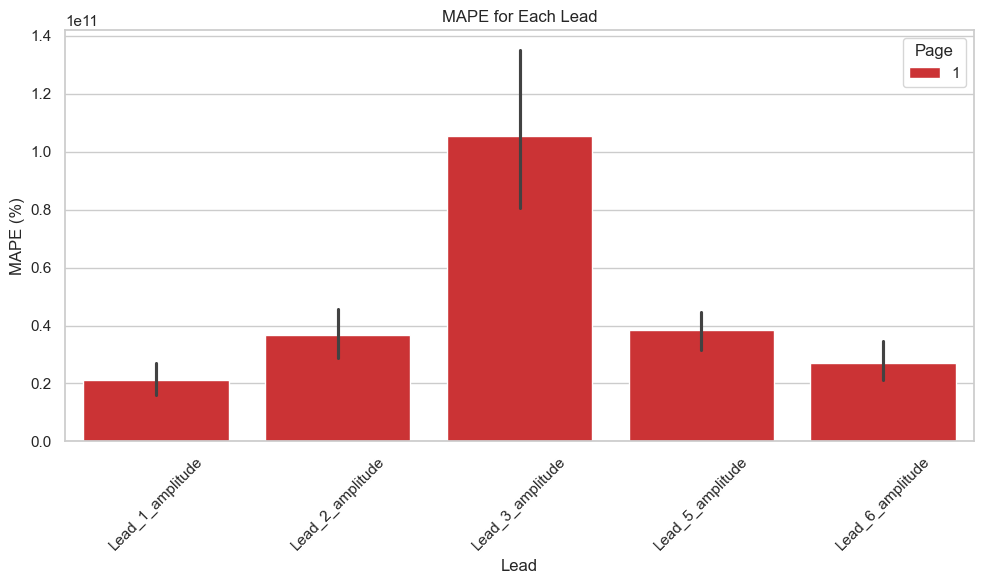

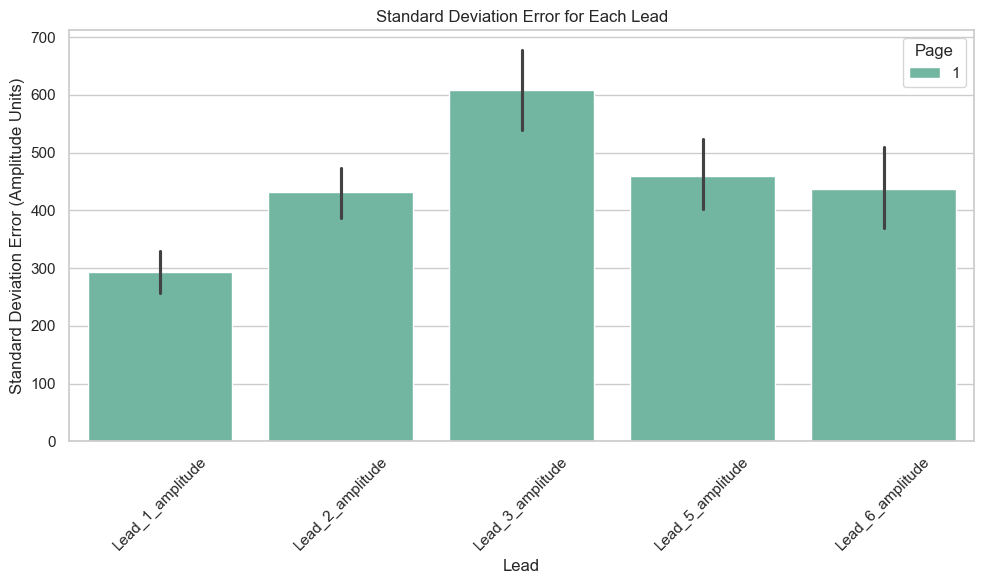

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
validation_folder = r"D:\OsloMet\AI Mind Research\DL ECG Digitization Li and miner\JO Orig V7 2\validation"

# Load the MAPE results into a DataFrame
mape_df = pd.read_csv(os.path.join(validation_folder, "mape_results.csv"))

# Set the plotting style
sns.set(style="whitegrid")

# Plot MAPE
plt.figure(figsize=(10, 6))
sns.barplot(x='Lead', y='MAPE', hue='Page', data=mape_df, palette='Set1')
plt.title('MAPE for Each Lead')
plt.ylabel('MAPE (%)')
plt.xlabel('Lead')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Standard Deviation Error
plt.figure(figsize=(10, 6))
sns.barplot(x='Lead', y='SD_Error', hue='Page', data=mape_df, palette='Set2')
plt.title('Standard Deviation Error for Each Lead')
plt.ylabel('Standard Deviation Error (Amplitude Units)')
plt.xlabel('Lead')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
